#Imports

In [57]:
!pip install gymnasium
!pip install pillow
!pip install moviepy -U
!pip install imageio_ffmpeg
import gymnasium as gym
from gym import error, spaces, utils
from gym.utils import seeding
from typing import Union
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from collections import namedtuple, deque
import os
import copy
from PIL import Image, ImageDraw, ImageFont, ImageSequence
import matplotlib.pyplot as plt
from IPython.display import Image as DisplayImage
from IPython.display import Video
from IPython.display import display, FileLink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Tic-Tac-Toe

In [58]:
class TicTacToeEnv(gym.Env):

    def __init__(self):

      # Board shape
      self.boardShape = (3, 3)

      # Number of agents
      self.numAgents = 2

      # Number of actions per player
      self.numActionsPerPlayer = 9

      # Number of observations per player
      self.numObservationsPerPlayer = 3**9

      # Action and observation spaces
      self.playerActionSpace = spaces.Tuple((spaces.Discrete(self.numAgents), spaces.Discrete(self.numActionsPerPlayer)))
      self.playerObservationSpace = spaces.Tuple((spaces.Discrete(self.numAgents), spaces.Discrete(self.numObservationsPerPlayer)))

      # Game grid and active agent
      self.gameBoard = None
      self.currentPlayer = None

      # Agent symbols (1 for X, -1 for O)
      self.playerSymbols = [1, -1]

      # Empty cell representation
      self.emptyCellValue = 0

      # Lookup table for symbols (X, O, and empty space)
      self.symbolLookupTable = {1: 'X', 0: ' ', -1: 'O'}


    def step(self, action_tuple):
      # Update the game grid with the action
      agent_idx, action_idx = action_tuple
      row = action_idx // 3
      col = action_idx % 3
      self.gameBoard[row, col] = self.playerSymbols[agent_idx]

      # Get the current observation of the grid
      observation = self.gameBoard

      # Check if the current agent has won the game
      checkWin, _ = self.checkWinner()

      if checkWin:
          # If the current agent has won, set rewards and end the game
          rewards = [0 for _ in range(self.numAgents)]
          rewards[self.currentPlayer] = 1
          done = True
          return (self.currentPlayer, observation), tuple(rewards), done, {}

      # Store the current agent index and switch to the next agent
      previous_agent = self.currentPlayer
      self.currentPlayer = (self.currentPlayer + 1) % 2

      # Check if there are no available actions left
      check = self.get_available_actions()
      if not check:
          # If no actions are available, it's a draw, and the game ends
          rewards = [0 for _ in range(self.numAgents)]
          done = True
          return (previous_agent, observation), tuple(rewards), done, {}

      # Continue the game with the next agent
      observations = [self.currentPlayer, observation]
      rewards = [0 for _ in range(self.numAgents)]
      done = False
      return tuple(observations), tuple(rewards), done, {}


    def reset(self):
      # Initialize the game grid to zeros
      self.gameBoard = np.zeros(self.boardShape)

      # Set the starting agent as agent 1
      self.currentPlayer = random.randint(0,1)

      # Return a tuple containing the active agent and the observation
      return self.currentPlayer, self.gameBoard

    def render(self, mode='human', endTheGame=False):
      if mode == 'human':
          for row in self.grid:
              row_str = "| " + " | ".join([self.LOOK_UP_SYM[cell] for cell in row]) + " |"
              print(row_str + "\n")
      elif mode == 'rgb_array':
          # Set the cell size, grid size, border width, and symbol size ratio
          cellSize = 100
          grid_size = cellSize * 3
          border_width = 5
          symbol_size_ratio = 0.40  # Adjust this value to change the symbol size

          # Create an image with a white background
          image = Image.new('RGB', (grid_size, grid_size), (255, 255, 255))

          # Create a draw object to draw on the image
          draw = ImageDraw.Draw(image)

          # Draw the grid lines
          for i in range(1, 3):
              draw.line([(i * cellSize, 0), (i * cellSize, grid_size)], fill=(0, 0, 0), width=border_width)
              draw.line([(0, i * cellSize), (grid_size, i * cellSize)], fill=(0, 0, 0), width=border_width)

          # Define the font for drawing symbols
          fontSize = int(cellSize * symbol_size_ratio)
          # font = ImageFont.truetype("Pillow/Tests/fonts/DejaVuSans.ttf", fontSize)
          font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", fontSize)

          # Draw the agent symbols (X and O) on the image
          for row in range(3):
              for col in range(3):
                  symbol = self.symbolLookupTable[self.gameBoard[row, col]]
                  if symbol != ' ':
                      textWidth, textHeight = draw.textsize(symbol, font=font)
                      x = col * cellSize + (cellSize - textWidth) / 2
                      y = row * cellSize + (cellSize - textHeight) / 2
                      draw.text((x, y), symbol, font=font, fill=(0, 0, 0))

          # Return the image
          return image
      else:
          raise ValueError("Invalid mode. Supported modes are 'human' and 'rgb_array'.")


    def get_available_actions(self):
      availableActions = []
      # Iterate through all potential actions
      for potential_action in range(self.numActionsPerPlayer):
          # Convert the action index to grid coordinates
          row = potential_action // 3
          col = potential_action % 3
          # If the corresponding cell in the grid is empty, add the action to the list
          if self.gameBoard[row, col] == self.emptyCellValue:
              availableActions.append((self.currentPlayer, potential_action))

      return availableActions

    def checkWinner(self):
      # Check rows and columns
      for i in range(3):
          row_sum = np.sum(self.gameBoard[i, :])
          col_sum = np.sum(self.gameBoard[:, i])
          
          if row_sum == 3 or col_sum == 3:
              return True, 0
          elif row_sum == -3 or col_sum == -3:
              return True, 1
              
      # Check diagonals
      diag1_sum = np.sum(np.diag(self.gameBoard))
      diag2_sum = np.sum(np.diag(np.fliplr(self.gameBoard)))
      
      if diag1_sum == 3 or diag2_sum == 3:
          return True, 0
      elif diag1_sum == -3 or diag2_sum == -3:
          return True, 1

      return False, None

##Random Agent


Player 2 (X)


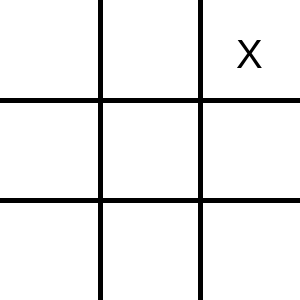

Player 1 (O)


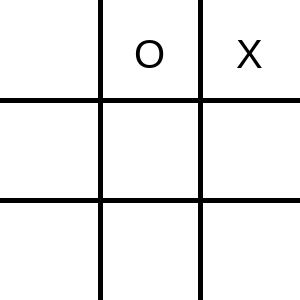

Player 2 (X)


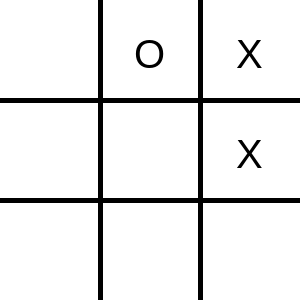

Player 1 (O)


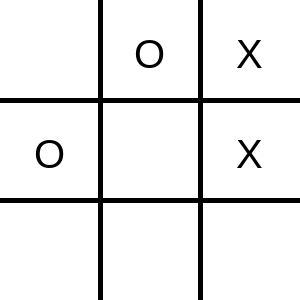

Player 2 (X)


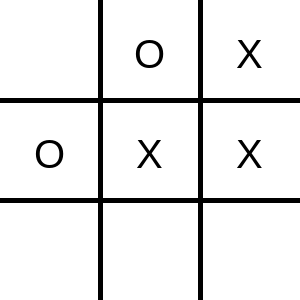

Player 1 (O)


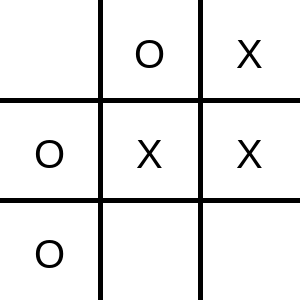

Player 2 (X)


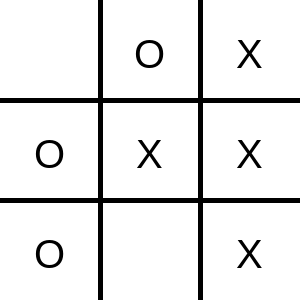

###########################
## Player 2 (X) has won! ##
###########################


In [59]:
env = TicTacToeEnv()
fullobs = env.reset()
while True:
    currentPlayer = 'Player 1 (O)' if fullobs[0] else 'Player 2 (X)'
    print(currentPlayer)
    chosenAction = random.choice(env.get_available_actions())
    fullobs, rewards, done, _ = env.step(chosenAction)
    image = env.render(mode='rgb_array')
    display(image)
    if done:
        won, winningAgent = env.checkWinner()
        if won:
            print("###########################")
            print(f"## {currentPlayer} has won! ##")
            print("###########################")
        else:
            print("##################")
            print("## It's a tie! ##")
            print("##################")
        break

##Q-Learning

In [60]:
class QLearningTicTacToe:
    def __init__(self, env, alpha=0.01, gamma=0.99, epsilonStart=1.0, epsilonMinimum=0.01, epsilonDecay=0.99):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilonStart
        self.epsilonMinimum = epsilonMinimum
        self.epsilonDecay = epsilonDecay
        self.QTables = [np.zeros((env.numObservationsPerPlayer, env.numActionsPerPlayer)), np.zeros((env.numObservationsPerPlayer, env.numActionsPerPlayer))]

    def encodeState(self, state):
        encoded = 0
        for idx in range(9):
            i = idx // 3
            j = idx % 3
            encoded = (state[i, j] + 1) + 3 * encoded
        return int(encoded)

    def selectAction(self, state):
        currentAgent, grid = state
        observation = self.encodeState(grid)

        if random.random() < self.epsilon:
            return (currentAgent, random.choice(self.env.get_available_actions())[1])

        return (currentAgent, np.argmax(self.QTables[currentAgent][observation]))

    def updateQTable(self, state, action, reward, nextState):
        currentAgent, grid = state
        nextAgent, nextGridState = nextState
        observation = self.encodeState(grid)
        nextObservation = self.encodeState(nextGridState)

        currentValue = self.QTables[currentAgent][observation][action[1]]
        nextValue = np.max(self.QTables[nextAgent][nextObservation])

        TDError = (reward + self.gamma * nextValue - currentValue)
        self.QTables[currentAgent][observation][action[1]] += self.alpha * TDError

    def train(self, numberOfEpisodes):
        rewardsPerAgent = {0: [], 1: []}
        epsilonDecay = []

        for episode in range(numberOfEpisodes):
            state = self.env.reset()
            done = False
            episodeRewards = [0, 0]

            while not done:
                action = self.selectAction(state)
                nextState, rewardTuple, done, _ = self.env.step(action)

                currentAgent, grid = state
                episodeRewards[currentAgent] += rewardTuple[currentAgent]

                if not done:
                    self.updateQTable(state, action, rewardTuple[currentAgent], nextState)

                state = nextState

            rewardsPerAgent[0].append(episodeRewards[0])
            rewardsPerAgent[1].append(episodeRewards[1])
            self.epsilon = max(self.epsilonMinimum, self.epsilon * self.epsilonDecay)
            epsilonDecay.append(self.epsilon)

        return rewardsPerAgent, epsilonDecay

    def evaluate(self, numberOfEpisodes=20):
      evaluationRewardsPerAgent = {0: [], 1: []}

      for episode in range(numberOfEpisodes):
          state = self.env.reset()
          done = False
          episodeRewards = [0, 0]

          while not done:
              currentAgent, grid = state
              observation = self.encodeState(grid)

              # Choose the greedy action
              validActions = self.env.get_available_actions()
              validActionPositions = [action[1] for action in validActions if action[0] == currentAgent]
              QValues = self.QTables[currentAgent][observation][validActionPositions]
              bestValidAction = validActionPositions[np.argmax(QValues)]

              action = (currentAgent, bestValidAction)

              nextState, rewardTuple, done, _ = self.env.step(action)
              episodeRewards[currentAgent] += rewardTuple[currentAgent]
              state = nextState

          evaluationRewardsPerAgent[0].append(episodeRewards[0])
          evaluationRewardsPerAgent[1].append(episodeRewards[1])

      return evaluationRewardsPerAgent

In [61]:
env = TicTacToeEnv()
multiAgent = QLearningTicTacToe(env, alpha=0.001, gamma=0.99, epsilonStart=1.0, epsilonMinimum=0.01, epsilonDecay=0.99)
episodes = 500
totalRewards, epsilonDecay = multiAgent.train(episodes)
numberOfEpisodes = 20
totalEvaluationRewards = multiAgent.evaluate(numberOfEpisodes)

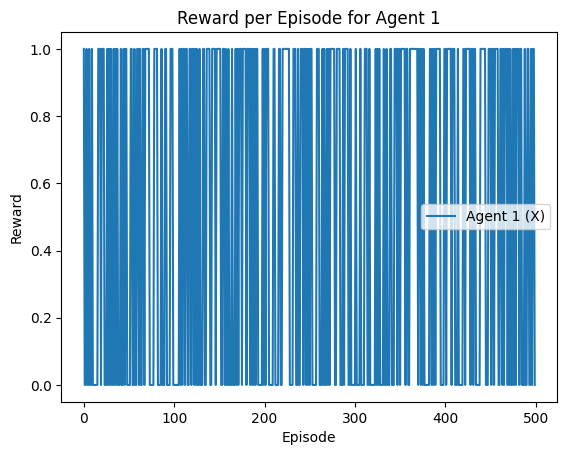

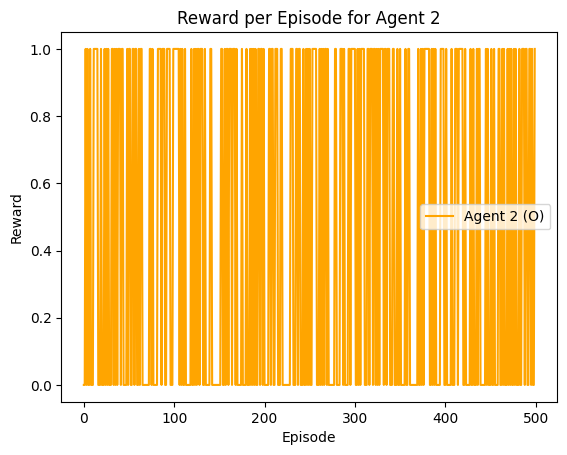

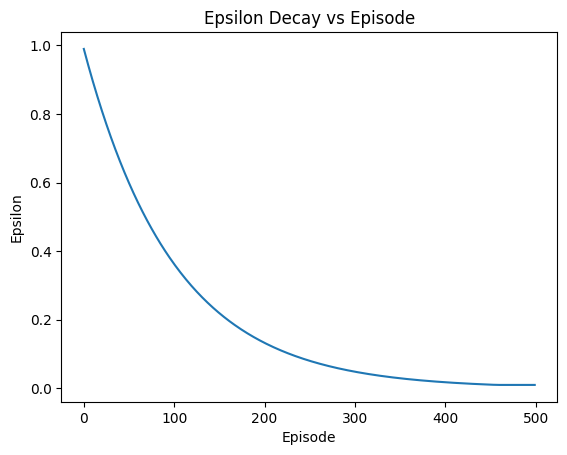

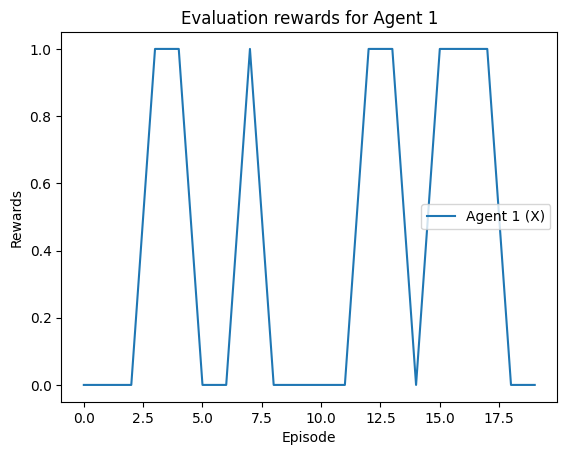

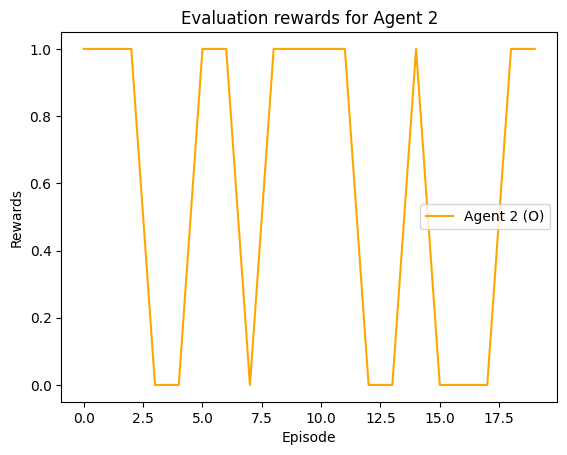

In [62]:
plt.plot(totalRewards[0], label="Agent 1 (X)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.title("Reward per Episode for Agent 1")
plt.show()

plt.plot(totalRewards[1], label="Agent 2 (O)", color = "orange")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.title("Reward per Episode for Agent 2")
plt.show()

plt.plot(range(len(epsilonDecay)), epsilonDecay)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay vs Episode')
plt.show()

# Plotting the total rewards per episode during evaluation
plt.plot(totalEvaluationRewards[0], label="Agent 1 (X)")
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title("Evaluation rewards for Agent 1")
plt.legend()
plt.show()

plt.plot(totalEvaluationRewards[1], label="Agent 2 (O)", color = "orange")
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title("Evaluation rewards for Agent 2")
plt.legend()
plt.show()

##Generate GIF

In [63]:
def generateGIFWhenAgentWon(agent, env, GifFilePath):
    state = env.reset()
    done = False
    images = []

    while not done:
        currentAgent, grid = state
        observation = agent.encodeState(grid)

        # Choose a random action
        ValidActions = env.get_available_actions()
        ValidActionPositions = [action[1] for action in ValidActions if action[0] == currentAgent]
        randomValidActions = random.choice(ValidActionPositions)

        action = (currentAgent, randomValidActions)

        nextState, rewardTuple, done, _ = env.step(action)

        if done:
            won, winningAgent = env.checkWinner()
            if won:
                image = env.render(mode='rgb_array')
                images.append(image)
                break

        state = nextState
        image = env.render(mode='rgb_array')
        images.append(image)

    # Save the images as a GIF
    if images:
        images[0].save(GifFilePath, save_all=True, append_images=images[1:], duration=500, loop=0)

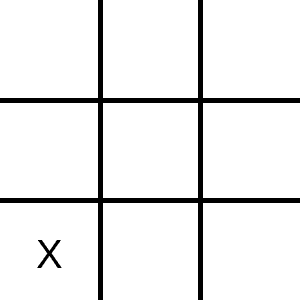

In [64]:
GifFilePath = "TicTacToe.gif"
generateGIFWhenAgentWon(multiAgent, env, GifFilePath)
DisplayImage(filename=GifFilePath)

##Double DQN

In [ ]:
import tensorflow as tf

class NNNetwork:
    def __init__(self, inputShape, numberOfActions, alpha=0.01):
        self.model = self.getTheModel(inputShape, numberOfActions, alpha)

    def getTheModel(self, inputShape, numberOfActions, alpha):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=inputShape),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(numberOfActions)
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=alpha), loss='mse')
        return model

    def predict(self, state):
        return self.model(state)

    def fit(self, state, target, epochs, verbose):
        self.model.fit(state, target, epochs=epochs, verbose=verbose)

    def setWeights(self, weights):
        self.model.set_weights(weights)

    def getWeights(self):
        return self.model.get_weights()

class DDQNTicTacToe:
    def __init__(self, env, alpha=0.01, gamma=0.99, epsilon=1.0, epsilonMinimum=0.01, epsilonDecay=0.99):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilonMinimum = epsilonMinimum
        self.epsilonDecay = epsilonDecay
        self.updateTimesteps = 100

        self.model = [self.getTheModel(), self.getTheModel()]
        self.targetModel = [self.getTheModel(), self.getTheModel()]
        self.updateTargetModels()

    def getTheModel(self):
        return NNNetwork(inputShape=(9,), numberOfActions=self.env.numActionsPerPlayer, alpha=self.alpha)

    def encodeState(self, state):
        return state.flatten()

    def chooseAction(self, state):
        currentAgent, grid = state
        encodedState = self.encodeState(grid).reshape(1, -1)

        if random.random() < self.epsilon:
            return (currentAgent, random.choice(self.env.get_available_actions())[1])

        return (currentAgent, np.argmax(self.model[currentAgent].predict(encodedState)))

    def updateModel(self, state, action, reward, nextState, done):
        currentAgent, grid = state
        nextAgent, nextGrid = nextState
        encodedState = self.encodeState(grid).reshape(1, -1)
        encodedNextState = self.encodeState(nextGrid).reshape(1, -1)

        QValues = self.model[currentAgent].predict(encodedState)

        target = QValues.numpy()
        nextQValuesOnline = self.model[nextAgent].predict(encodedNextState)
        nextQValuesTarget = self.targetModel[nextAgent].predict(encodedNextState)

        bestAction = np.argmax(nextQValuesOnline)
        nextValue = nextQValuesTarget[0][bestAction]

        if done:
            target[0][action[1]] = reward
        else:
            target[0][action[1]] = reward + self.gamma * nextValue

        self.model[currentAgent].fit(encodedState, target, epochs=1, verbose=0)

    def updateTargetModels(self):
        for i in range(self.env.numAgents):
            self.targetModel[i].setWeights(self.model[i].getWeights())

    def train(self, numberOfEpisodes):
        totalRewards = []
        agent1Rewards = []
        agent2Rewards = []
        epsilonDecay = []
        agent1Count = 0
        agent2Count = 0
        tied = 0

        for episode in range(numberOfEpisodes):
            state = self.env.reset()
            done = False
            episodeRewards = [0, 0]

            while not done:
                action = self.chooseAction(state)
                nextState, rewardTuple, done, _ = self.env.step(action)

                currentAgent, grid = state
                episodeRewards[currentAgent] += rewardTuple[currentAgent]

                if not done:
                    self.updateModel(state, action, rewardTuple[currentAgent], nextState, done)

                state = nextState

            if episode % self.updateTimesteps == 0:
                self.updateTargetModels()

            totalRewards.append(sum(episodeRewards))
            agent1Rewards.append(episodeRewards[0])
            agent2Rewards.append(episodeRewards[1])
            self.epsilon = max(self.epsilonMinimum, self.epsilon * self.epsilonDecay)
            epsilonDecay.append(self.epsilon)

            print(f"Episode {episode + 1}: Agent 1 reward = {episodeRewards[0]}, Agent 2 reward = {episodeRewards[1]}")
            if episodeRewards[0] == 1:
              agent1Count+=1
            elif episodeRewards[1] == 1:
              agent2Count+=1
            else:
              tied+=1
        print(agent1Count, agent2Count, tied)
        return totalRewards, agent1Rewards, agent2Rewards, epsilonDecay

    def evaluate(self, numberOfEpisodes = 10):
        totalEvaluationRewards = []
        agent1EvaluationRewards = []
        agent2EvaluationRewards = []

        for episode in range(numberOfEpisodes):
            state = self.env.reset()
            done = False
            episodeRewards = [0, 0]

            while not done:
                currentAgent, grid = state
                encodedState = self.encodeState(grid).reshape(1, -1)

                # Choose the greedy action
                validActions = self.env.get_available_actions()
                validActionPositions = [action[1] for action in validActions if action[0] == currentAgent]
                QValues = self.model[currentAgent].predict(encodedState)
                validQValues = tf.gather(QValues, validActionPositions, axis=1)
                bestValidAction = validActionPositions[np.argmax(validQValues)]

                action = (currentAgent, bestValidAction)

                nextState, rewardTuple, done, _ = self.env.step(action)
                episodeRewards[currentAgent] += rewardTuple[currentAgent]
                state = nextState

            totalEvaluationRewards.append(sum(episodeRewards))
            agent1EvaluationRewards.append(episodeRewards[0])
            agent2EvaluationRewards.append(episodeRewards[1])

        return totalEvaluationRewards, agent1EvaluationRewards, agent2EvaluationRewards

In [ ]:
env = TicTacToeEnv()

DDQNagent = DDQNTicTacToe(env, alpha=0.01, gamma=0.99, epsilon=1.0, epsilonMinimum=0.01, epsilonDecay=0.99)

numberOfEpisodes = 500
totalRewards, agent1Rewards, agent2Rewards, epsilonDecay = DDQNagent.train(numberOfEpisodes)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 1: Agent 1 reward = 1, Agent 2 reward = 0
Episode 2: Agent 1 reward = 0, Agent 2 reward = 1
Episode 3: Agent 1 reward = 0, Agent 2 reward = 1
Episode 4: Agent 1 reward = 1, Agent 2 reward = 0
Episode 5: Agent 1 reward = 1, Agent 2 reward = 0
Episode 6: Agent 1 reward = 1, Agent 2 reward = 0
Episode 7: Agent 1 reward = 0, Agent 2 reward = 0
Episode 8: Agent 1 reward = 1, Agent 2 reward = 0
Episode 9: Agent 1 reward = 0, Agent 2 reward = 1
Episode 10: Agent 1 reward = 0, Agent 2 reward = 1
Episode 11: Agent 1 reward = 0, Agent 2 reward = 1
Episode 12: Agent 1 reward = 0, Agent 2 reward = 0
Episode 13: Agent 1 reward = 0, Agent 2 reward = 1
Episode 14: Agent 1 reward = 0, Agent 2 reward = 0
Episode 15: Agent 1 reward = 1, Agent 2 reward = 0
Episode 16: Agent 1 reward = 0, Agent 2 reward = 0
Episode 17: Agent 1 reward = 1, Agent 2 reward = 0
Episode 18: Agent 1 reward = 1, Agent 2 reward = 0
Episode 19: Agent 1 reward = 0, Agent 2 reward = 0
Episode 20: Agent 1 reward = 1, Agent 2 

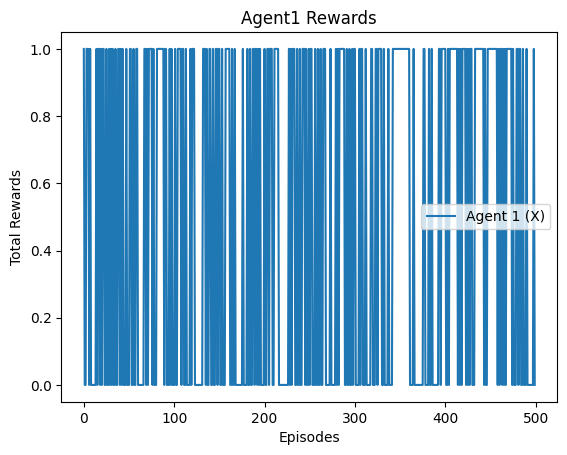

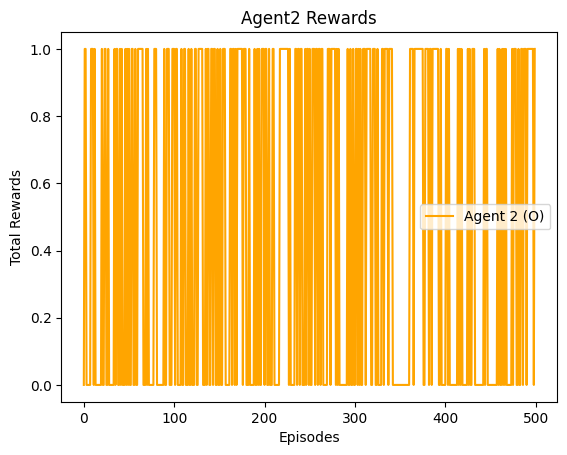

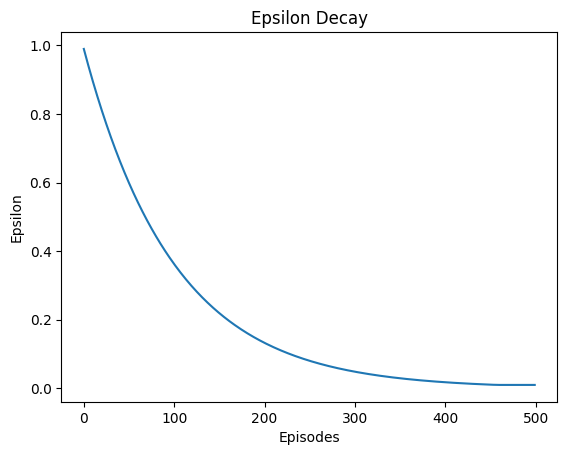

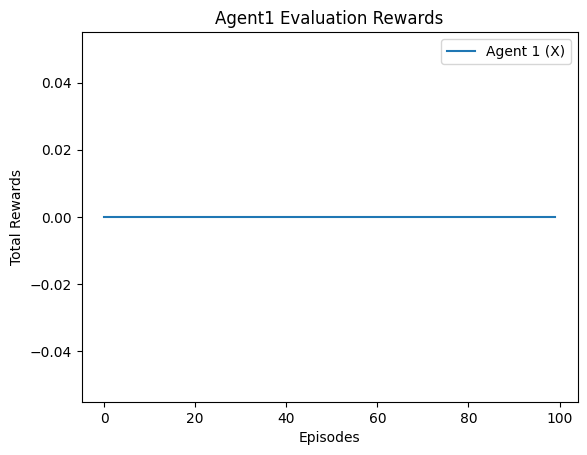

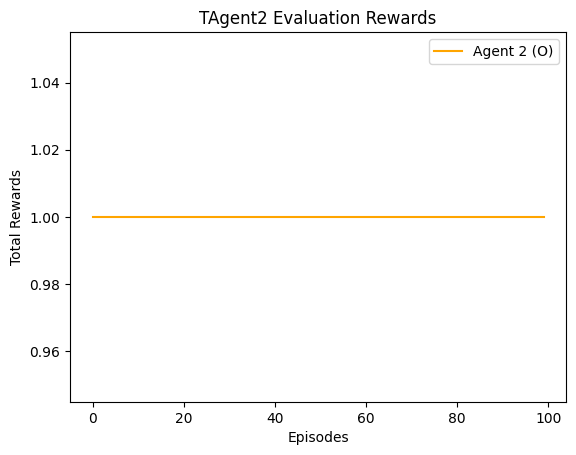

In [ ]:
evaluationEpisodes = 100
totalEvaluationRewards, agent1EvaluationRewards, agent2EvaluationRewards = DDQNagent.evaluate(evaluationEpisodes)

# Plot the total rewards vs episodes graph
plt.plot(agent1Rewards, label="Agent 1 (X)")
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Agent1 Rewards')
plt.legend()
plt.show()

plt.plot(agent2Rewards, label="Agent 2 (O)", color = "orange")
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Agent2 Rewards')
plt.legend()
plt.show()

# Plot the epsilon decay graph
plt.plot(range(numberOfEpisodes), epsilonDecay)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay')
plt.show()

# Plot the evaluation rewards vs episodes graph
plt.plot(agent1EvaluationRewards, label="Agent 1 (X)")
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Agent1 Evaluation Rewards')
plt.legend()
plt.show()

plt.plot(agent2EvaluationRewards, label="Agent 2 (O)", color = "orange")
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Agent2 Evaluation Rewards')
plt.legend()
plt.show()

#Rock Paper Scissors

In [67]:
class RockPaperScissorsEnv(gym.Env):
    def __init__(self, rockImagePath, paperImagePath, leftScissorsImagePath, rightScissorsImagePath, resizeRatio=1.0):
      # Reward matrix
      self.rewardMatrix = [[(0, 0), (-1, 1), (1, -1)],
                [(1, -1), (0, 0), (-1, 1)],
                [(-1, 1), (1, -1), (0, 0)]]
      
      self.numberOfAgents = 2  
      self.numberOfActions = len(self.rewardMatrix) 
      self.numberOfStates = 1  # one-state MDP
      self.saveOutcome = None
      self.iteration = 0
      self.totalNumberOfIterations = None

      self.actionSpace = spaces.Tuple((spaces.Discrete(self.numberOfActions), spaces.Discrete(self.numberOfActions)))
      self.observationSpace = spaces.Discrete(self.numberOfStates)
      
      self.WORD_FOR_ACTION = {0: 'ROCK', 1: 'PAPER', 2: 'SCISSORS'}

      self.rockImage = Image.open(rockImagePath)
      self.paperImage = Image.open(paperImagePath)
      self.leftScissorImage = Image.open(leftScissorsImagePath)
      self.rightScissorsImage = Image.open(rightScissorsImagePath)

      if resizeRatio != 1.0:
        newPaperSize = (int(self.paperImage.width * resizeRatio), int(self.paperImage.height * resizeRatio))
        self.paperImage = self.paperImage.resize(newPaperSize, Image.ANTIALIAS)
      
      self.imageMapping = {
        0: self.rockImage,
        1: self.paperImage,
        2: {
            0: self.leftScissorImage,          # Left-facing scissors for Player 1
            1: self.rightScissorsImage     # Right-facing scissors for Player 2
        }
    }

    def reset(self, maxIterations=10):
      self.currentIteration = 0
      self.maxIterations = maxIterations
      self.recordResult = None
      return 0

    def step(self, action):
      observation = 0
      rewardValues = self._get_rewards(action)
      finished = False
      self.recordResult = (self.currentIteration, action, rewardValues)

      self.currentIteration += 1

      for i in range(self.maxIterations):
          if self.currentIteration == i:
              if i == (self.maxIterations - 1):
                  finished = True
              break
      return observation, rewardValues, finished, {}

    def render(self, returnImage = False):
        if self.recordResult is None:
            print('Game has not started.')
            return

        currentIteration, performedAction, rewardValues = self.recordResult
        winner = None
        if rewardValues[0] > rewardValues[1]:
            winner = 0
        elif rewardValues[1] > rewardValues[0]:
            winner = 1

        gridWidth = self.rockImage.width * 2 + 10
        gridHeight = self.rockImage.height

        grid = Image.new('RGBA', (gridWidth, gridHeight), (255, 255, 255, 255))

        for i, action in enumerate(performedAction):
            x_offset = i * (self.rockImage.width + 10)
            if action == 2:  
                grid.paste(self.imageMapping[action][i], (x_offset, 0))
            else:
                grid.paste(self.imageMapping[action], (x_offset, 0))

        if returnImage:
            return grid
        else:
            grid.show()

        print(f'Player 1 -> action: {self.WORD_FOR_ACTION[performedAction[0]]} reward: {rewardValues[0]}')
        print(f'Player 2 -> action: {self.WORD_FOR_ACTION[performedAction[1]]} reward: {rewardValues[1]}')

        if winner is None:
            print('Game is tied.')
        elif winner == 0:
            print('Player 1 won!')
        elif winner == 1:
            print('Player 2 won!')

    def _get_rewards(self, selectedAction):
      return self.rewardMatrix[selectedAction[0]][selectedAction[1]]

    def generateGIF(self, playerActions, GIFOutputPath, numberOfIterations=10):
        images = []
        for i in range(numberOfIterations):
            actions = (playerActions[0][i], playerActions[1][i])
            self.step(actions)
            image = self.render(returnImage=True)
            draw = ImageDraw.Draw(image)
            
            fontSize = 12
            font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", fontSize)

            winnerText = ""
            if self.recordResult is not None:
                _, _, rewardValues = self.recordResult
                if rewardValues[0] > rewardValues[1]:
                    winnerText = "Player 1 wins!"
                elif rewardValues[1] > rewardValues[0]:
                    winnerText = "Player 2 wins!"
                else:
                    winnerText = "Game is tied!"

            textWidth, textHeight = draw.textsize(winnerText, font)
            x = (image.width - textWidth) // 2
            y = (image.height - textHeight) // 2

            draw.text((x, y), winnerText, font=font, fill=(0, 0, 0, 255))
            images.append(image)

        images[0].save(GIFOutputPath, save_all=True, append_images=images[1:], duration=1000, loop=0)

##Random Agent

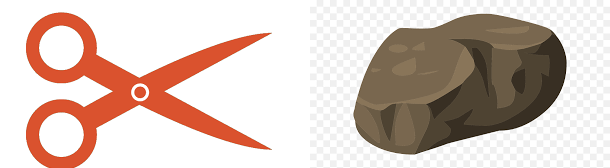

Player 1 -> action: SCISSORS reward: -1
Player 2 -> action: ROCK reward: 1
Player 2 won!


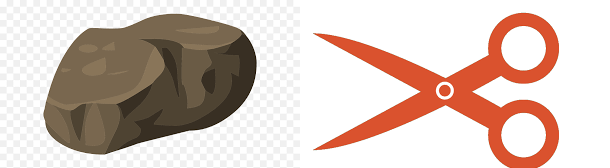

Player 1 -> action: ROCK reward: 1
Player 2 -> action: SCISSORS reward: -1
Player 1 won!


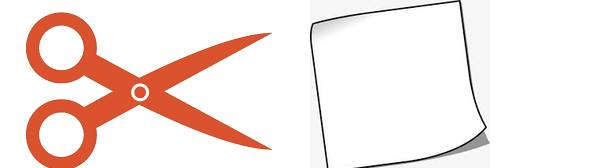

Player 1 -> action: SCISSORS reward: 1
Player 2 -> action: PAPER reward: -1
Player 1 won!


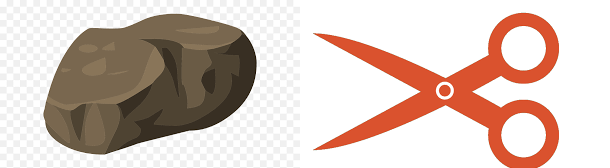

Player 1 -> action: ROCK reward: 1
Player 2 -> action: SCISSORS reward: -1
Player 1 won!


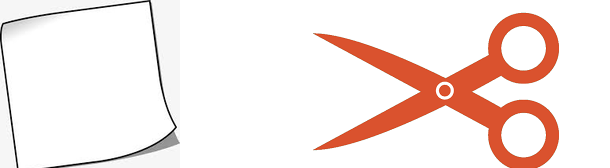

Player 1 -> action: PAPER reward: -1
Player 2 -> action: SCISSORS reward: 1
Player 2 won!


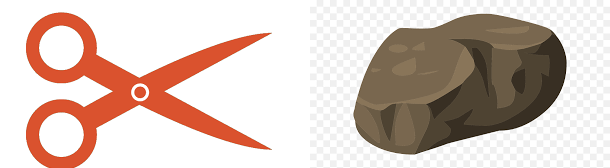

Player 1 -> action: SCISSORS reward: -1
Player 2 -> action: ROCK reward: 1
Player 2 won!


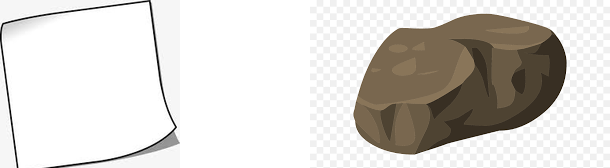

Player 1 -> action: PAPER reward: 1
Player 2 -> action: ROCK reward: -1
Player 1 won!


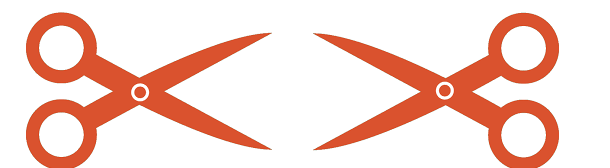

Player 1 -> action: SCISSORS reward: 0
Player 2 -> action: SCISSORS reward: 0
Game is tied.


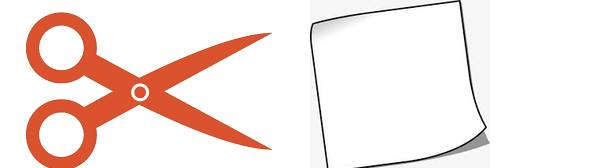

Player 1 -> action: SCISSORS reward: 1
Player 2 -> action: PAPER reward: -1
Player 1 won!


In [68]:
env = RockPaperScissorsEnv('images/rock.png', 'images/paper.jpeg', 'images/scissor.png', 'images/scissor_right.png', resizeRatio=0.79)
maxIterations = 10
obs = env.reset(maxIterations)  
while True:
    action = env.actionSpace.sample()
    observation, rewardValues, done, _ = env.step(action)  
    env.render()
    # print(rewardValues)
    if done:
        break

##Generate GIF

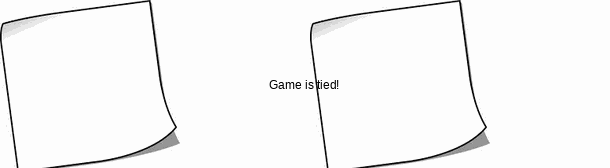

In [69]:
numberOfIterations = 10
player1Actions = [random.randint(0, 2) for _ in range(numberOfIterations)]
player2Actions = [random.randint(0, 2) for _ in range(numberOfIterations)]

env.reset(maxIterations=numberOfIterations)
outputPath = "RockPaperScissors.gif"
env.generateGIF((player1Actions, player2Actions), outputPath, numberOfIterations=numberOfIterations)
DisplayImage(filename=outputPath)

##Q-Learning

In [70]:
class QLearningRockPaperScissors:
    def __init__(self, env, alpha=0.01, gamma=0.99, epsilon=1.0, epsilonMinimum=0.01, epsilonDecay=0.99):
        self.env = env
        self.QTable = np.zeros((env.numberOfAgents, env.numberOfActions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilonMinimum = epsilonMinimum
        self.epsilonDecay = epsilonDecay

    def greedy(self, player):
        return np.argmax(self.QTable[player])

    def epsilonGreedy(self, player):
        if np.random.rand() < self.epsilon:
            return self.env.actionSpace.sample()[player]
        else:
            return self.greedy(player)

    def train(self, numberOfEpisodes):
        rewardsForBothAgents = []
        epsilonPerEpisode = []

        for episode in range(numberOfEpisodes):
            state = self.env.reset()
            done = False
            episodeRewards = np.zeros(self.env.numberOfAgents)

            while not done:
                action1 = self.epsilonGreedy(0)
                action2 = self.epsilonGreedy(1)
                action = (action1, action2)

                nextState, rewards, done, _ = self.env.step(action)

                for player in range(self.env.numberOfAgents):
                    opponent = 1 - player

                    QTarget = rewards[player] + self.gamma * np.max(self.QTable[opponent])
                    TDError = QTarget - self.QTable[player][action[player]]
                    self.QTable[player][action[player]] += self.alpha * TDError

                episodeRewards += rewards

            self.epsilon = max(self.epsilonMinimum, self.epsilon * self.epsilonDecay)
            rewardsForBothAgents.append(episodeRewards)
            epsilonPerEpisode.append(self.epsilon)

        return rewardsForBothAgents, epsilonPerEpisode


    def evaluate(self, numberOfEvalEpisodes):
      evaluationRewardsForAgents = []

      for _ in range(numberOfEvalEpisodes):
          state = self.env.reset()
          done = False
          episodeRewards = np.zeros(self.env.numberOfAgents)

          while not done:
              action1 = self.greedy(0)
              action2 = self.greedy(1)
              action = (action1, action2)

              _, rewards, done, _ = self.env.step(action)
              episodeRewards += rewards

          evaluationRewardsForAgents.append(episodeRewards)

      return evaluationRewardsForAgents

In [71]:
envRockPaperScissors = RockPaperScissorsEnv('images/rock.png', 'images/paper.jpeg', 'images/scissor.png', 'images/scissor_right.png', resizeRatio=0.79)
RockPaperScissorsagent = QLearningRockPaperScissors(envRockPaperScissors, alpha=0.01, gamma=0.99, epsilon=1.0, epsilonMinimum=0.01, epsilonDecay=0.99)

rewardsForBothAgents, epsilonPerEpisode = RockPaperScissorsagent.train(numberOfEpisodes=1000)

agent1Rewards = [rewards[0] for rewards in rewardsForBothAgents]
agent2Rewards = [rewards[1] for rewards in rewardsForBothAgents]

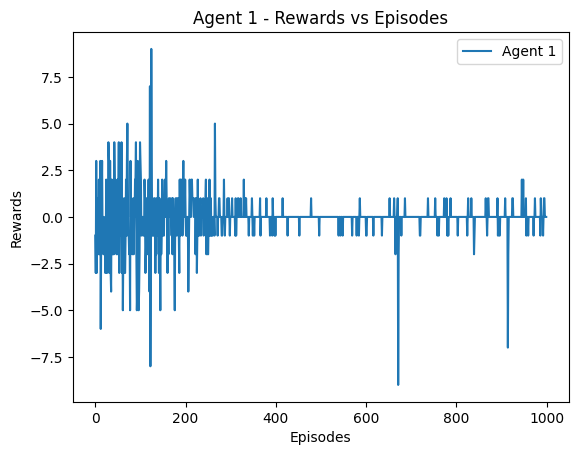

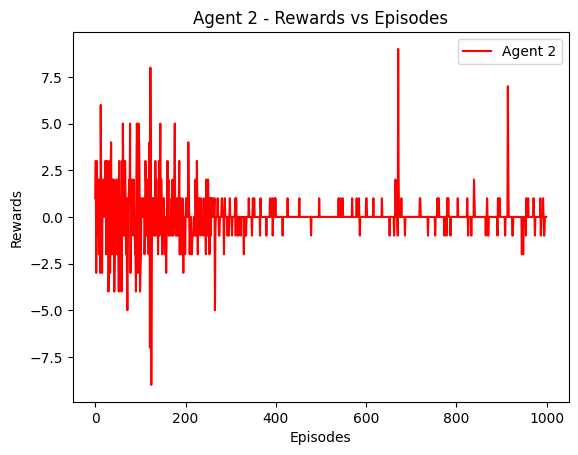

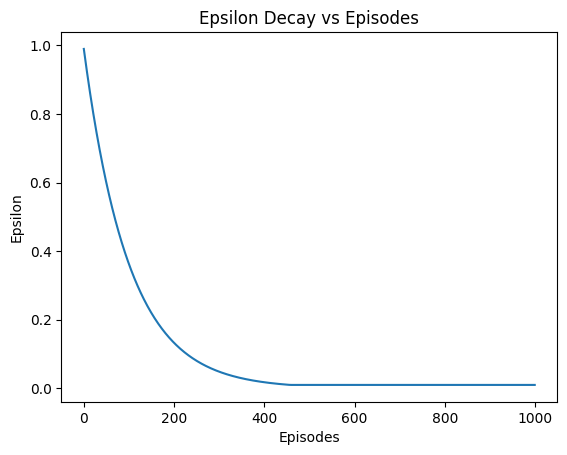

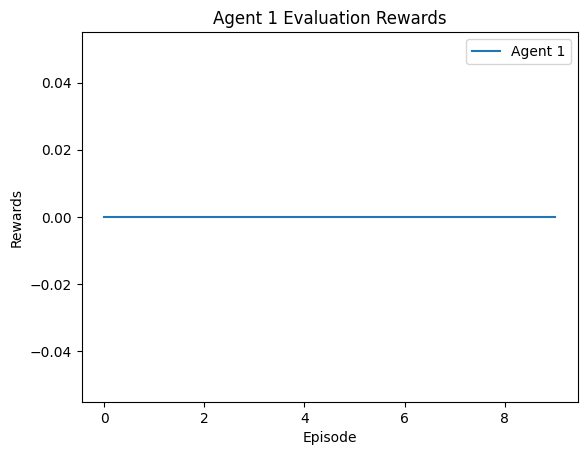

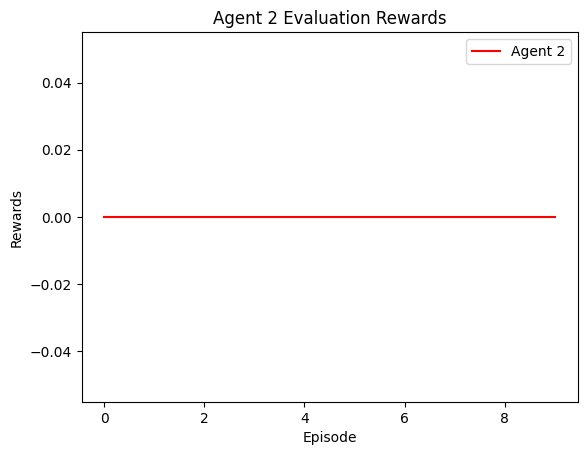

In [72]:
evaluationRewardsForAgents = RockPaperScissorsagent.evaluate(numberOfEvalEpisodes=10)

agent1EvaluationRewards = [rewards[0] for rewards in evaluationRewardsForAgents]
agent2EvaluationRewards = [rewards[1] for rewards in evaluationRewardsForAgents]

# total rewards vs episodes graph for Agent 1
plt.plot(agent1Rewards, label='Agent 1')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Agent 1 - Rewards vs Episodes')
plt.legend()
plt.show()

# total rewards vs episodes graph for Agent 2
plt.plot(agent2Rewards, label='Agent 2', color='red')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Agent 2 - Rewards vs Episodes')
plt.legend()
plt.show()

# epsilon decay vs episodes graph
plt.plot(epsilonPerEpisode)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay vs Episodes')
plt.show()

# total rewards per episode during evaluation for Agent 1
plt.plot(agent1EvaluationRewards, label='Agent 1')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Agent 1 Evaluation Rewards')
plt.legend()
plt.show()

# total rewards per episode during evaluation for Agent 2
plt.plot(agent2EvaluationRewards, label='Agent 2', color='red')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Agent 2 Evaluation Rewards')
plt.legend()
plt.show()

##Double DQN

In [73]:
class NNNetwork(nn.Module):
    def __init__(self, stateSpace, actionSpace, seed, hiddenLayers=[32, 32]):
        super(NNNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layers = nn.ModuleList([nn.Linear(stateSpace, hiddenLayers[0])])
        self.layers.extend([nn.Linear(hiddenLayers[i], hiddenLayers[i+1]) for i in range(len(hiddenLayers) - 1)])
        self.layers.append(nn.Linear(hiddenLayers[-1], actionSpace))

    def forward(self, state):
        x = state
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)

class DDQNRockPaperScissors():
    def __init__(self, stateSpace, actionSpace, seed, batchSize = 64, gamma = 0.99, epsilon = 1.0, initialEpsilon = 1.0, epsilonMinimum = 0.01, epsilonDecay = 0.995, copyWeightsRate = 0.001):
        self.stateSpace = stateSpace
        self.actionSpace = actionSpace
        self.seed = random.seed(seed)

        self.QNetwork = NNNetwork(stateSpace, actionSpace, seed)
        self.targetQNetwork = NNNetwork(stateSpace, actionSpace, seed)
        self.optimizer = optim.Adam(self.QNetwork.parameters(), lr=0.001)

        self.memory = deque(maxlen=10000)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "nextState", "done"])
        self.gamma = gamma
        self.batchSize = batchSize
        self.epsilon = epsilon
        self.initialEpsilon = initialEpsilon
        self.epsilonMinimum = epsilonMinimum
        self.epsilonDecay = epsilonDecay
        self.copyWeightsRate = copyWeightsRate

    def step(self, state, action, reward, nextState, done):
        e = self.experience(state, action, reward, nextState, done)
        self.memory.append(e)
        if len(self.memory) > self.batchSize:
            experiences = self.sample()
            self.update(experiences)

    def act(self, state, epsilon=0.5):
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.QNetwork.eval()
        with torch.no_grad():
            actionValues = self.QNetwork(state)
        self.QNetwork.train()

        if random.random() > epsilon:
            return np.argmax(actionValues.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.actionSpace))

    def update(self, experiences):
        states, actions, rewards, nextStates, dones = experiences

        nextQTargets = self.targetQNetwork(nextStates).detach().max(1)[0].unsqueeze(1)
        QTarget = rewards + (self.gamma * nextQTargets * (1 - dones))

        predictedQ = self.QNetwork(states).gather(1, actions)

        loss = nn.MSELoss()(predictedQ, QTarget)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.layerUpdate(self.QNetwork, self.targetQNetwork)

    def layerUpdate(self, localNetwork, targetNetwork):
        for targetParameters, localParameters in zip(targetNetwork.parameters(), localNetwork.parameters()):
            targetParameters.data.copy_(self.copyWeightsRate * localParameters.data + (1.0 - self.copyWeightsRate) * targetParameters.data)

    def sample(self):
      experiences = random.sample(self.memory, k=self.batchSize)

      states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
      actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
      rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
      nextStates = torch.from_numpy(np.vstack([e.nextState for e in experiences if e is not None])).float()
      dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()

      return (states, actions, rewards, nextStates, dones)

def evaluationForbothAgents(agent1, agent2, env, numberOfEpisodes=100, epsilon=0.05):
    evaluationRewardsForAgent1 = []
    evaluationRewardsForAgent2 = []

    for episodes in range(1, numberOfEpisodes + 1):
        state = env.reset()
        rewardsForAgent1 = 0
        rewardsForAgent2 = 0

        while True:
            numpyState = np.array([state])
            action1 = agent1.act(numpyState, epsilon)
            action2 = agent2.act(numpyState, epsilon)
            nextState, (reward1, reward2), done, _ = env.step((action1, action2))
            state = nextState
            rewardsForAgent1 += reward1
            rewardsForAgent2 += reward2

            if done:
                break

        evaluationRewardsForAgent1.append(rewardsForAgent1)
        evaluationRewardsForAgent2.append(rewardsForAgent2)

    return evaluationRewardsForAgent1, evaluationRewardsForAgent2


def epsilonDecayValues(initialEpsilon, epsilonMinimum, epsilonDecay, numberOfEpisodes):
    epsilonValues = [initialEpsilon * epsilonDecay ** i for i in range(numberOfEpisodes)]
    epsilonValues = [max(epsilon, epsilonMinimum) for epsilon in epsilonValues]
    return epsilonValues

def train(env, agent1, agent2, numberOfEpisodes=1000, maxTimesteps=256):
    rewardsForAgent1Array = []
    rewardsForAgent2Array = []
    rewardsForAgent1Window = deque(maxlen=100)
    rewardsForAgent2Window = deque(maxlen=100)

    for episodes in range(1, numberOfEpisodes + 1):
        state = env.reset()
        rewardsForAgent1 = 0
        rewardsForAgent2 = 0

        for t in range(maxTimesteps):
            numpyState = np.array([state])
            action1 = agent1.act(numpyState, agent1.epsilon)
            action2 = agent2.act(numpyState, agent2.epsilon)
            nextState, (reward1, reward2), done, _ = env.step((action1, action2))

            agent1.step(numpyState, action1, reward1, numpyState, done)
            agent2.step(numpyState, action2, reward2, numpyState, done)

            state = nextState
            rewardsForAgent1 += reward1
            rewardsForAgent2 += reward2

            if done:
                break

        rewardsForAgent1Window.append(rewardsForAgent1)
        rewardsForAgent2Window.append(rewardsForAgent2)
        rewardsForAgent1Array.append(rewardsForAgent1)
        rewardsForAgent2Array.append(rewardsForAgent2)

        agent1.epsilon = max(agent1.epsilon * agent1.epsilonDecay, agent1.epsilonMinimum)
        agent2.epsilon = max(agent2.epsilon * agent2.epsilonDecay, agent2.epsilonMinimum)

    return rewardsForAgent1Array, rewardsForAgent2Array

In [74]:
env = RockPaperScissorsEnv('images/rock.png', 'images/paper.jpeg', 'images/scissor.png', 'images/scissor_right.png', resizeRatio=0.79)

agent1 = DDQNRockPaperScissors(stateSpace=1, actionSpace=3, seed=0, batchSize=256, gamma = 0.99, epsilon = 1.0, initialEpsilon = 1.0, epsilonMinimum = 0.01, epsilonDecay = 0.995, copyWeightsRate = 0.001)
agent2 = DDQNRockPaperScissors(stateSpace=1, actionSpace=3, seed=0, batchSize=256, gamma = 0.99, epsilon = 1.0, initialEpsilon = 1.0, epsilonMinimum = 0.01, epsilonDecay = 0.995, copyWeightsRate = 0.001)

rewardsForAgent1, rewardsForAgent2 = train(env, agent1, agent2, numberOfEpisodes=1000, maxTimesteps=800)

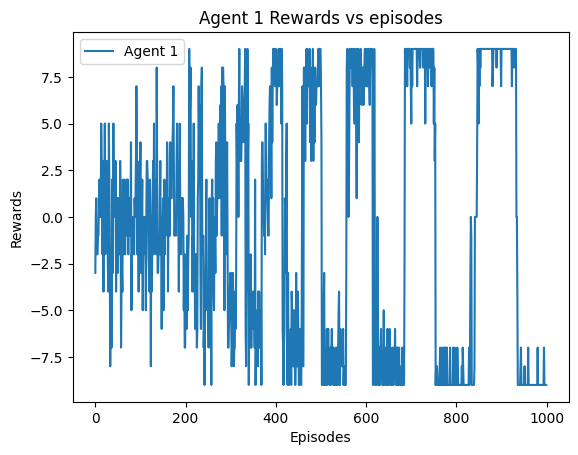

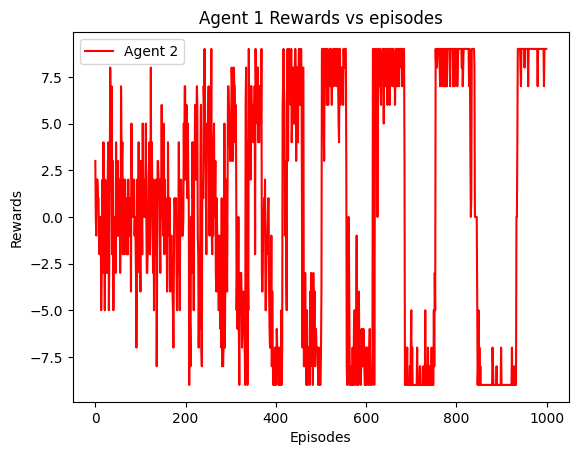

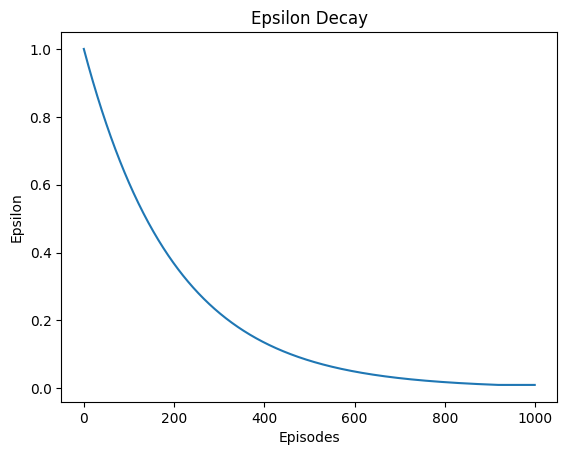

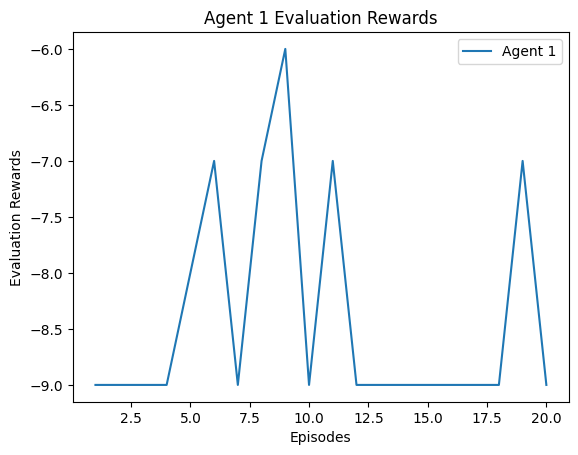

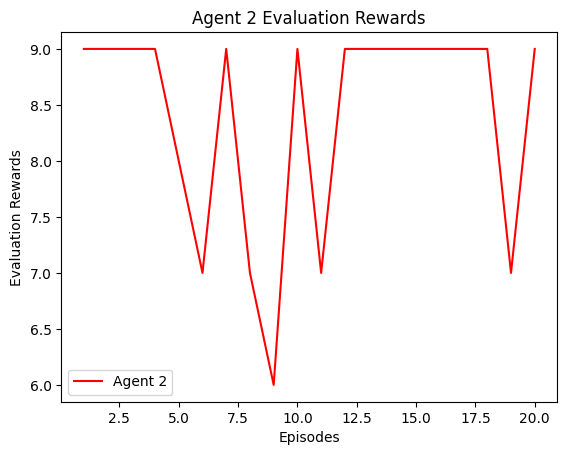

In [75]:
numberOfEvaluationEpisodes = 20
evaluationRewardsForAgent1, evaluationRewardsForAgent2 = evaluationForbothAgents(agent1, agent2, env, numberOfEpisodes=numberOfEvaluationEpisodes, epsilon=0.05)

#reward graph
plt.plot(np.arange(len(rewardsForAgent1)), rewardsForAgent1, label="Agent 1")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend()
plt.title("Agent 1 Rewards vs episodes")
plt.show()

plt.plot(np.arange(len(rewardsForAgent2)), rewardsForAgent2, label="Agent 2", color = "red")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend()
plt.title("Agent 1 Rewards vs episodes")
plt.show()

#epsilon decay graph
epsilonValues = epsilonDecayValues(agent1.initialEpsilon, agent1.epsilonMinimum, agent1.epsilonDecay, len(rewardsForAgent1))
plt.plot(np.arange(len(epsilonValues)), epsilonValues)
plt.xlabel("Episodes")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

plt.plot(np.arange(1, len(evaluationRewardsForAgent1) + 1), evaluationRewardsForAgent1, label="Agent 1")
plt.xlabel("Episodes")
plt.ylabel("Evaluation Rewards")
plt.legend()
plt.title("Agent 1 Evaluation Rewards")
plt.show()

plt.plot(np.arange(1, len(evaluationRewardsForAgent2) + 1), evaluationRewardsForAgent2, label="Agent 2", color = "red")
plt.xlabel("Episodes")
plt.ylabel("Evaluation Rewards")
plt.legend()
plt.title("Agent 2 Evaluation Rewards")
plt.show()


#Switch Game

##Supporting Classes and Functions

In [76]:
class switchGameActionSpace(list):
    def __init__(self, actionSpaceForAgents):
        super(switchGameActionSpace, self).__init__(actionSpaceForAgents)
        self._actionSpaceForAgents = actionSpaceForAgents

    def sample(self):
        return [agentActionSpace.sample() for agentActionSpace in self._actionSpaceForAgents]

class switchGameObservationSpace(list):
    def __init__(self, observationSpaceForAgents):
        super().__init__(observationSpaceForAgents)
        self._observationSpaceForAgents = observationSpaceForAgents

    def sample(self):
        return [agentObservationSpace.sample() for agentObservationSpace in self._observationSpaceForAgents]

    def presentIn(self, obs):
        for i in range(len(obs)):
          if not self._observationSpaceForAgents[i].presentIn(obs[i]):
              return False
        return True

def getCellSizes(cellSize: Union[int, list, tuple]):
    if isinstance(cellSize, int):
        return cellSize, cellSize
    elif isinstance(cellSize, (tuple, list)):
        if len(cellSize) == 2:
            return cellSize[1], cellSize[0]
    return None

def drawGrid(rows, columns, cellSize=50, fill='black', lineColor='black'):
    xcellSize, ycellSize = getCellSizes(cellSize)
    image = Image.new(mode='RGB', size=(columns * xcellSize, rows * ycellSize), color=fill)

    draw = ImageDraw.Draw(image)
    for coord in list(range(0, image.width, xcellSize)) + [image.width - 1]:
        draw.line([(coord, 0), (coord, image.height)], fill=lineColor)

    for coord in list(range(0, image.height, ycellSize)) + [image.height - 1]:
        draw.line([(0, coord), (image.width, coord)], fill=lineColor)

    del draw
    return image

def fillTheCell(image, pos, cellSize=None, fill='black', margin=0):
    xcellSize, ycellSize = getCellSizes(cellSize)
    col, row = pos
    row, col = row * xcellSize, col * ycellSize
    xMargin, yMargin = margin * xcellSize, margin * ycellSize
    x, y, xDash, yDash = row + xMargin, col + yMargin, row + xcellSize - xMargin, col + ycellSize - yMargin
    ImageDraw.Draw(image).rectangle([(x, y), (xDash, yDash)], fill=fill)

def fillTheCellText(image, text, pos, cellSize=None, fill='black', margin=0):
    xcellSize, ycellSize = getCellSizes(cellSize)
    col, row = pos
    row, col = row * xcellSize, col * ycellSize
    xMargin, yMargin = margin * xcellSize, margin * ycellSize
    x, y = row + xMargin, col + yMargin
    ImageDraw.Draw(image).text((x, y), text=text, fill=fill)

def drawCellBoundary(image, pos, cellSize=50, fill='black'):
    xcellSize, ycellSize = getCellSizes(cellSize)
    col, row = pos
    row, col = row * xcellSize, col * ycellSize
    ImageDraw.Draw(image).rectangle([(row, col), (row + xcellSize, col + ycellSize)], outline=fill, width=3)

def drawCircle(image, pos, cellSize=50, fill='black', radius=0.3):
    xcellSize, ycellSize = getCellSizes(cellSize)
    col, row = pos
    row, col = row * xcellSize, col * ycellSize
    xGap, yGap = xcellSize * radius, ycellSize * radius
    x, y = row + xGap, col + yGap
    xDash, yDash = row + xcellSize - xGap, col + ycellSize - yGap
    ImageDraw.Draw(image).ellipse([(x, y), (xDash, yDash)], outline=fill, fill=fill)

In [77]:
class Switch(gym.Env):

    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self, fullyObservableMode=False, stepCost=0, numberOfAgents=2, maximumNumberOfSteps=50, clock=True, 
                 agentColors=None, cellSize=30, wallColor='grey', agentsActions=None):

        if agentColors is None:
            self.agentColors = {0: 'red', 1: 'blue'}
        else:
            self.agentColors = agentColors

        self.cellSize = cellSize
        self.wallColor = wallColor

        if agentsActions is None:
            self.agentsActions = {0: "DOWN", 1: "LEFT", 2: "UP", 3: "RIGHT", 4: "NOOP"}
        else:
            self.agentsActions = agentsActions

        self.gridShape = (3, 7)
        self.numberOfAgents = numberOfAgents
        self.maximumNumberOfSteps = maximumNumberOfSteps
        self.stepCount = None
        self.stepCost = stepCost
        self.totalRewards = None
        self.clock = clock
        self.agentWorkHasDone = None

        self.actionSpace = switchGameActionSpace([spaces.Discrete(5) for _ in range(self.numberOfAgents)])  

        initialAgentPosition = {0: [0, 1], 1: [0, self.gridShape[1] - 2],
                          2: [2, 1], 3: [2, self.gridShape[1] - 2]}
        finalAgentPosition = {0: [0, self.gridShape[1] - 1], 1: [0, 0],
                           2: [2, self.gridShape[1] - 1], 3: [2, 0]}

        self.initialAgentPosition, self.finalAgentPosition = {}, {}
        for agent_i in range(numberOfAgents):
            self.initialAgentPosition[agent_i] = initialAgentPosition[agent_i]
            self.finalAgentPosition[agent_i] = finalAgentPosition[agent_i]

        self.baseGrid = self.createAnEmptyGrid() 
        self.fullyObservable = self.createAnEmptyGrid()
        self.initialFullObservation()
        self.viewer = None

        self.fullyObservableMode = fullyObservableMode
        self.highObservation = np.ones(2 + (1 if self.clock else 0))
        self.lowObservation = np.zeros(2 + (1 if self.clock else 0))
        if self.fullyObservableMode:
            self.highObservation = np.tile(self.highObservation, self.numberOfAgents)
            self.lowObservation = np.tile(self.lowObservation, self.numberOfAgents)
        self.observationSpace = switchGameObservationSpace([spaces.Box(self.lowObservation, self.highObservation) for _ in range(self.numberOfAgents)])
        self.seed()

    def createBaseImage(self):
        self.baseImage = drawGrid(self.gridShape[0], self.gridShape[1], cellSize=self.cellSize, fill='white')
        for row in range(self.gridShape[0]):
            for col in range(self.gridShape[1]):
                if self.isWallExists((row, col)):
                    fillTheCell(self.baseImage, (row, col), cellSize=self.cellSize, fill=self.wallColor)

        for agent_i, pos in list(self.finalAgentPosition.items())[:self.numberOfAgents]:
            row, col = pos[0], pos[1]
            drawCellBoundary(self.baseImage, (row, col), cellSize=self.cellSize, fill=self.agentColors[agent_i])

    def createAnEmptyGrid(self):
        grid = -1 * np.ones(self.gridShape)  
        grid[self.gridShape[0] // 2, :] = 0  
        grid[:, [0, 1]] = 0
        grid[:, [-1, -2]] = 0
        return grid

    def initialFullObservation(self):
        self.agentPosition = copy.copy(self.initialAgentPosition)
        self.fullyObservable = self.createAnEmptyGrid()
        for agent_i, pos in self.agentPosition.items():
            self.updateAgentView(agent_i)
        self.createBaseImage()

    def retrieveAgentObservation(self):
        observation = []
        for agent_i in range(0, self.numberOfAgents):
            pos = self.agentPosition[agent_i]
            _agent_i_obs = [round(pos[0] / (self.gridShape[0] - 1), 2),
                            round(pos[1] / (self.gridShape[1] - 1), 2)]
            if self.clock:
                _agent_i_obs += [self.stepCount / self.maximumNumberOfSteps]  
            observation.append(_agent_i_obs)

        if self.fullyObservableMode:
            observation = np.array(observation).flatten().tolist()
            observation = [observation for _ in range(self.numberOfAgents)]

        return observation

    def reset(self):
        self.initialFullObservation()
        self.stepCount = 0
        self.agentWorkHasDone = [False for _ in range(self.numberOfAgents)]
        self.totalRewards = [0 for _ in range(self.numberOfAgents)]
        return self.retrieveAgentObservation()

    def isWallExists(self, pos):
        row, col = pos
        return self.baseGrid[row, col] == -1

    def isCellEmpty(self, pos):
        isPositionValid = (0 <= pos[0] < self.gridShape[0]) and (0 <= pos[1] < self.gridShape[1])
        return isPositionValid and (self.fullyObservable[pos[0], pos[1]] == 0)

    def updateAgentPosition(self, agent_i, move):
        currentPosition = copy.copy(self.agentPosition[agent_i])
        nextPosition = None
        if move == 0:  
            nextPosition = [currentPosition[0] + 1, currentPosition[1]]
        elif move == 1:  
            nextPosition = [currentPosition[0], currentPosition[1] - 1]
        elif move == 2:  
            nextPosition = [currentPosition[0] - 1, currentPosition[1]]
        elif move == 3:  
            nextPosition = [currentPosition[0], currentPosition[1] + 1]
        elif move == 4:  
            pass
        else:
            print("#########" + str(move) + "###########")

        if nextPosition is not None and self.isCellEmpty(nextPosition):
            self.agentPosition[agent_i] = nextPosition
            self.fullyObservable[currentPosition[0], currentPosition[1]] = 0
            self.updateAgentView(agent_i)
        else:
            pass

    def updateAgentView(self, agent_i):
        self.fullyObservable[self.agentPosition[agent_i][0], self.agentPosition[agent_i][1]] = agent_i + 1

    def hasTheAgentWon(self, agent_i):
        return self.agentPosition[agent_i] == self.finalAgentPosition[agent_i]

    def step(self, agents_action):
        self.stepCount += 1
        rewards = [self.stepCost for _ in range(self.numberOfAgents)]
        for agent_i, action in enumerate(agents_action):
            if not (self.agentWorkHasDone[agent_i]):
                self.updateAgentPosition(agent_i, action)

                self.agentWorkHasDone[agent_i] = self.hasTheAgentWon(agent_i)
                if self.agentWorkHasDone[agent_i]:
                    rewards[agent_i] = 5
            else:
                rewards[agent_i] = 0

        if self.stepCount >= self.maximumNumberOfSteps:
            for i in range(self.numberOfAgents):
                self.agentWorkHasDone[i] = True

        for i in range(self.numberOfAgents):
            self.totalRewards[i] += rewards[i]

        return self.retrieveAgentObservation(), rewards, self.agentWorkHasDone, {}

    def render(self, mode='human'):
        image = copy.copy(self.baseImage)
        for agent_i in range(self.numberOfAgents):
            drawCircle(image, self.agentPosition[agent_i], cellSize=self.cellSize, fill=self.agentColors[agent_i], radius=0.3)
            fillTheCellText(image, text=str(agent_i + 1), pos=self.agentPosition[agent_i], cellSize=self.cellSize,
                            fill='white', margin=0.4)
        image = np.asarray(image)

        if mode == 'rgb_array':
            return image
        elif mode == 'human':
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.show(block=False)
            plt.pause(0.1)
            plt.clf()

    def seed(self, n=None):
        self.np_random, seed = seeding.np_random(n)
        return [seed]

    def endTheGame(self):
        if self.viewer is not None:
            self.viewer.endTheGame()
            self.viewer = None

##Random Agent

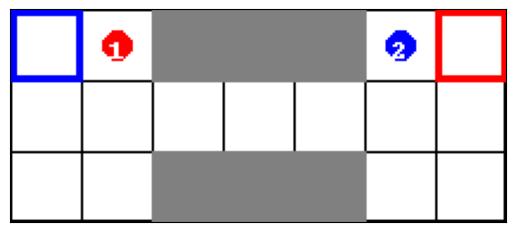

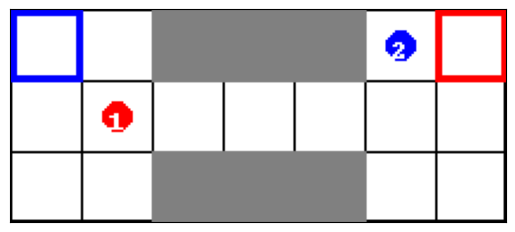

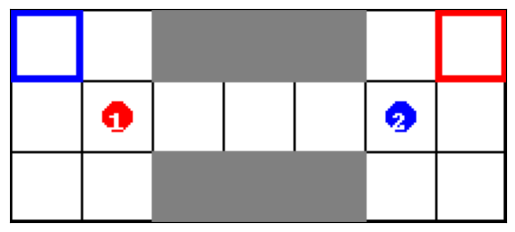

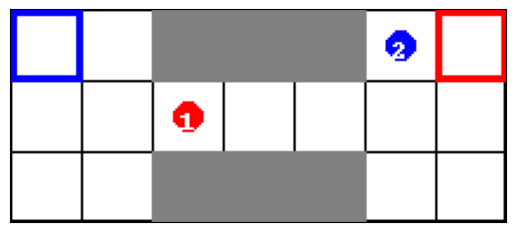

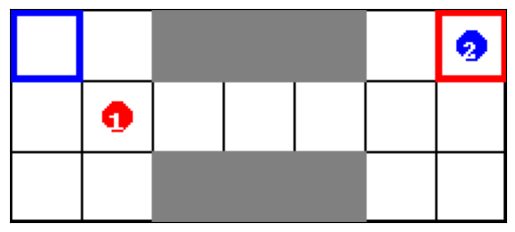

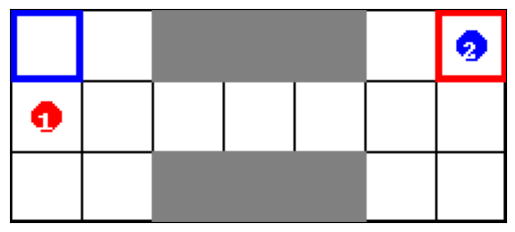

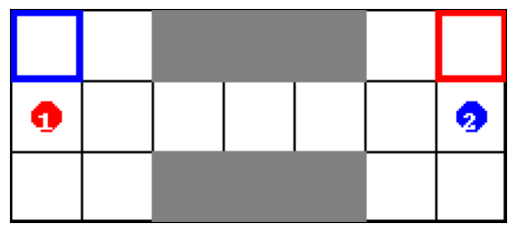

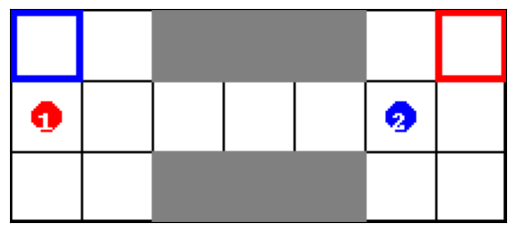

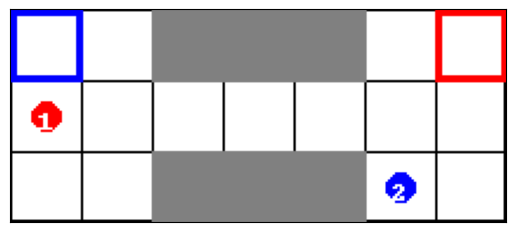

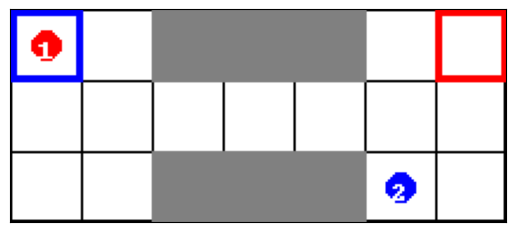

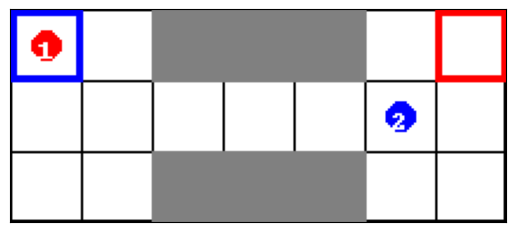

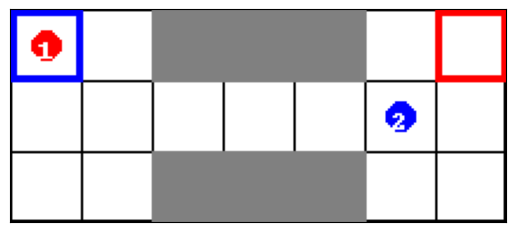

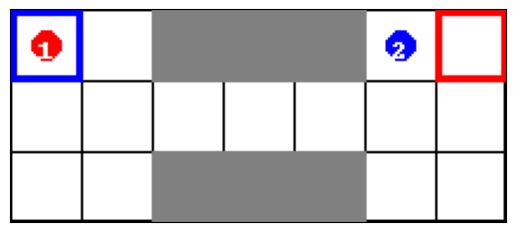

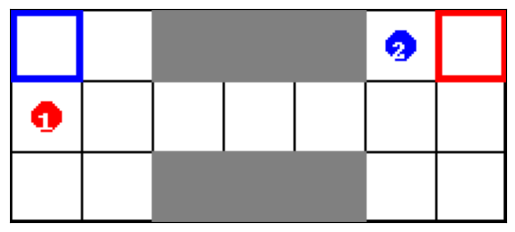

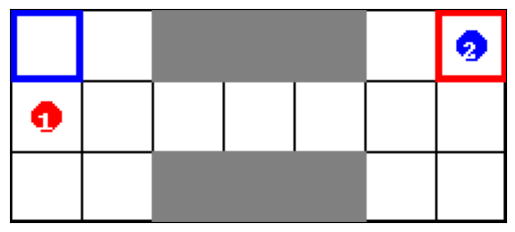

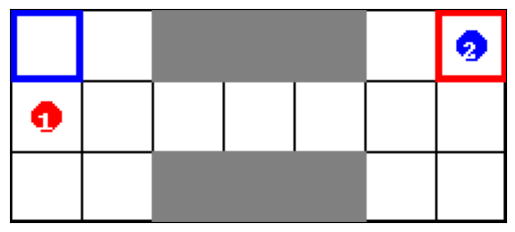

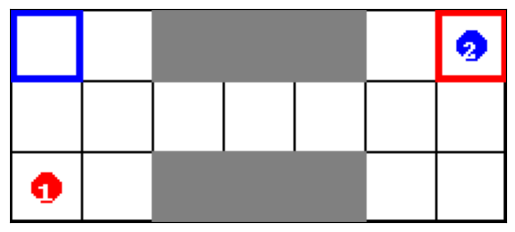

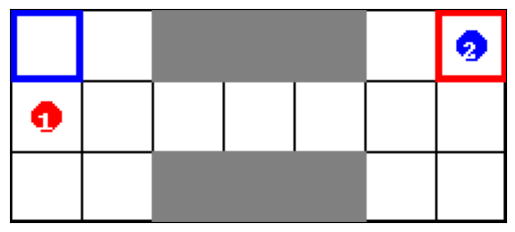

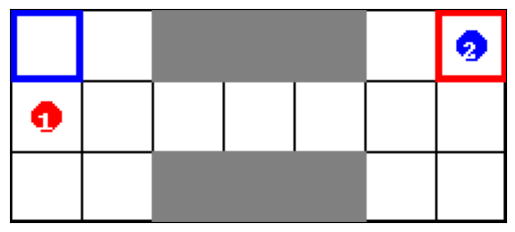

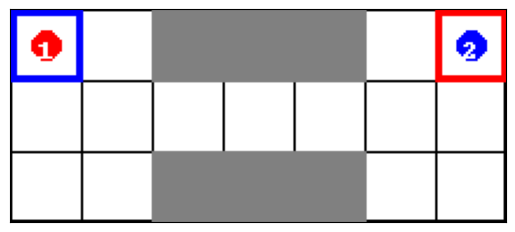

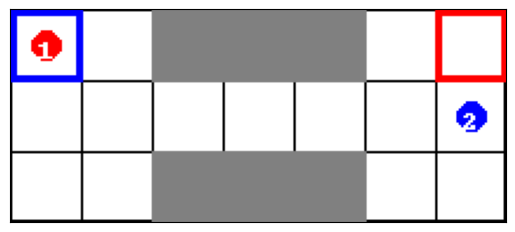

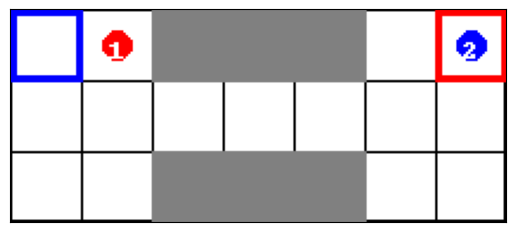

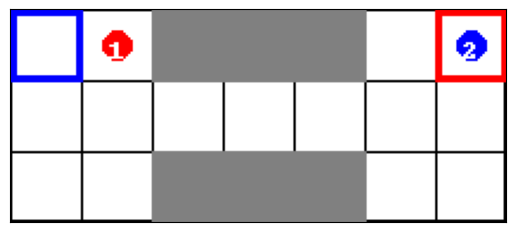

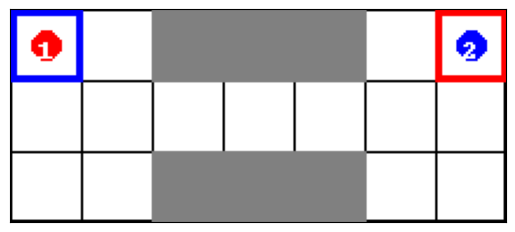

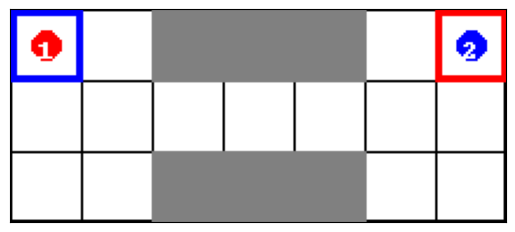

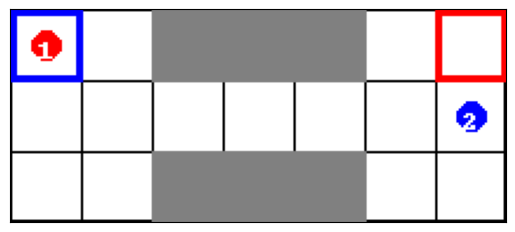

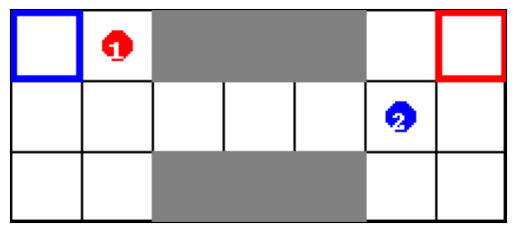

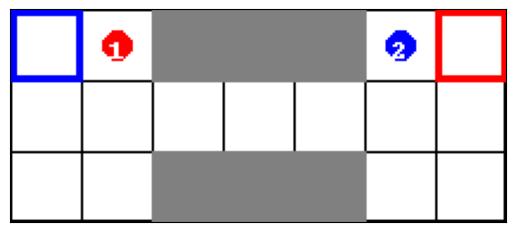

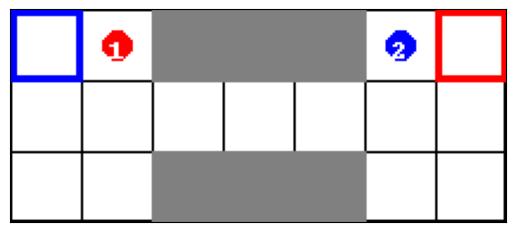

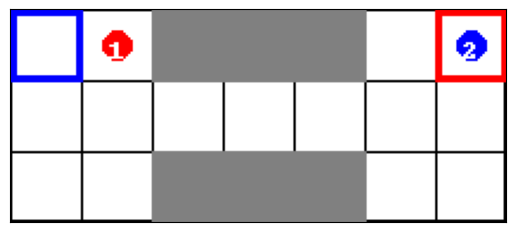

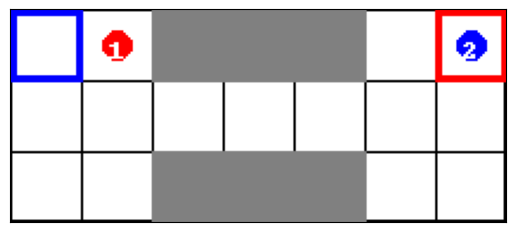

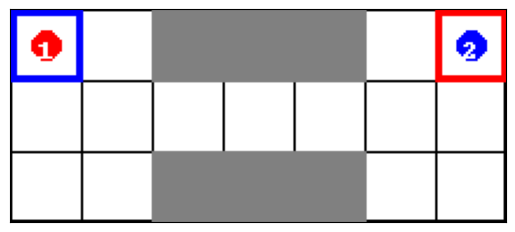

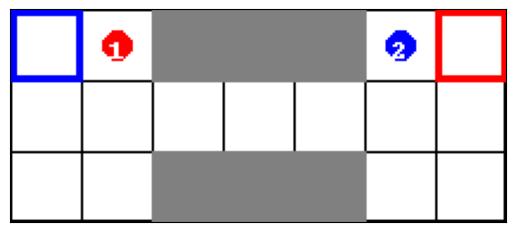

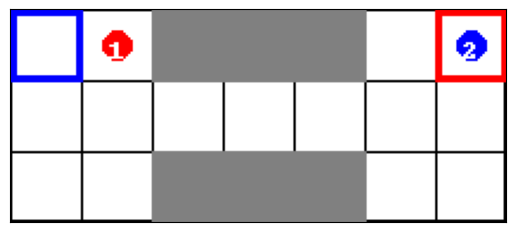

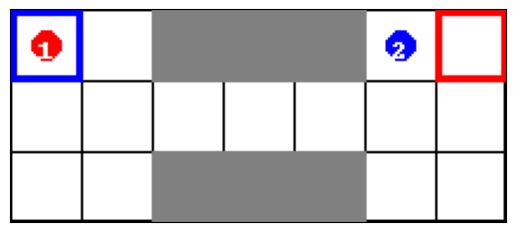

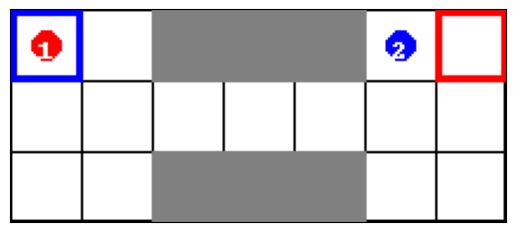

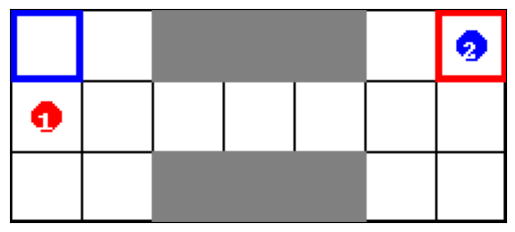

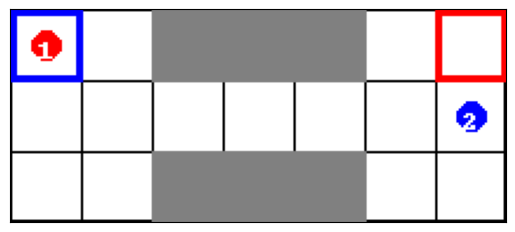

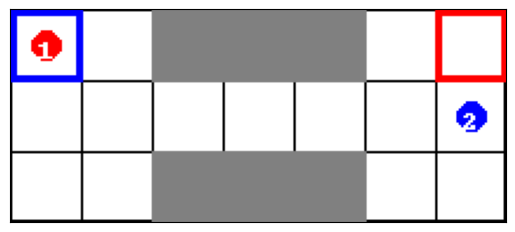

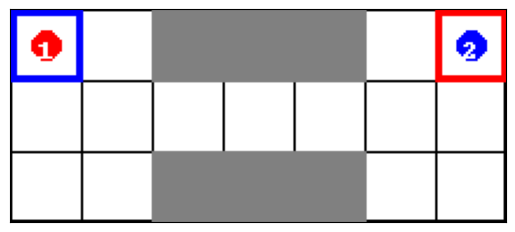

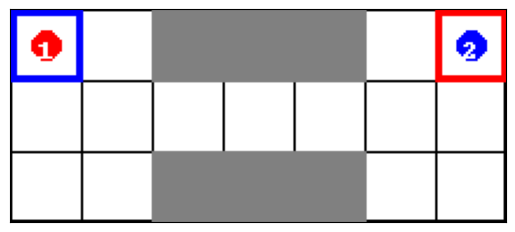

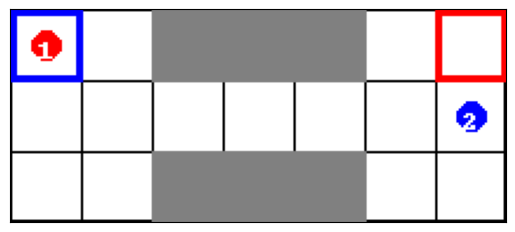

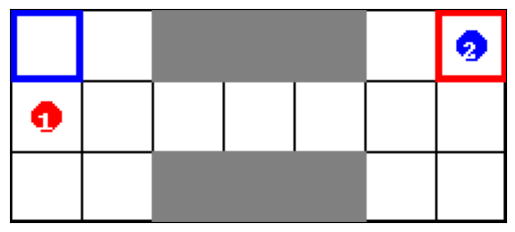

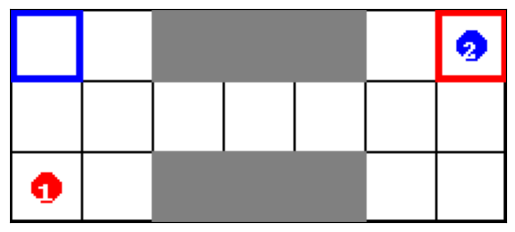

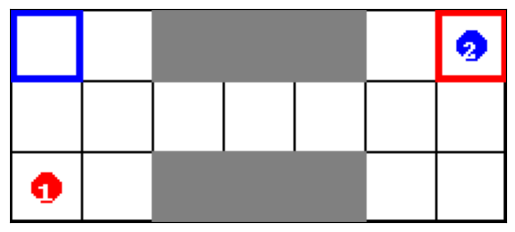

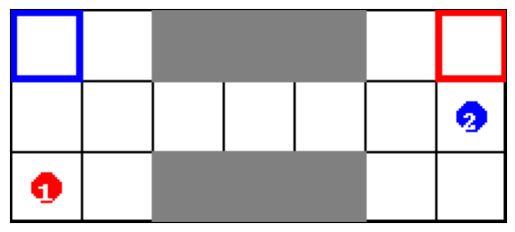

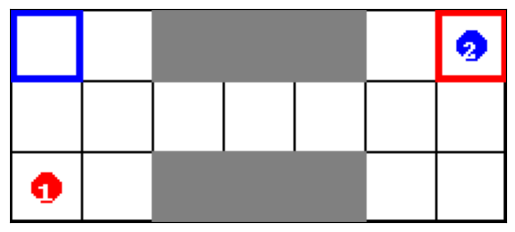

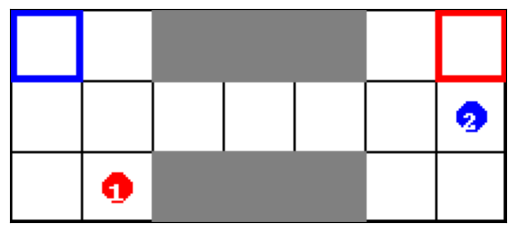

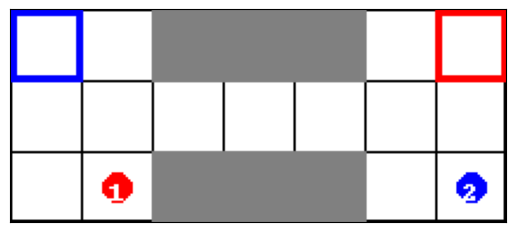

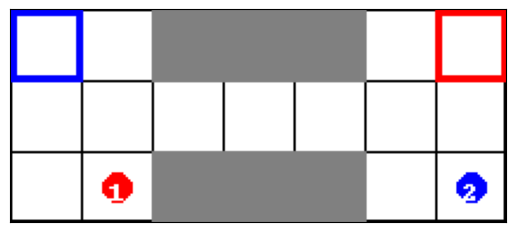

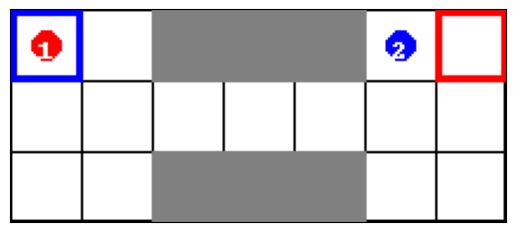

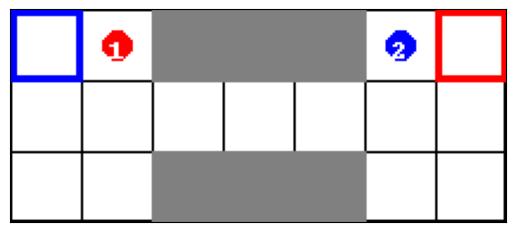

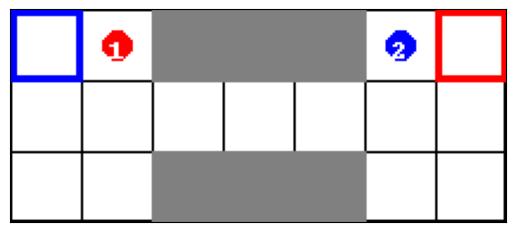

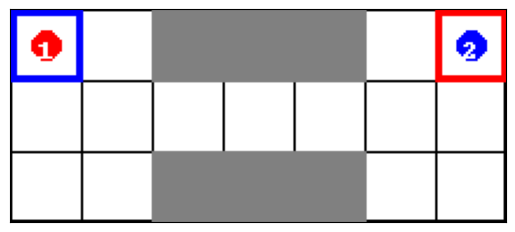

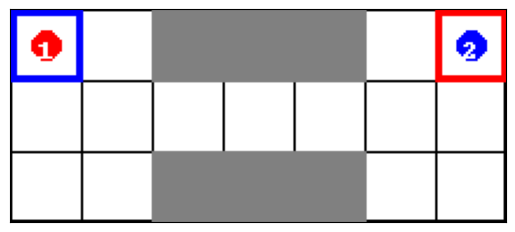

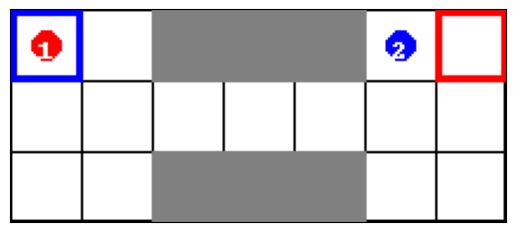

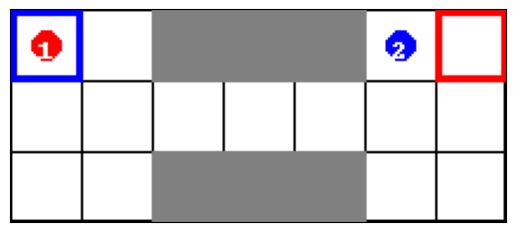

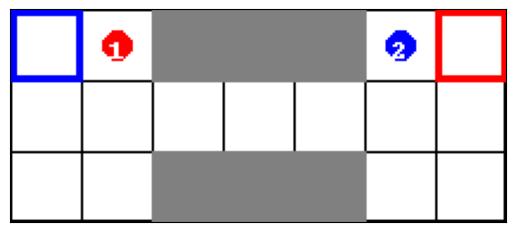

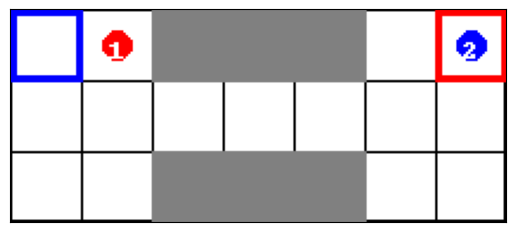

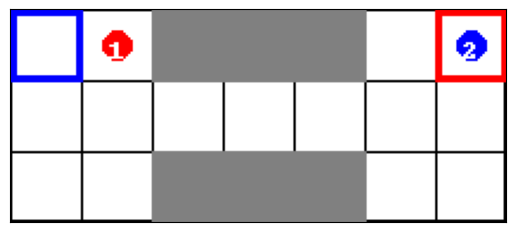

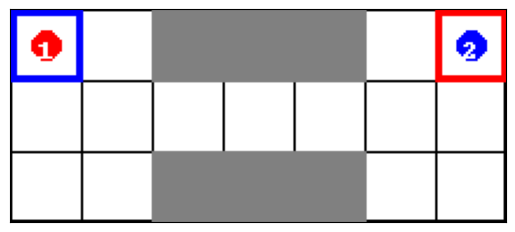

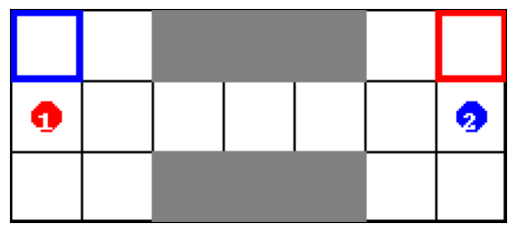

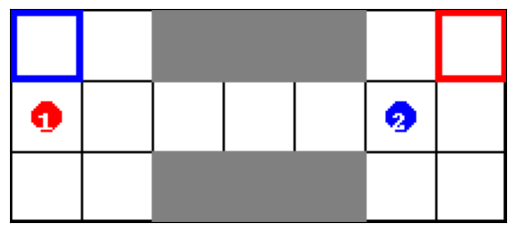

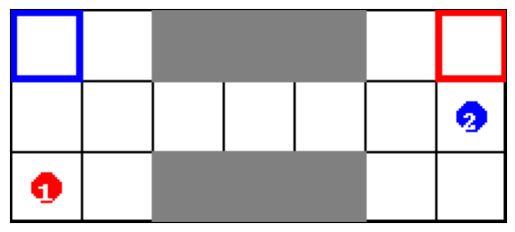

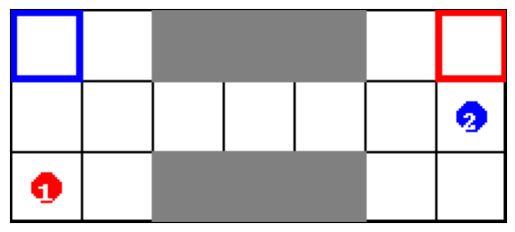

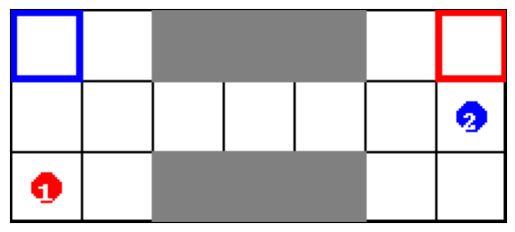

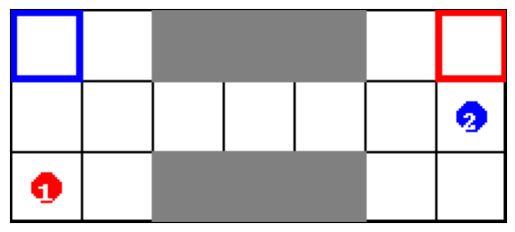

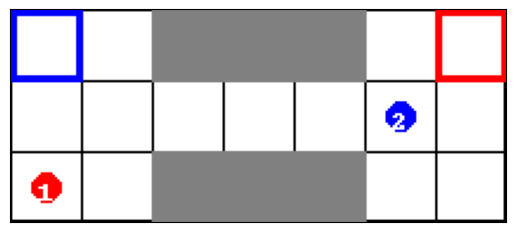

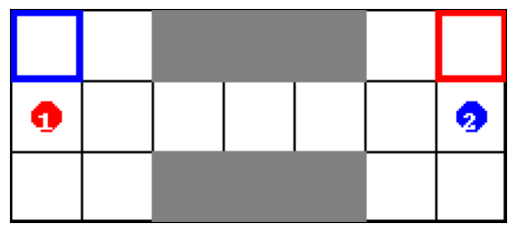

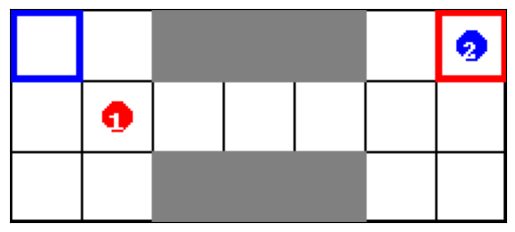

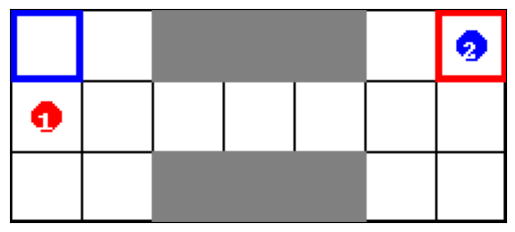

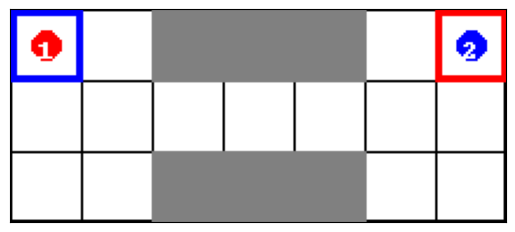

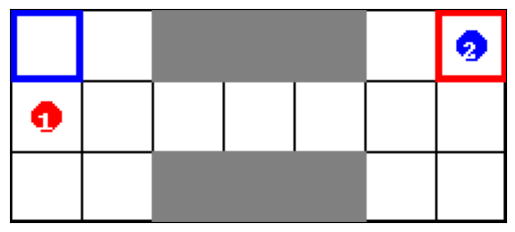

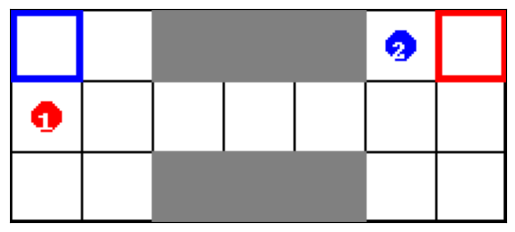

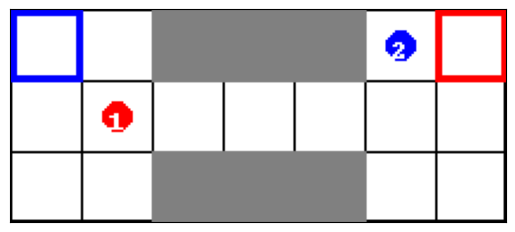

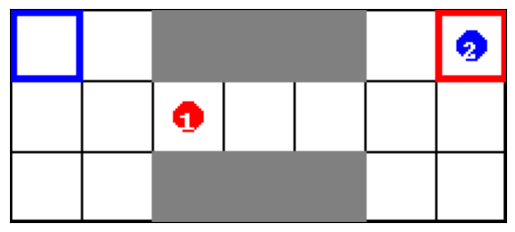

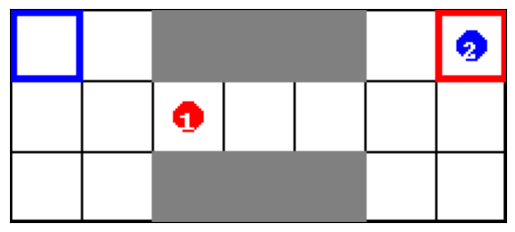

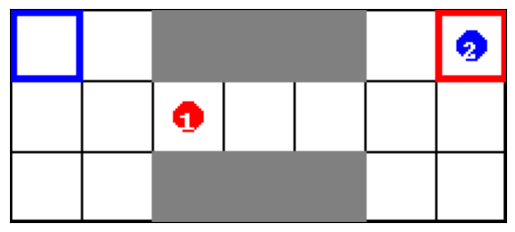

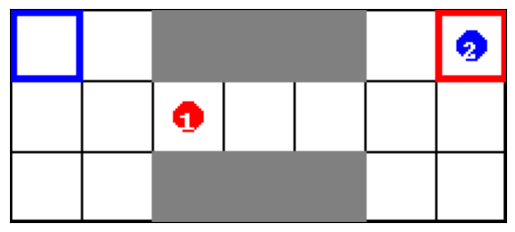

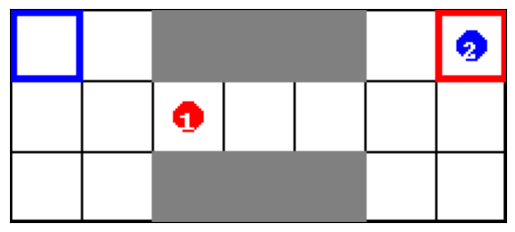

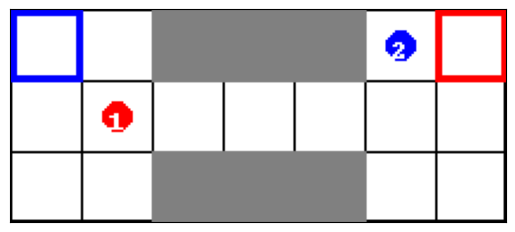

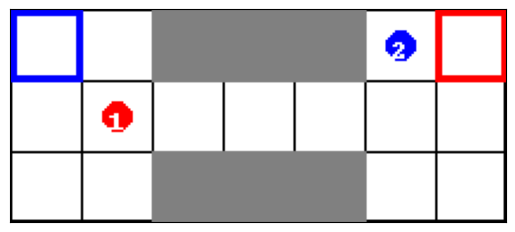

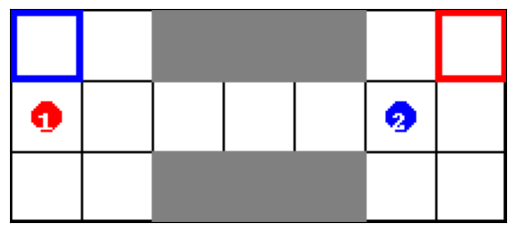

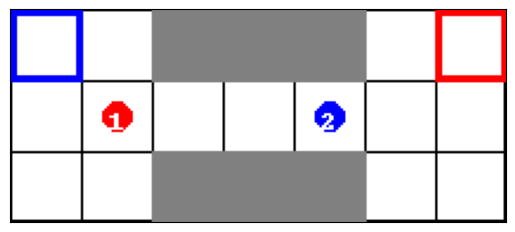

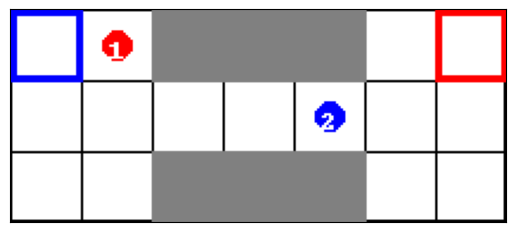

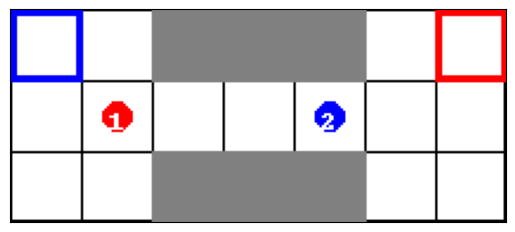

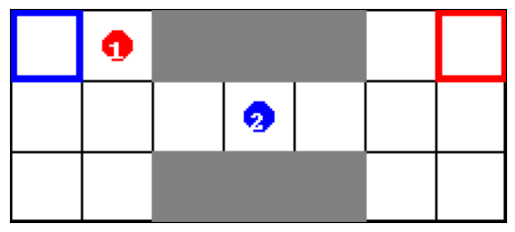

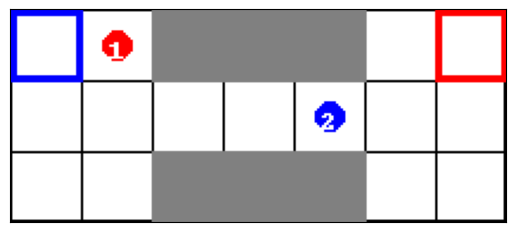

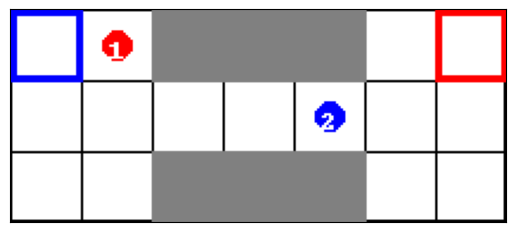

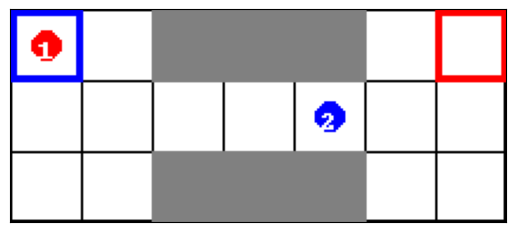

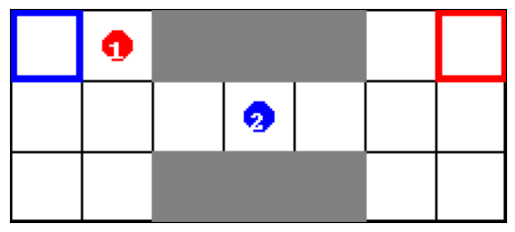

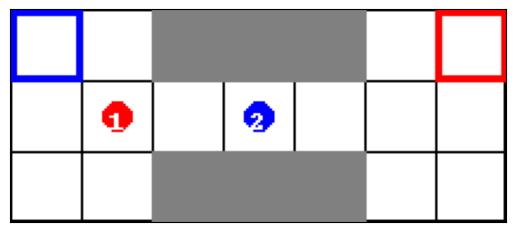

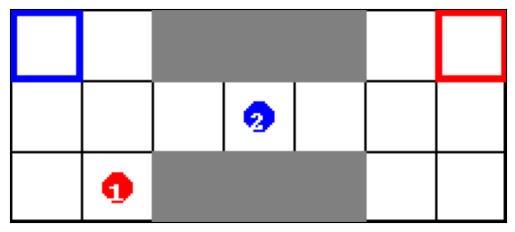

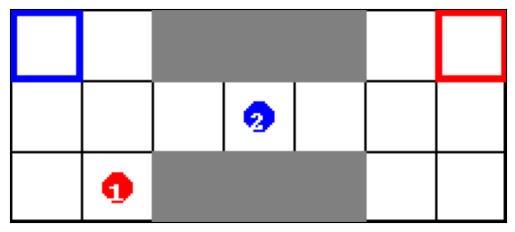

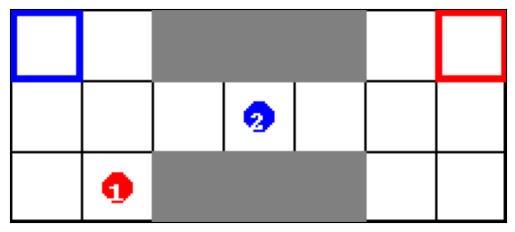

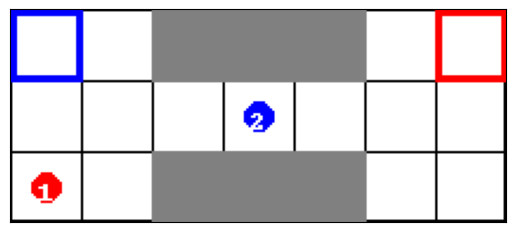

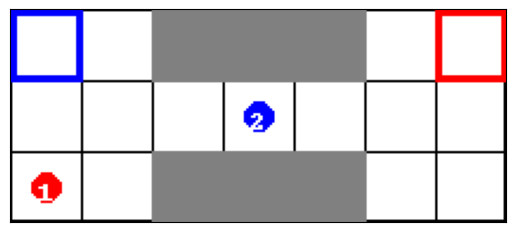

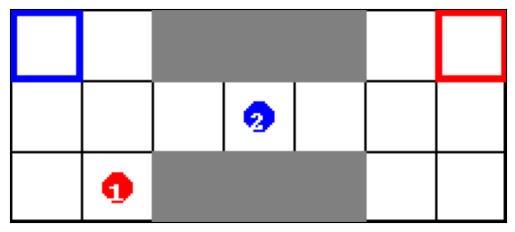

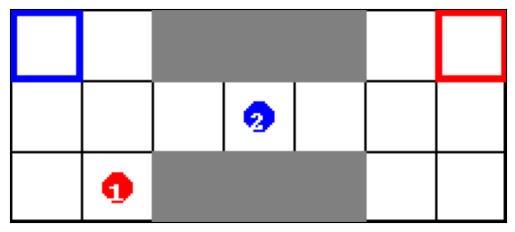

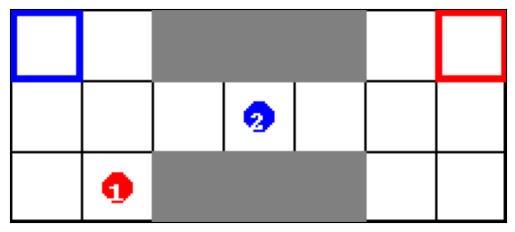

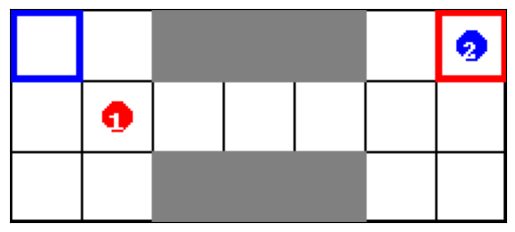

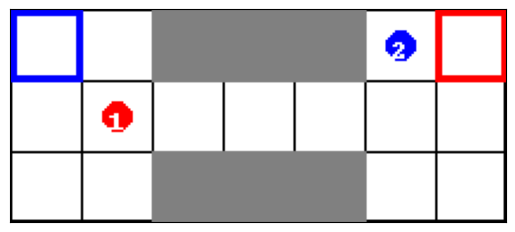

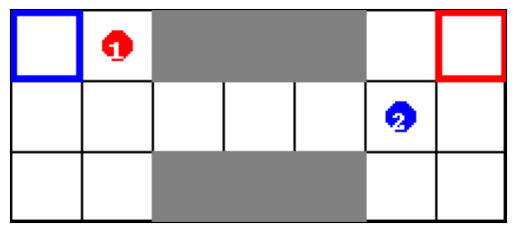

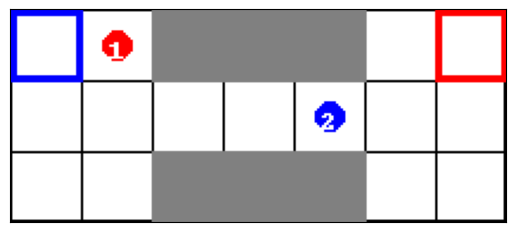

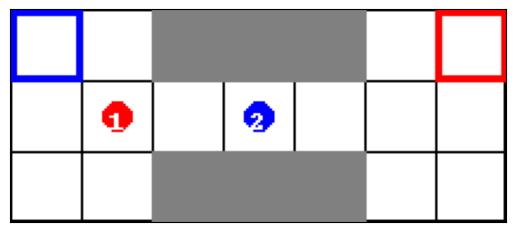

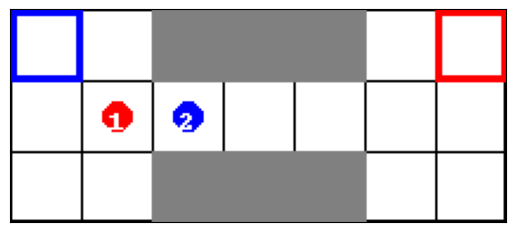

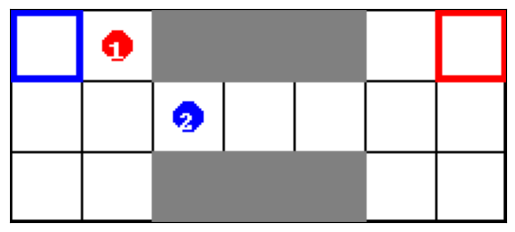

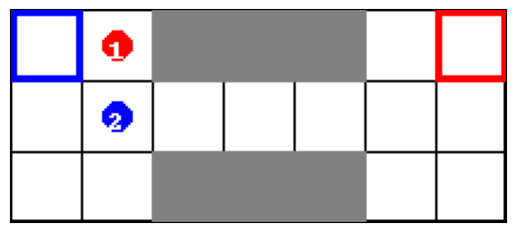

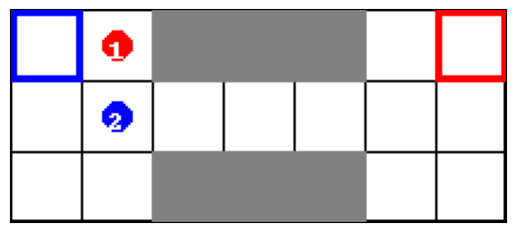

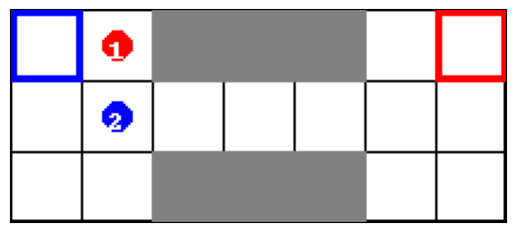

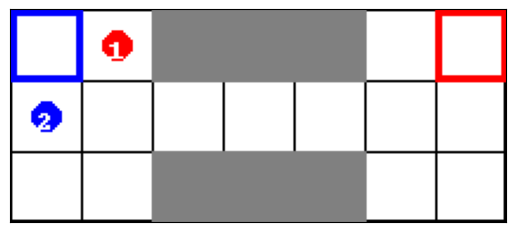

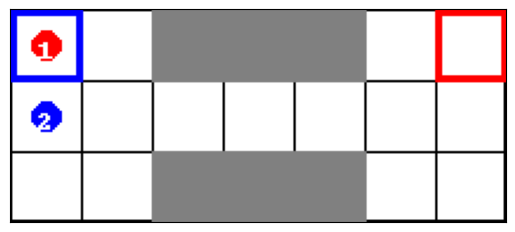

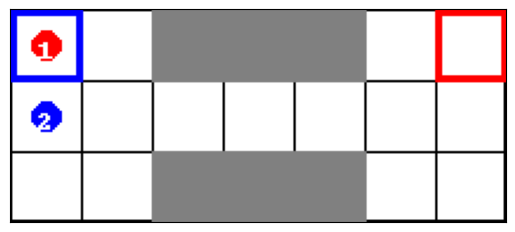

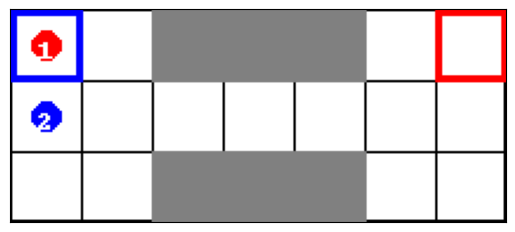

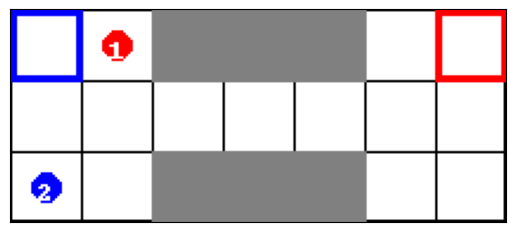

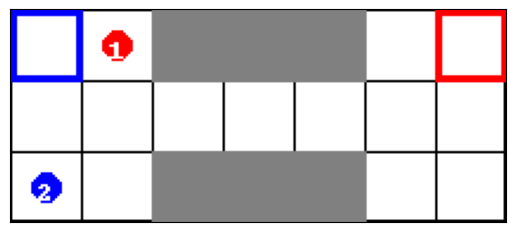

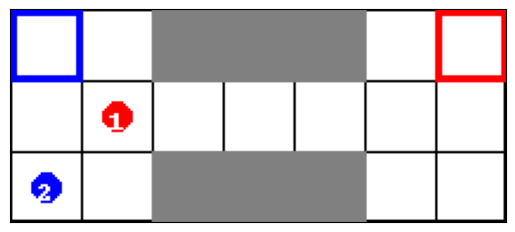

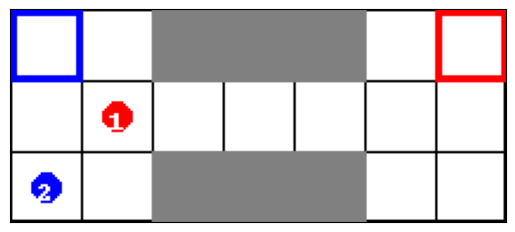

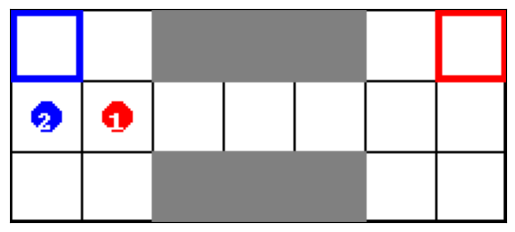

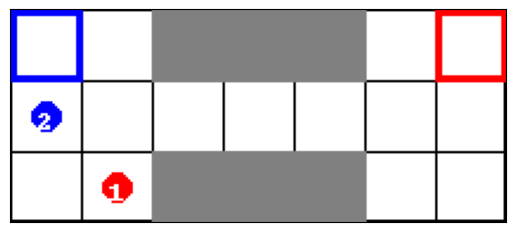

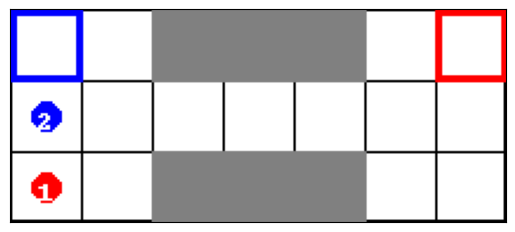

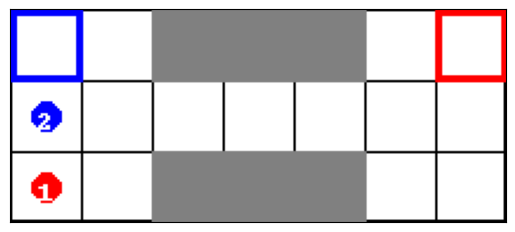

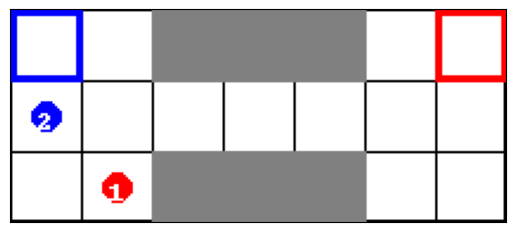

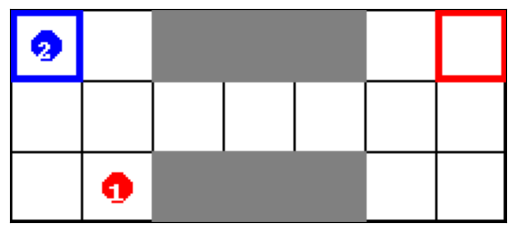

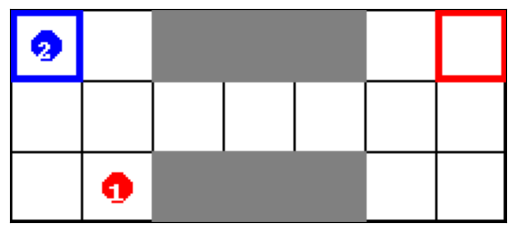

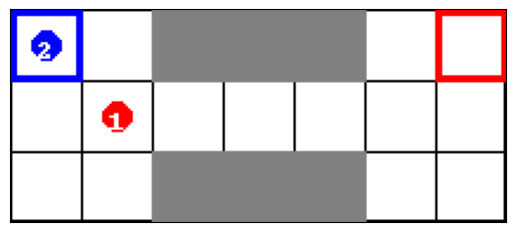

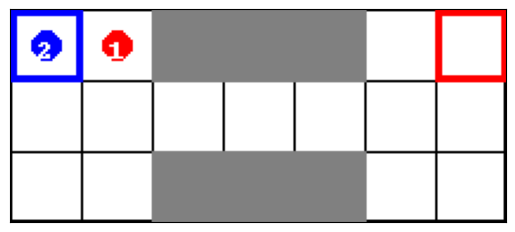

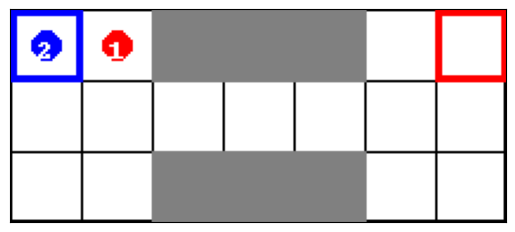

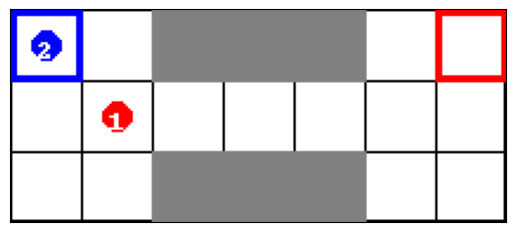

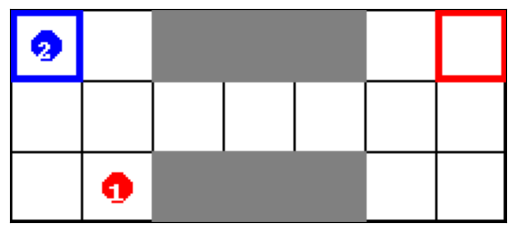

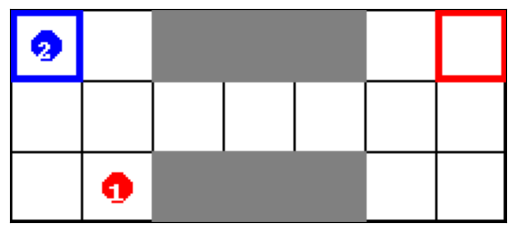

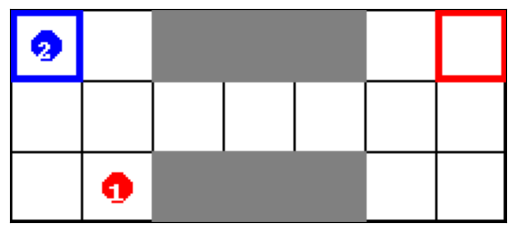

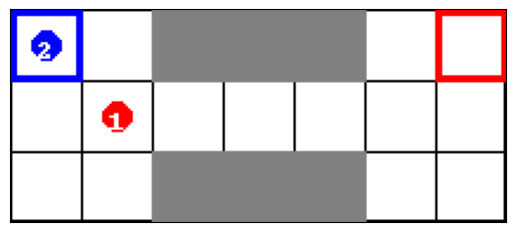

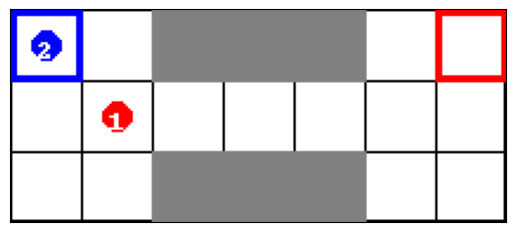

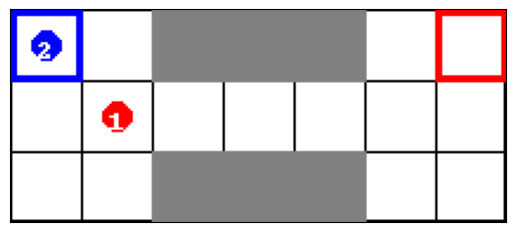

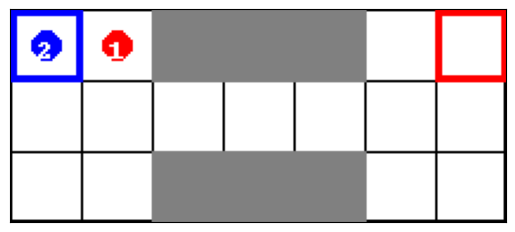

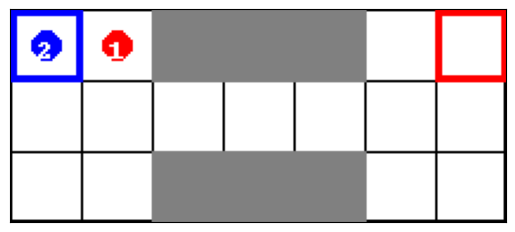

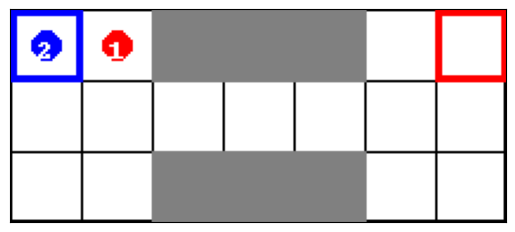

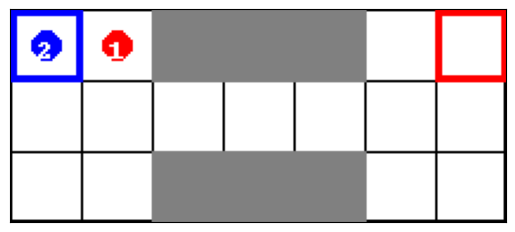

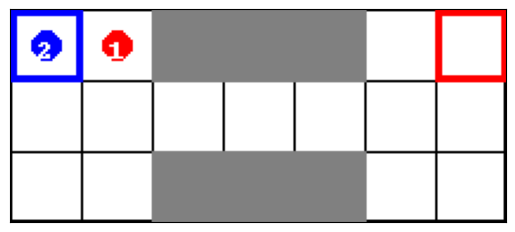

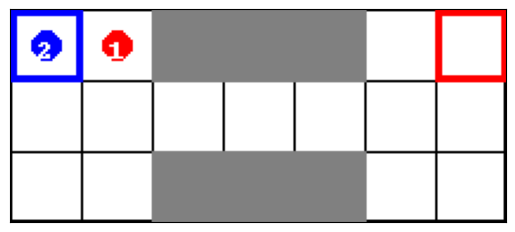

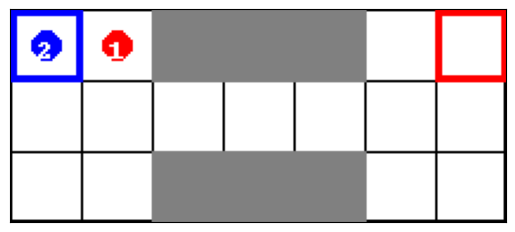

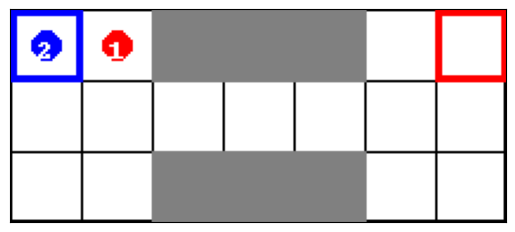

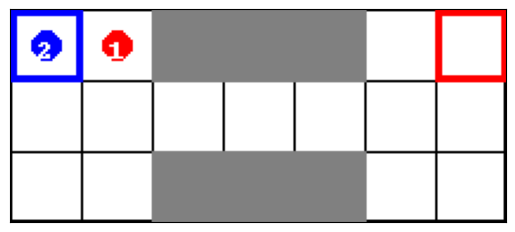

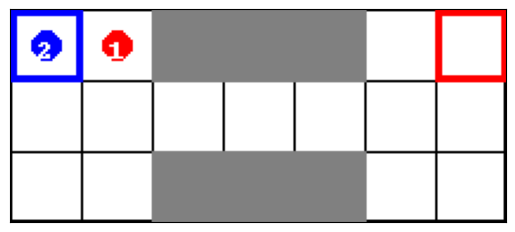

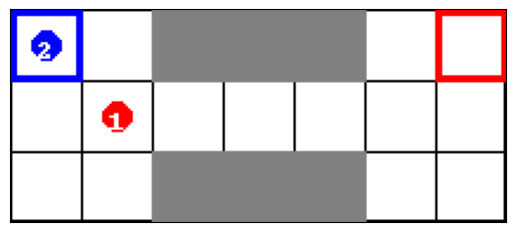

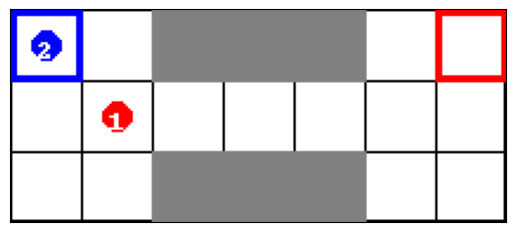

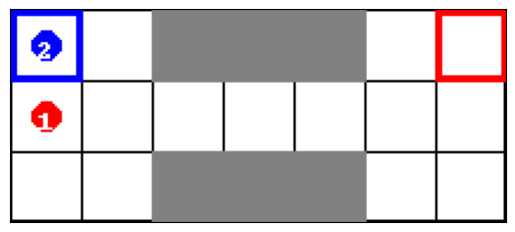

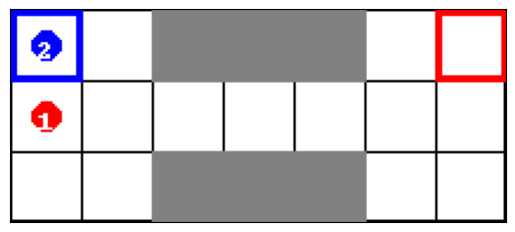

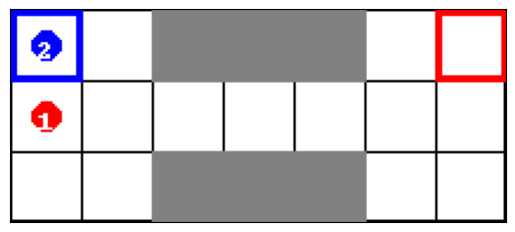

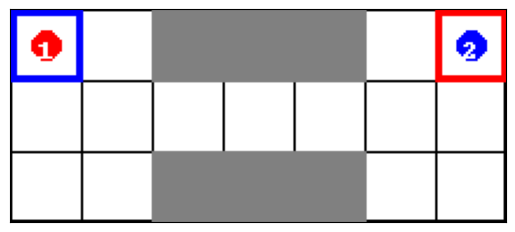

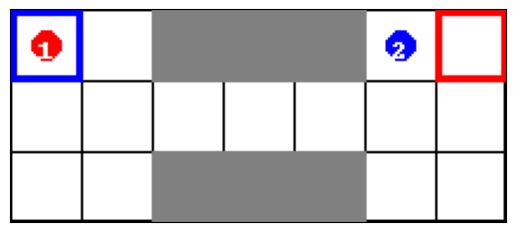

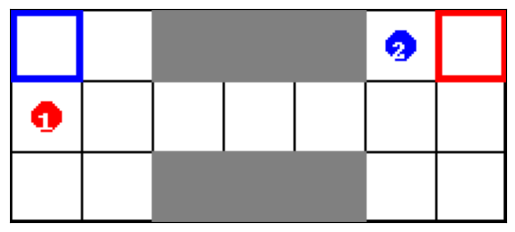

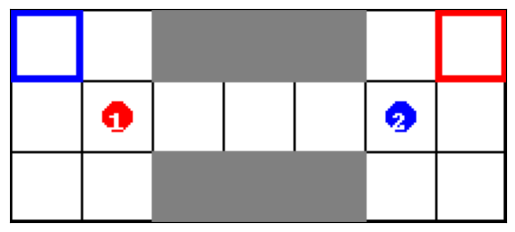

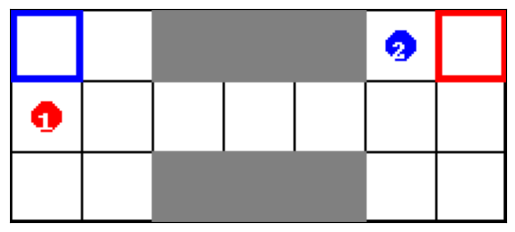

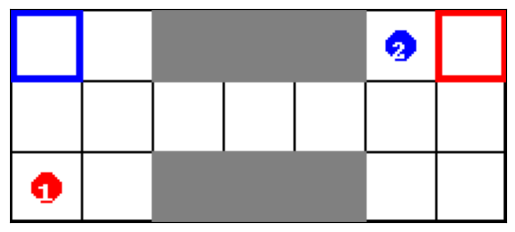

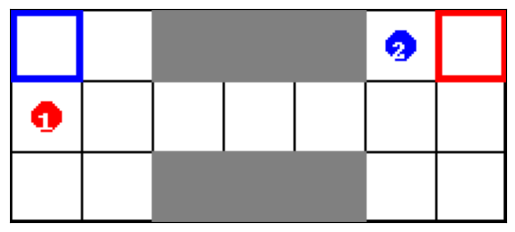

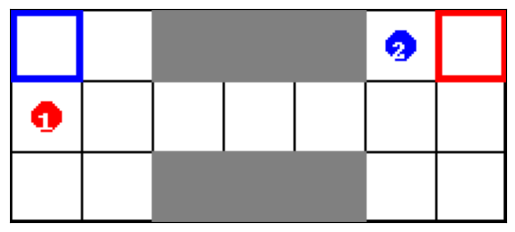

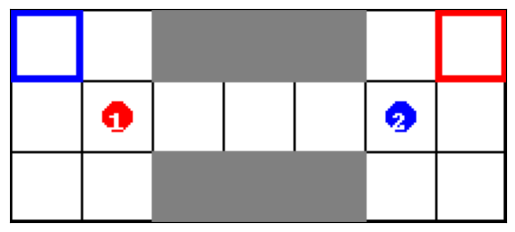

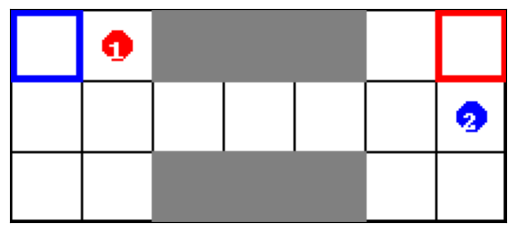

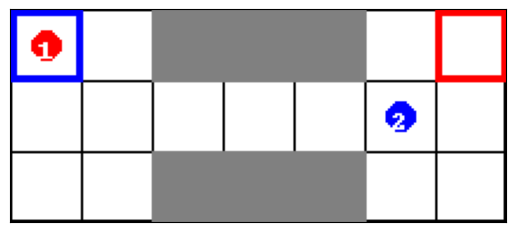

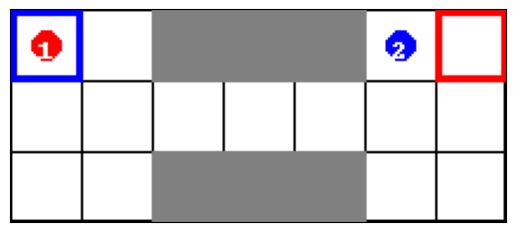

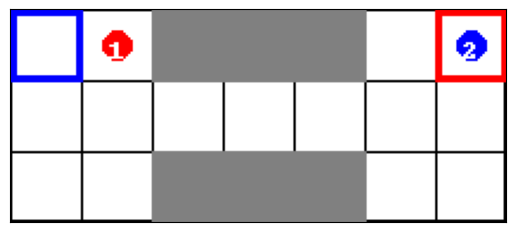

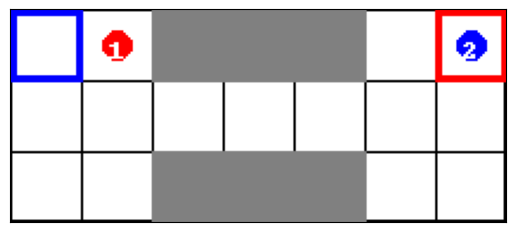

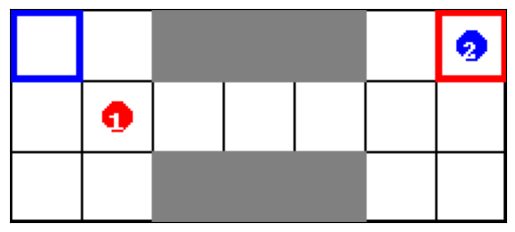

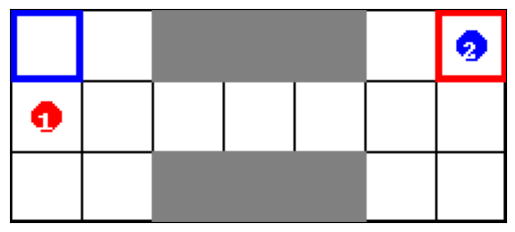

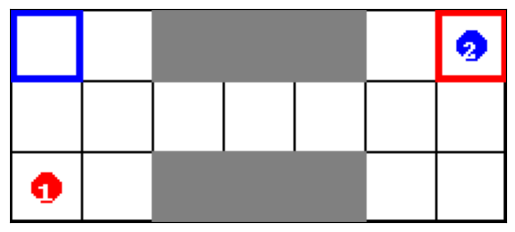

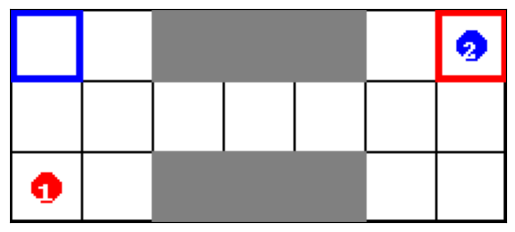

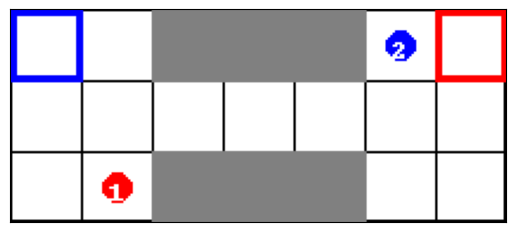

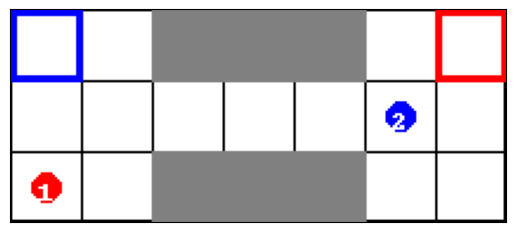

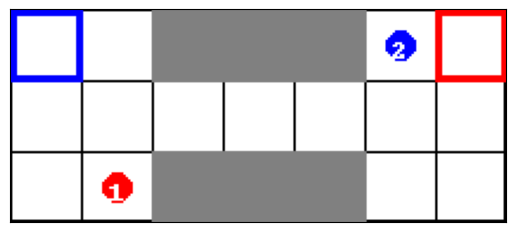

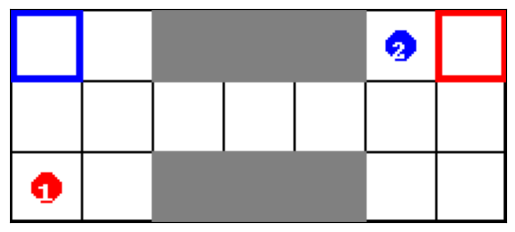

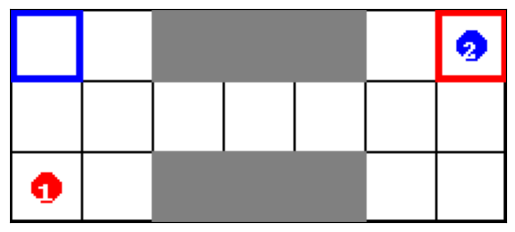

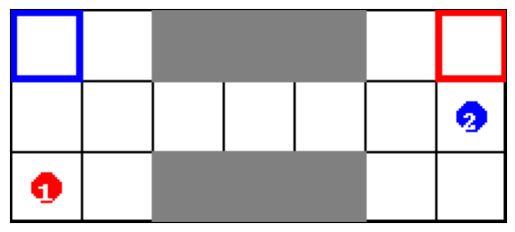

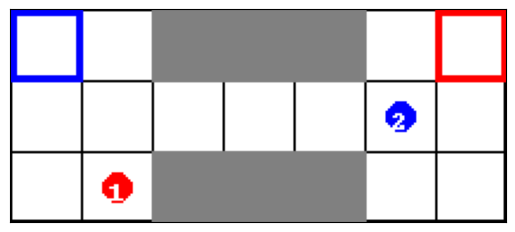

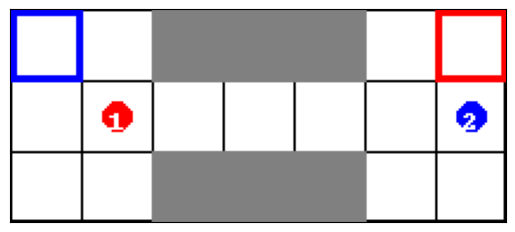

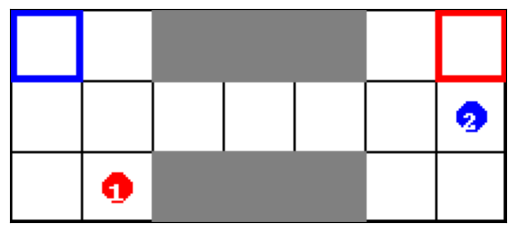

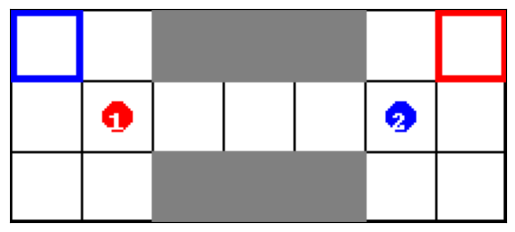

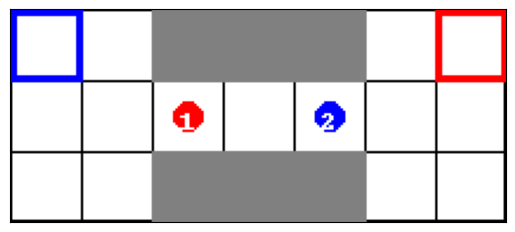

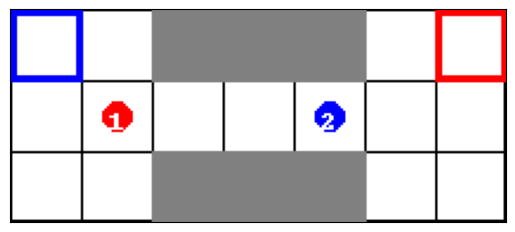

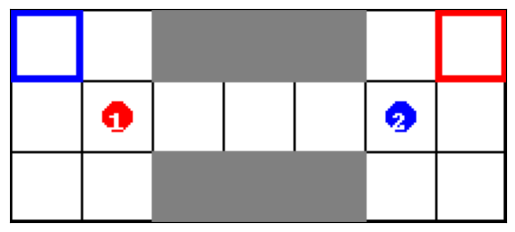

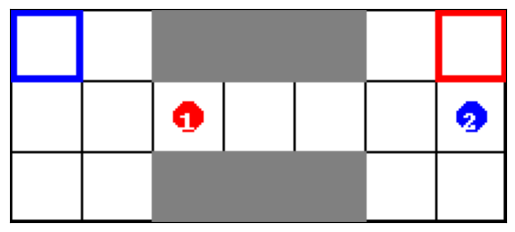

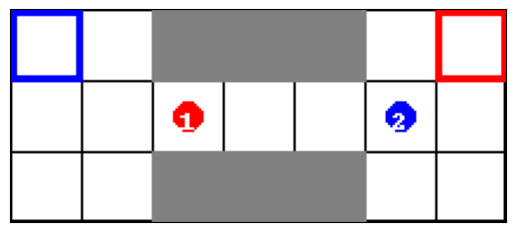

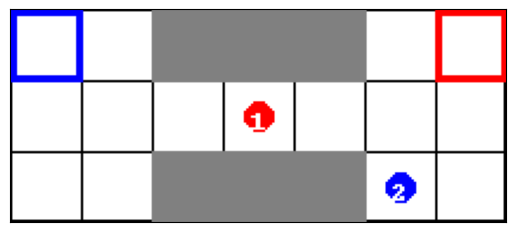

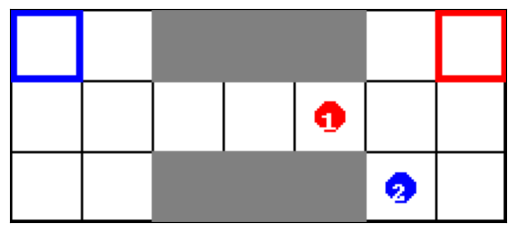

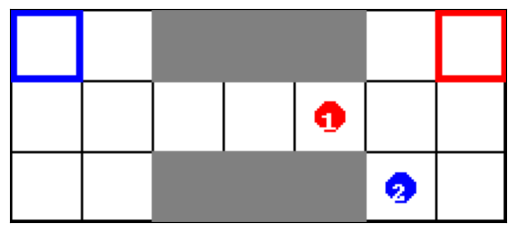

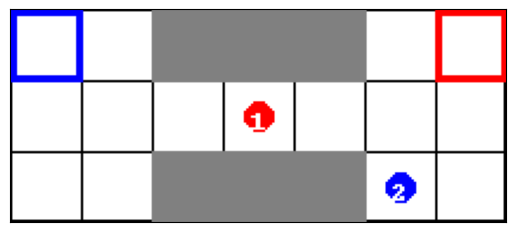

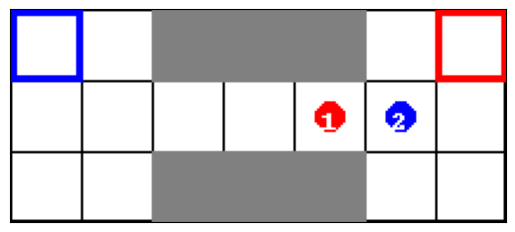

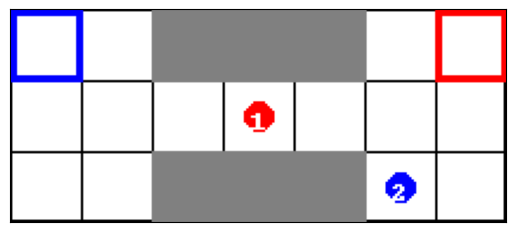

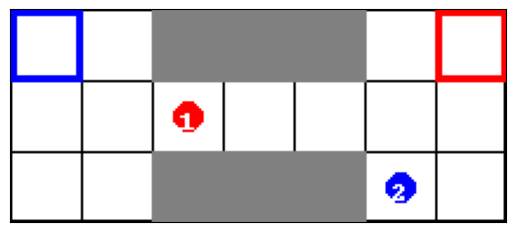

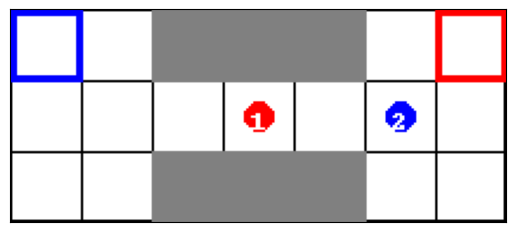

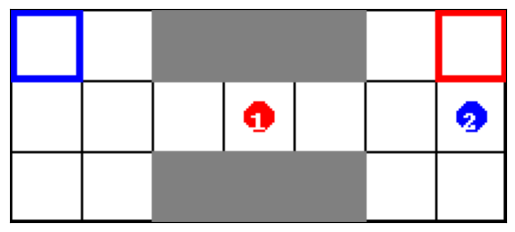

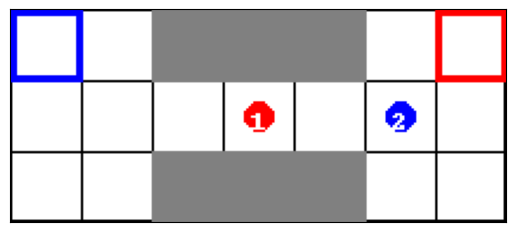

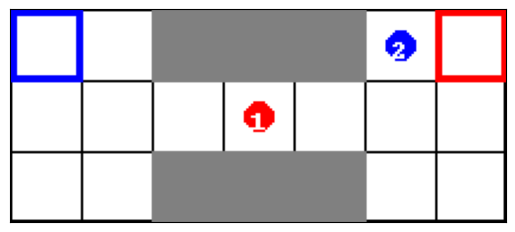

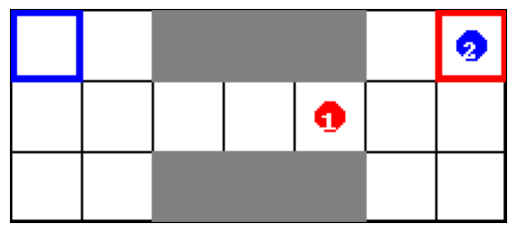

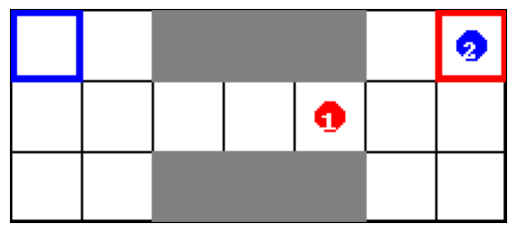

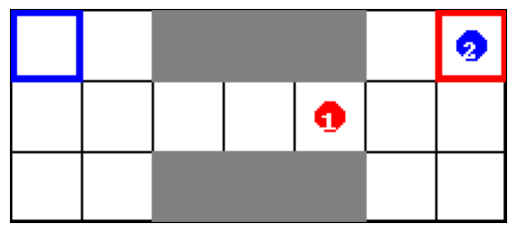

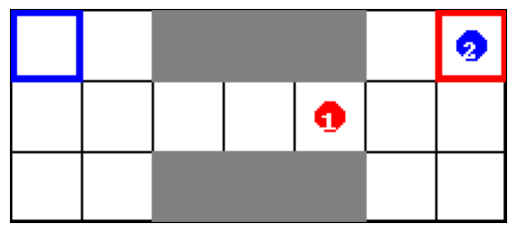

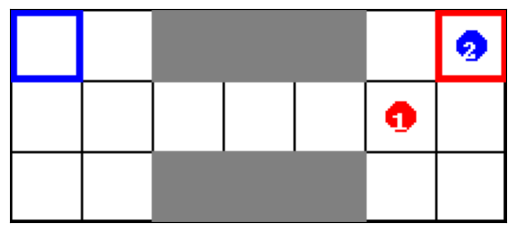

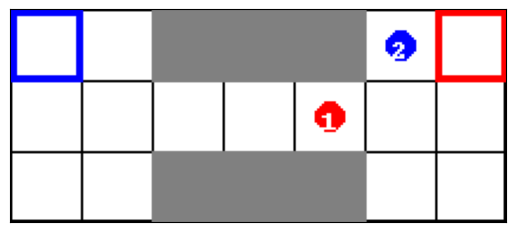

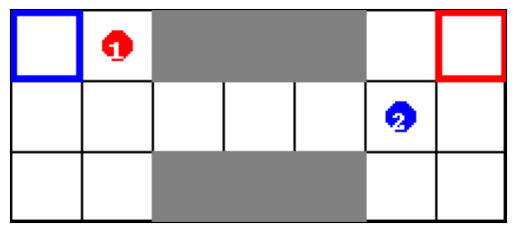

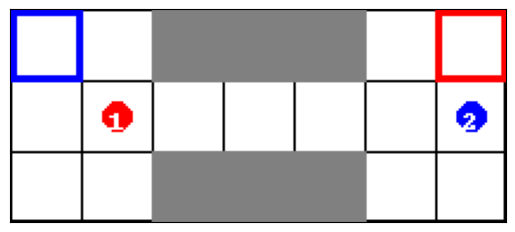

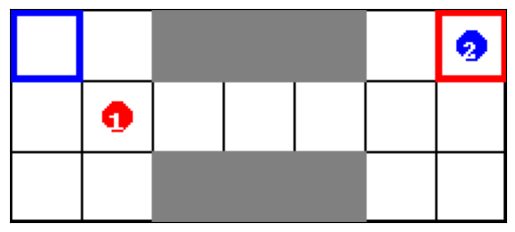

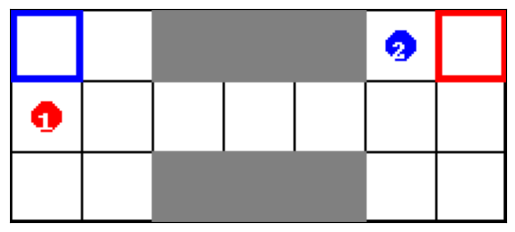

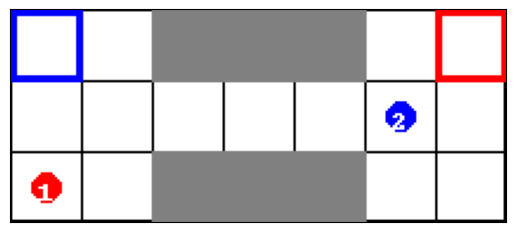

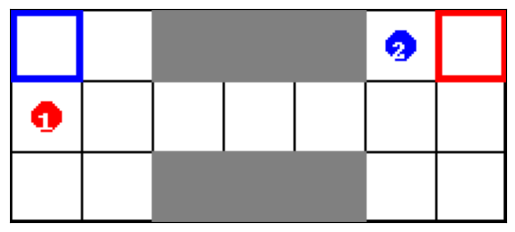

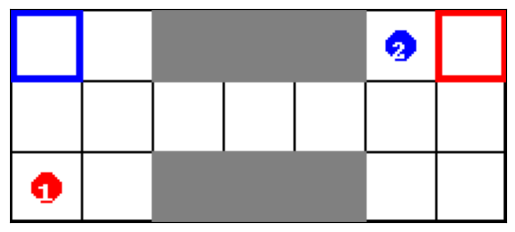

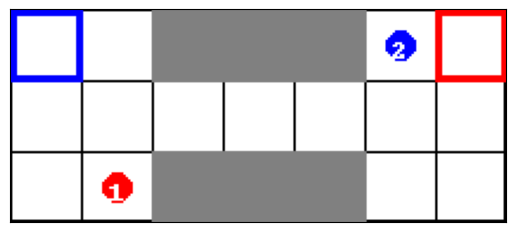

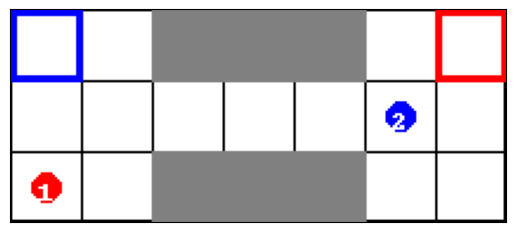

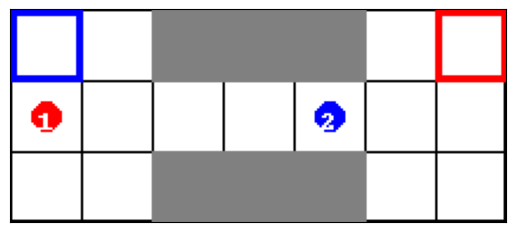

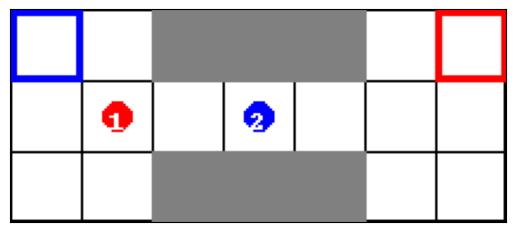

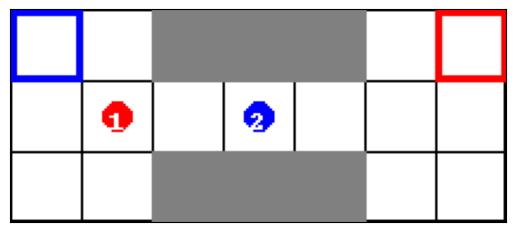

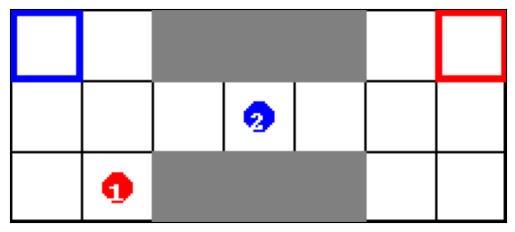

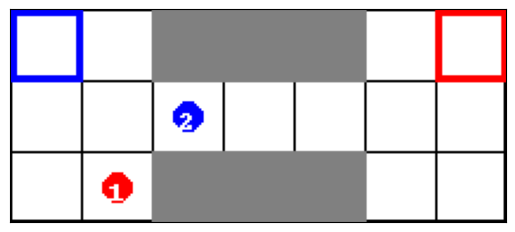

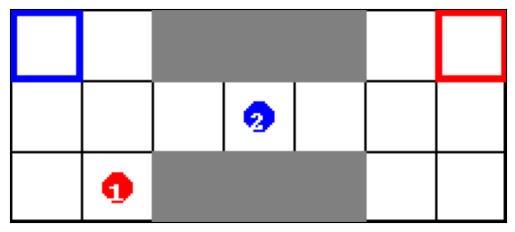

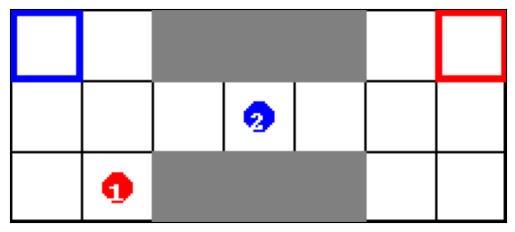

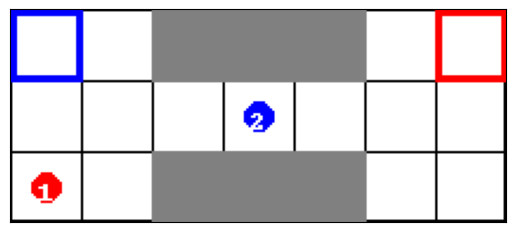

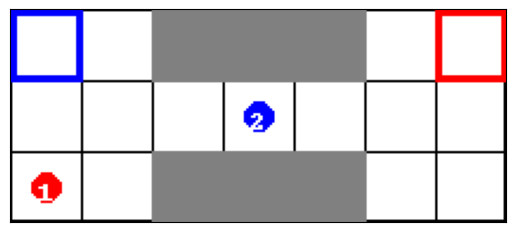

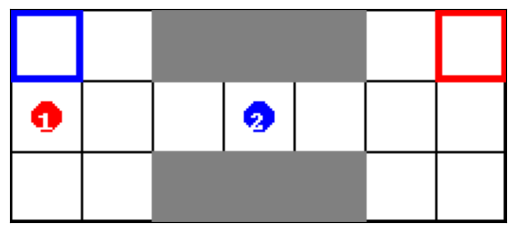

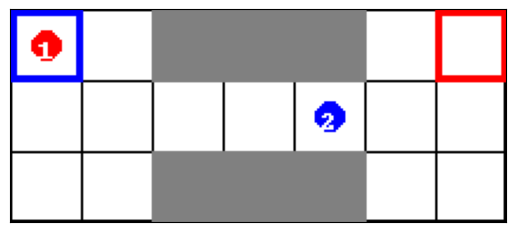

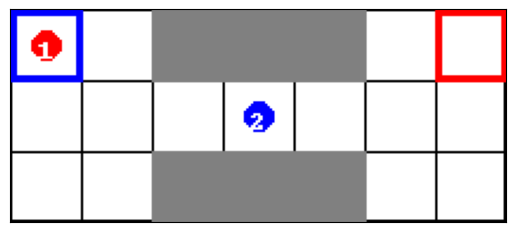

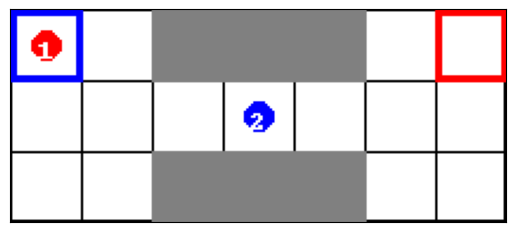

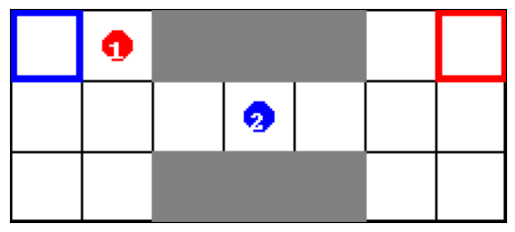

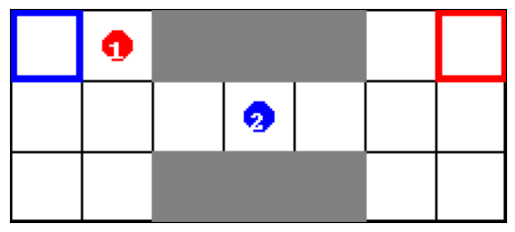

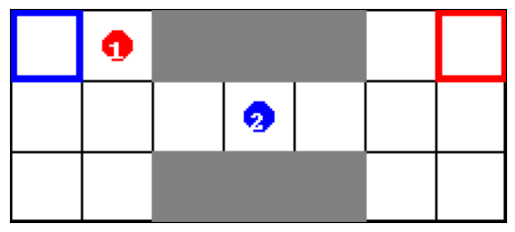

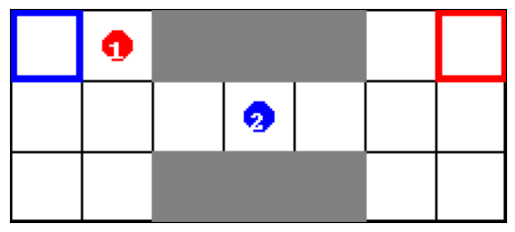

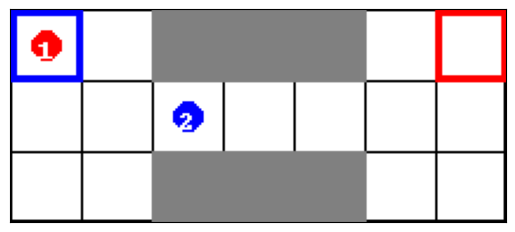

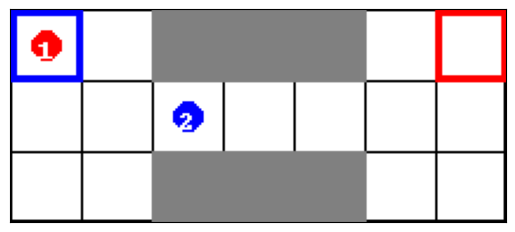

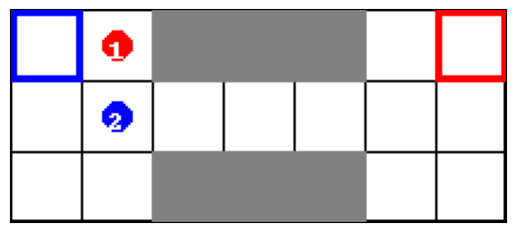

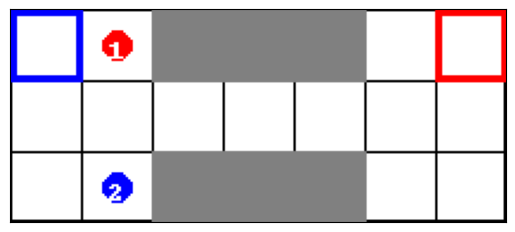

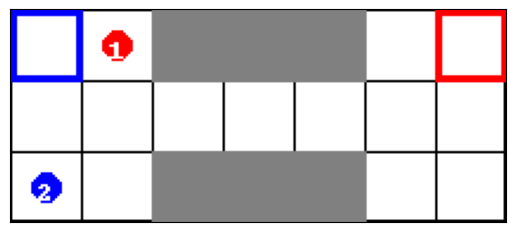

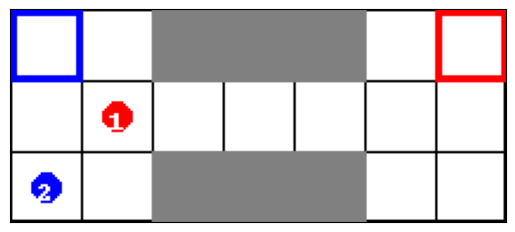

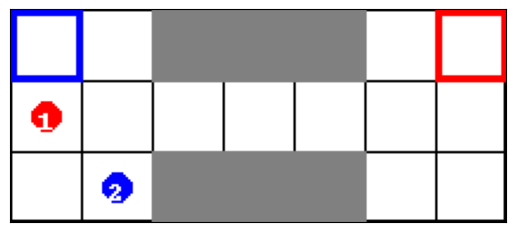

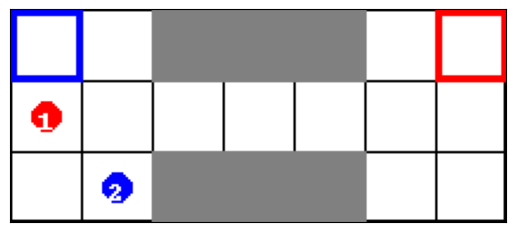

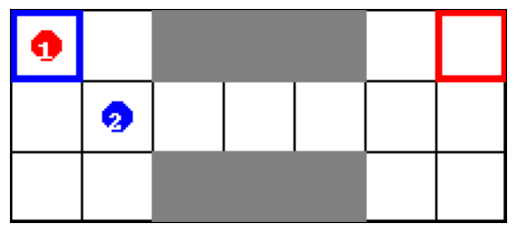

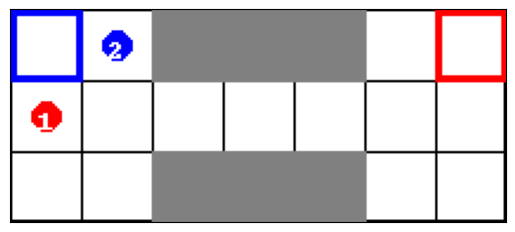

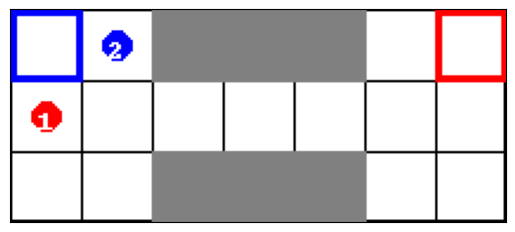

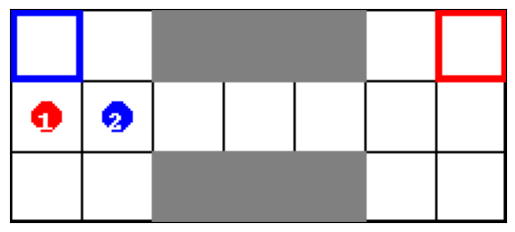

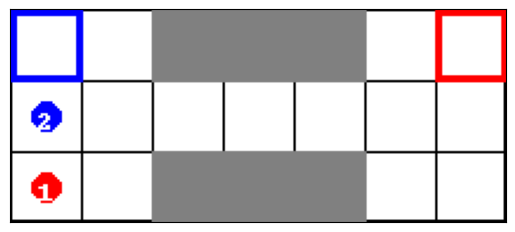

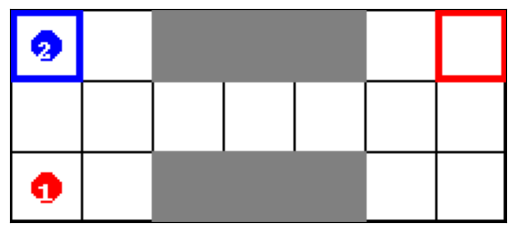

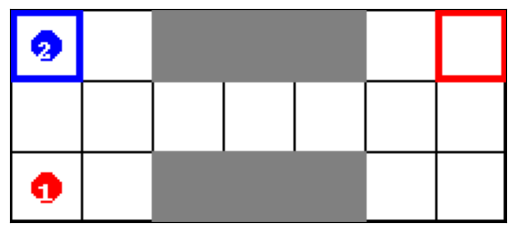

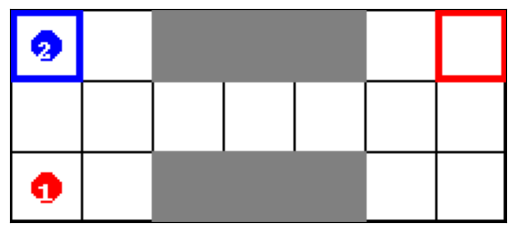

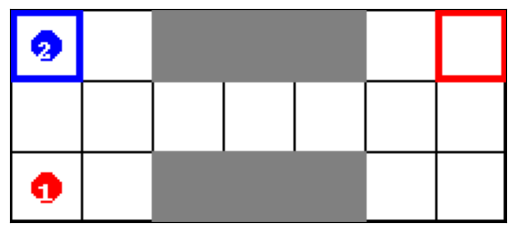

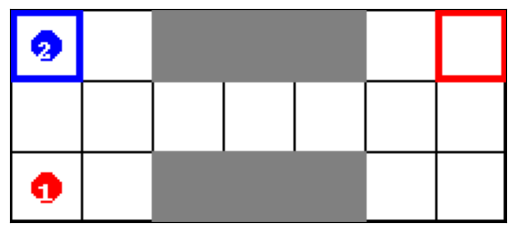

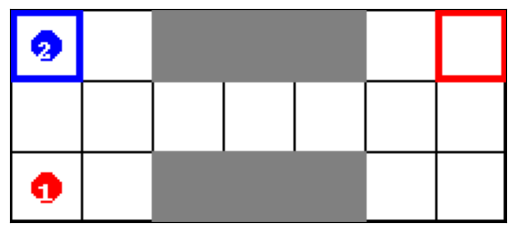

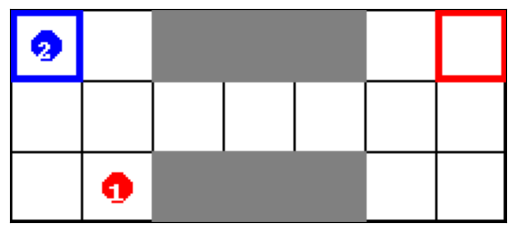

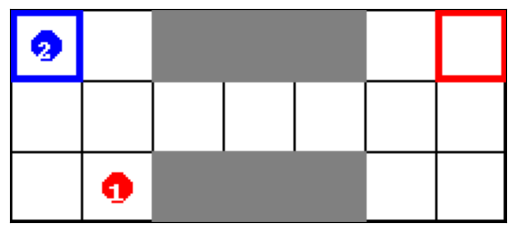

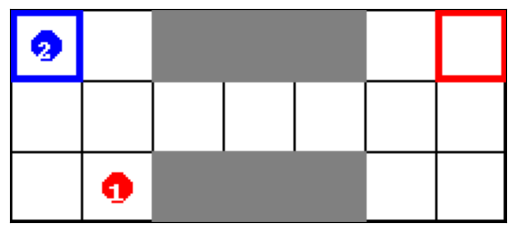

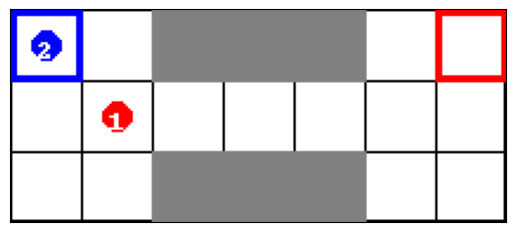

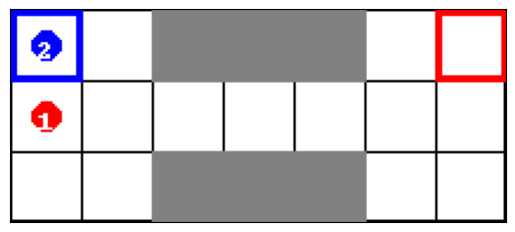

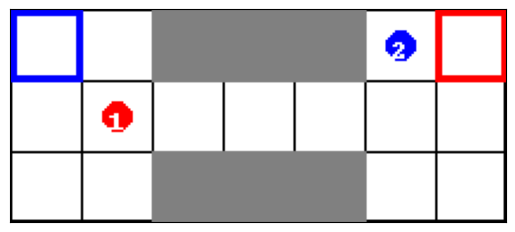

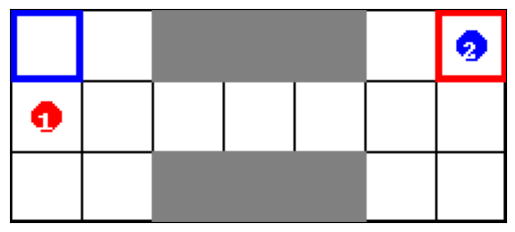

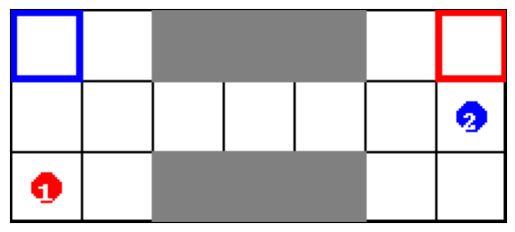

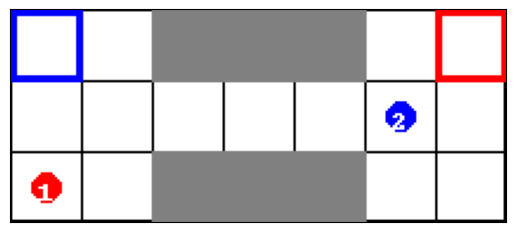

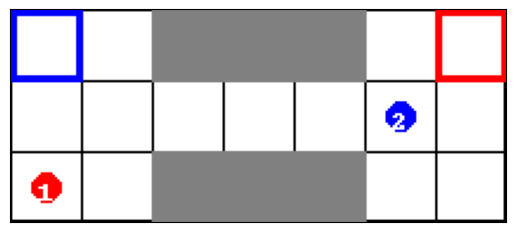

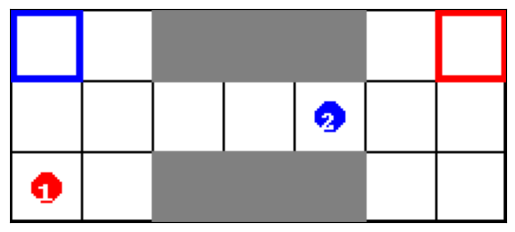

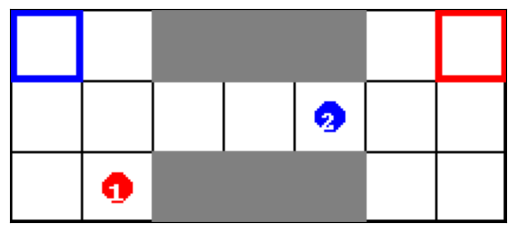

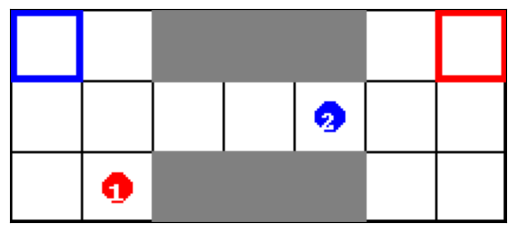

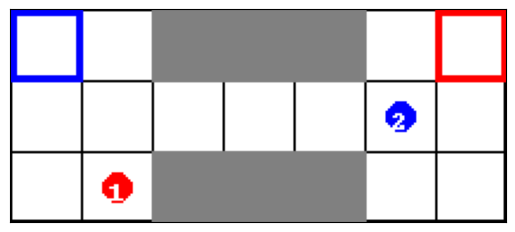

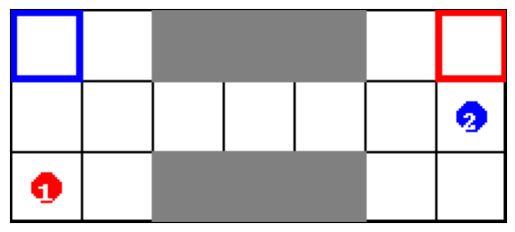

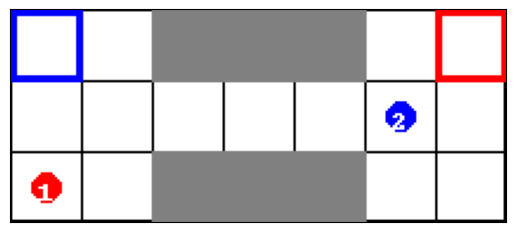

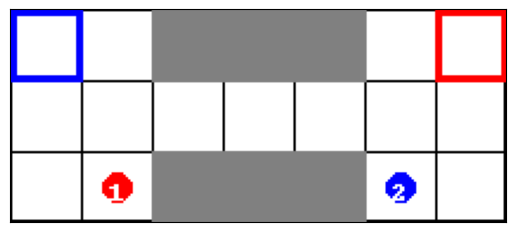

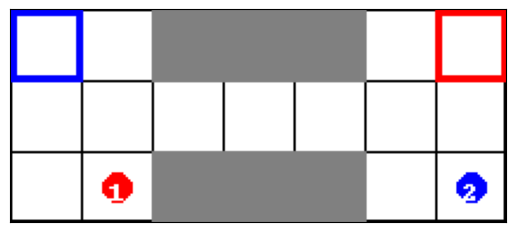

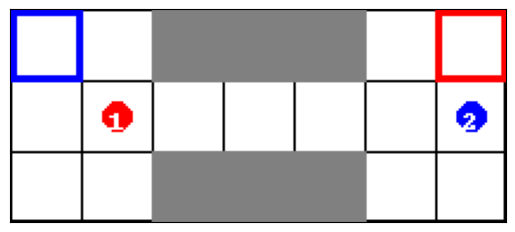

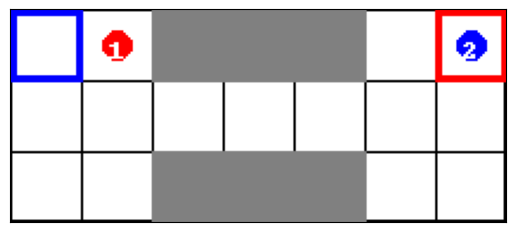

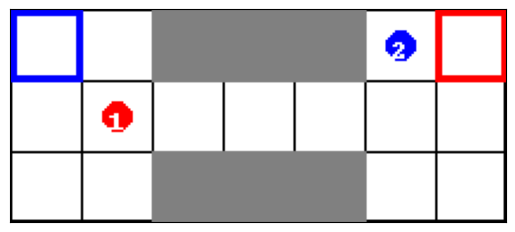

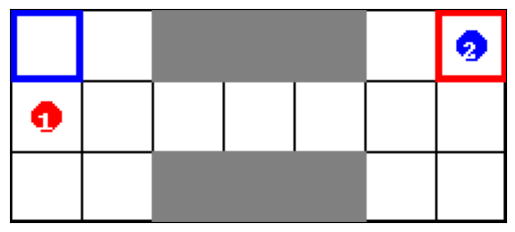

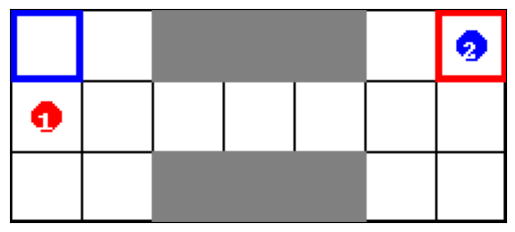

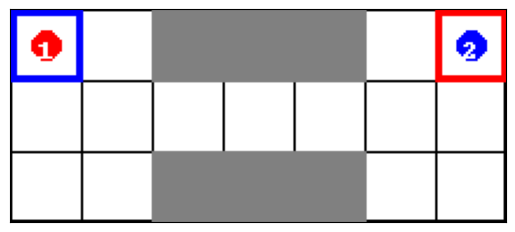

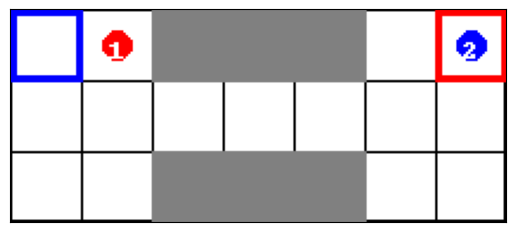

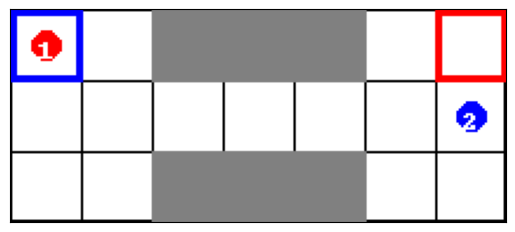

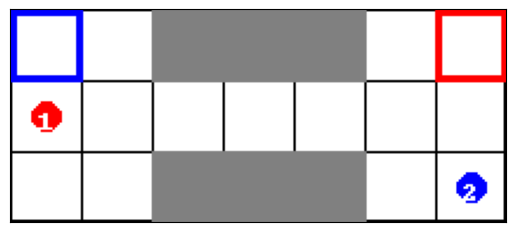

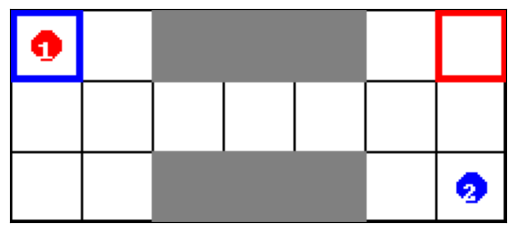

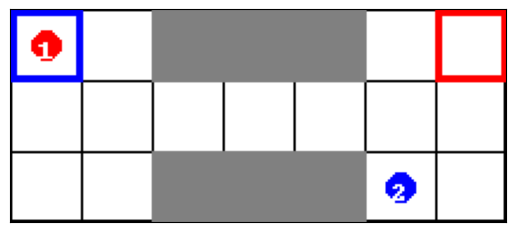

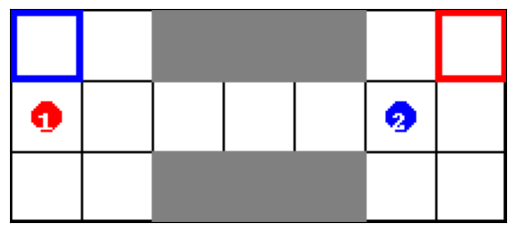

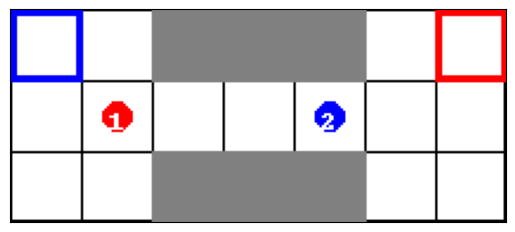

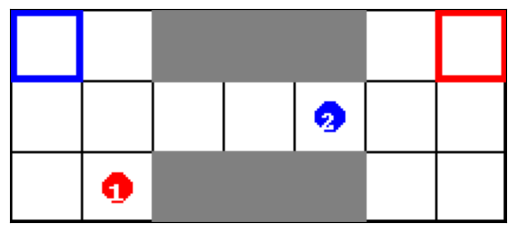

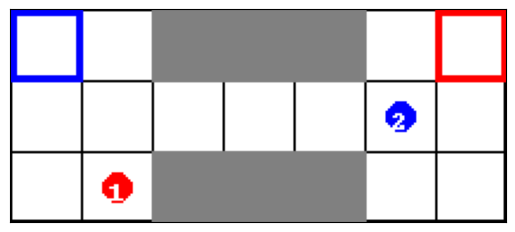

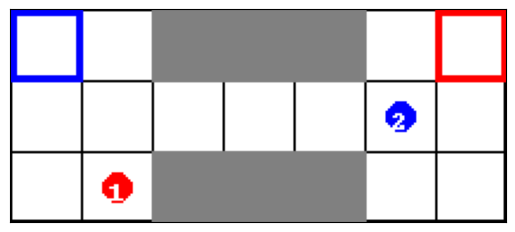

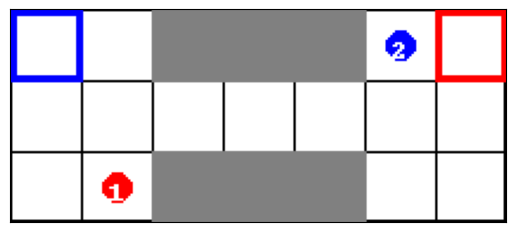

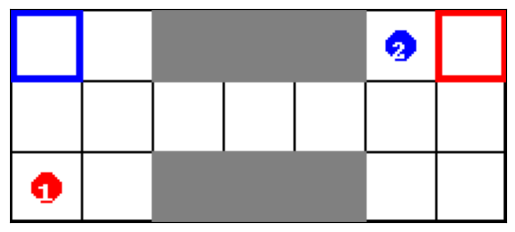

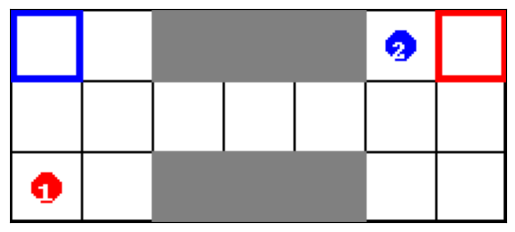

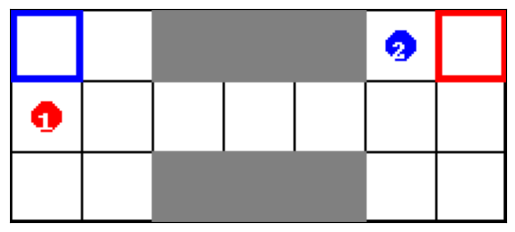

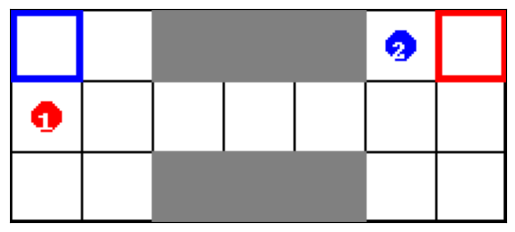

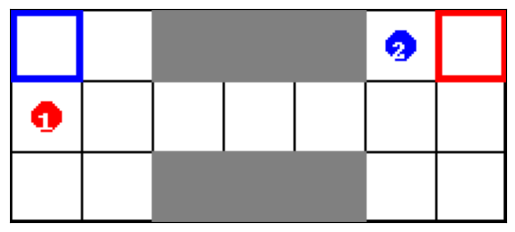

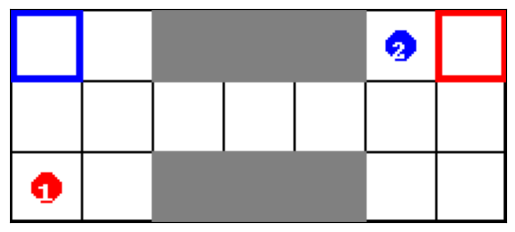

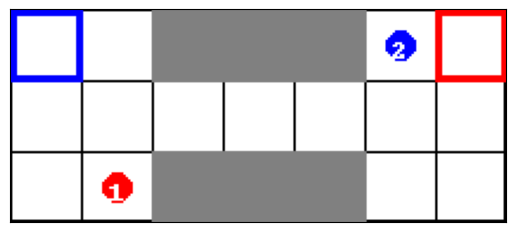

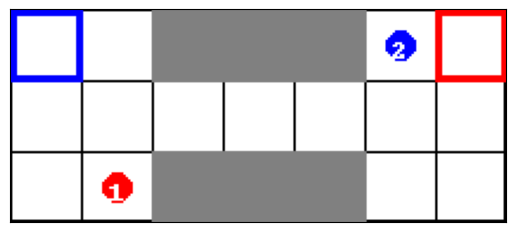

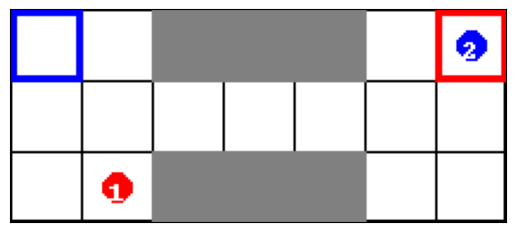

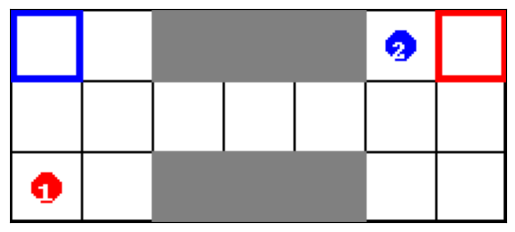

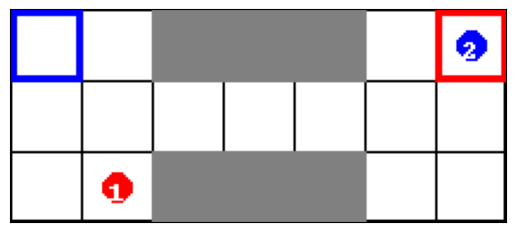

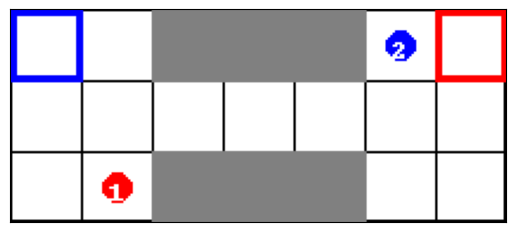

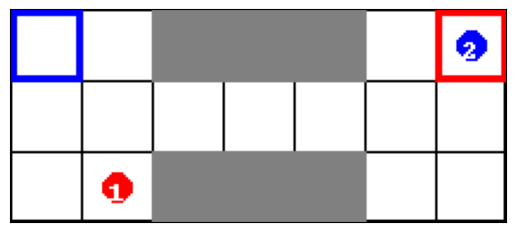

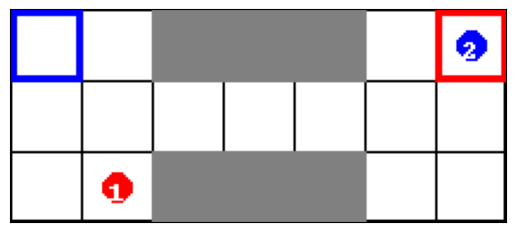

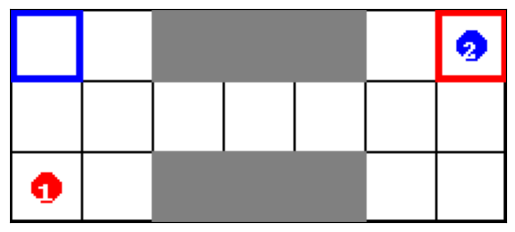

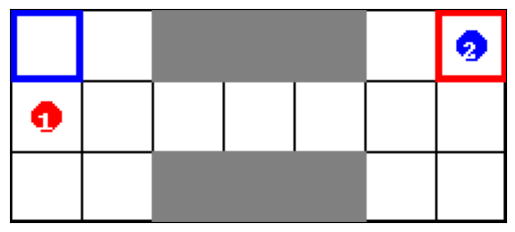

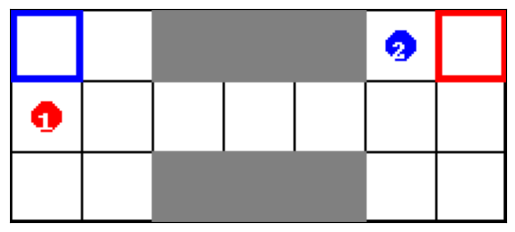

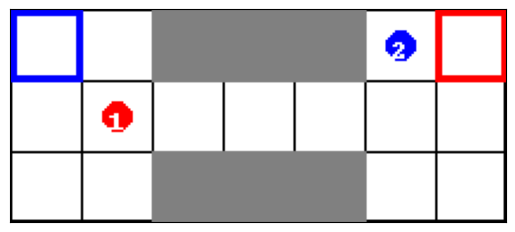

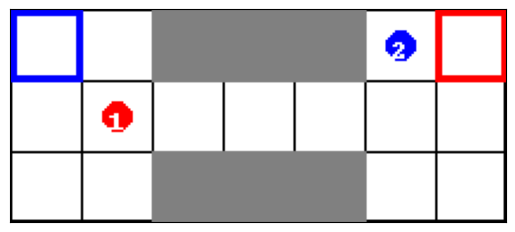

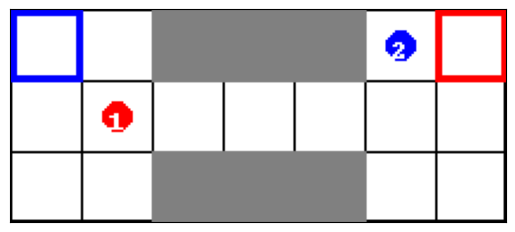

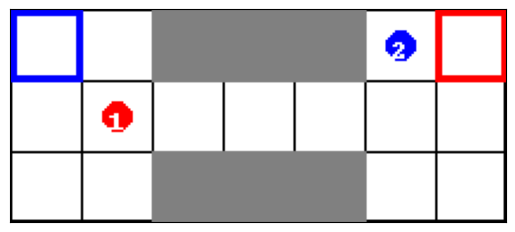

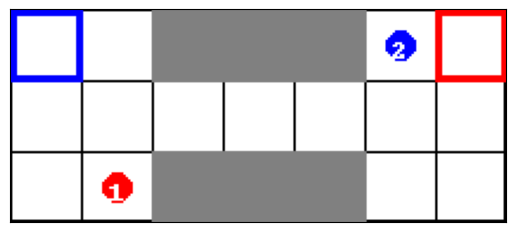

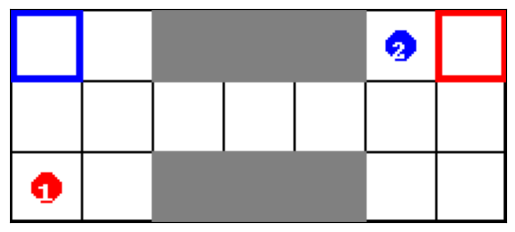

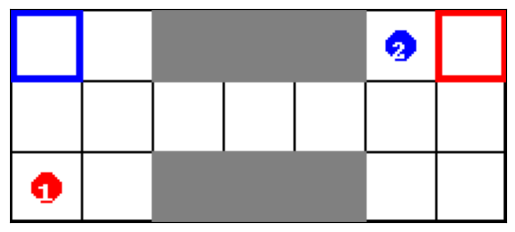

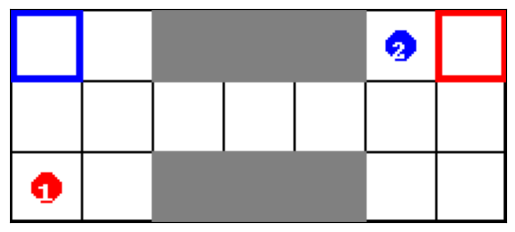

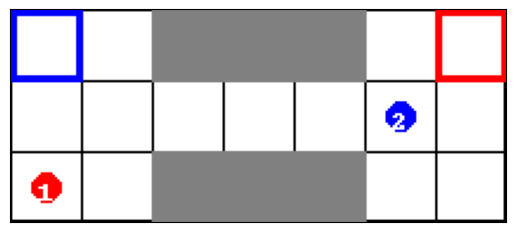

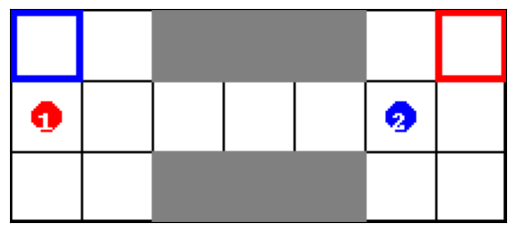

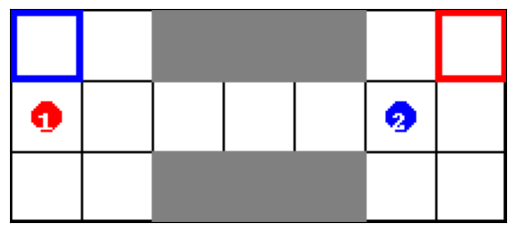

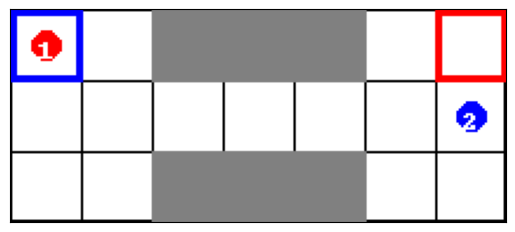

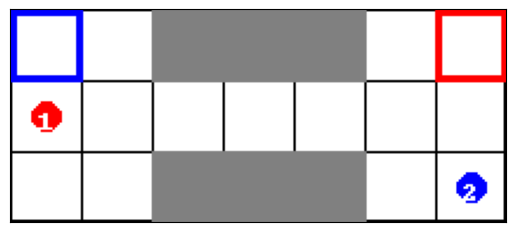

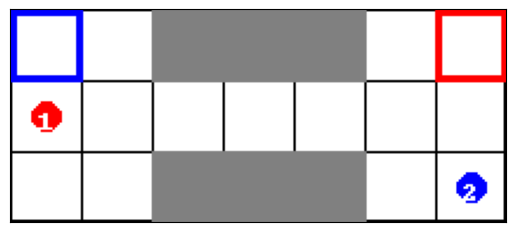

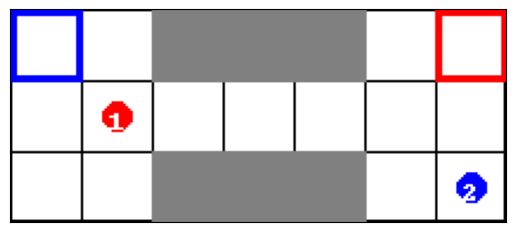

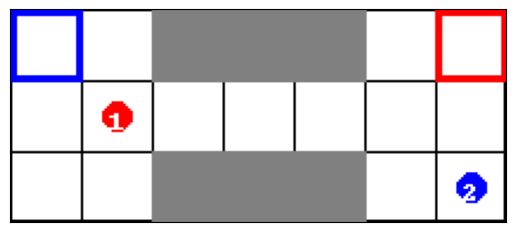

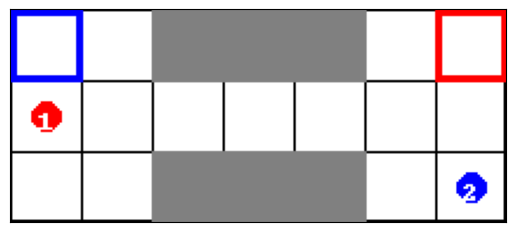

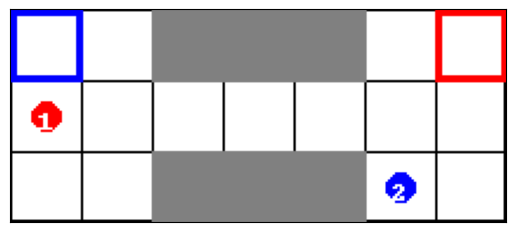

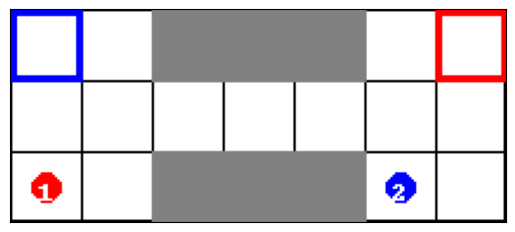

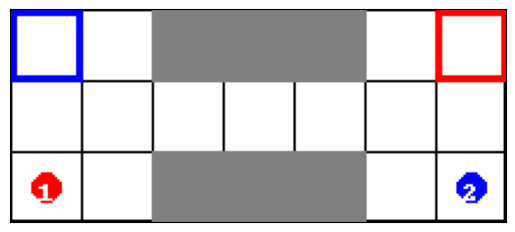

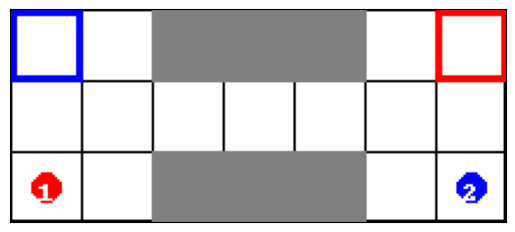

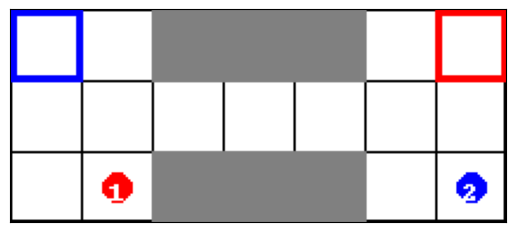

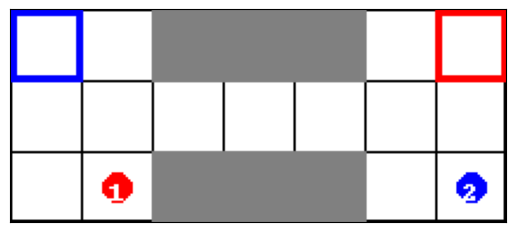

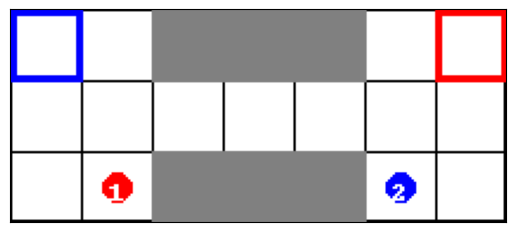

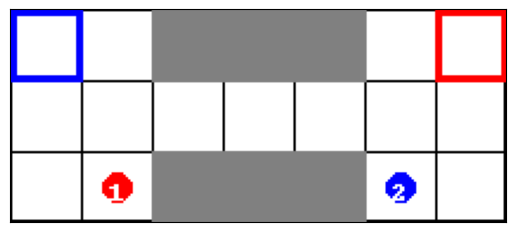

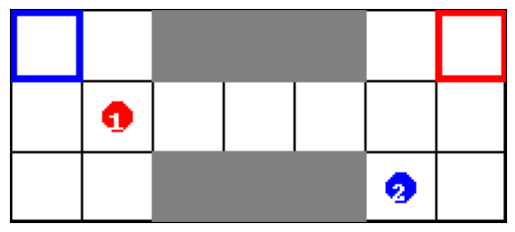

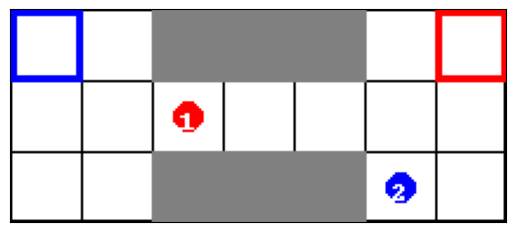

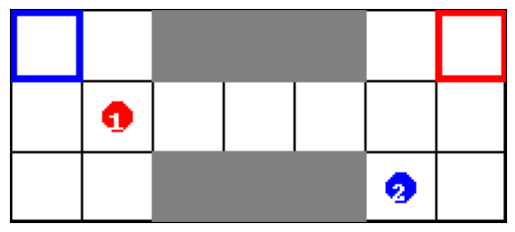

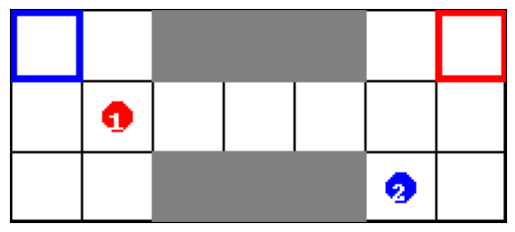

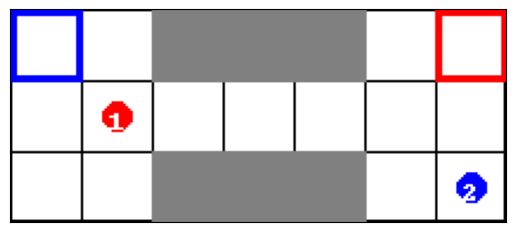

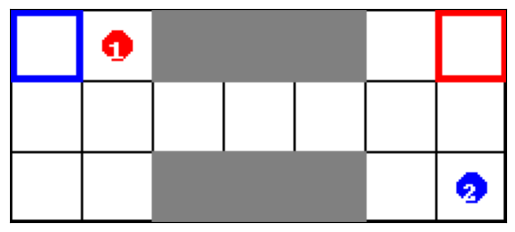

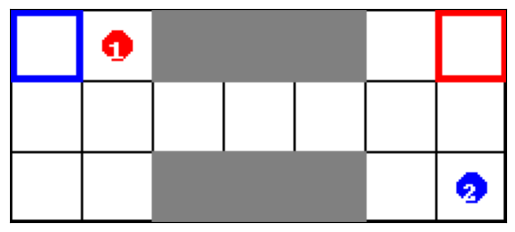

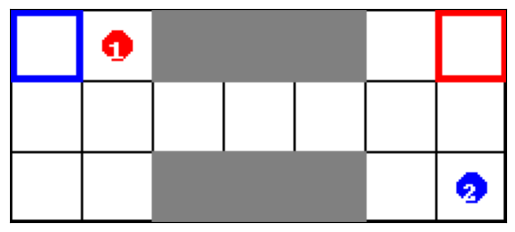

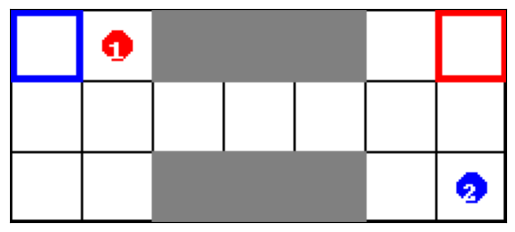

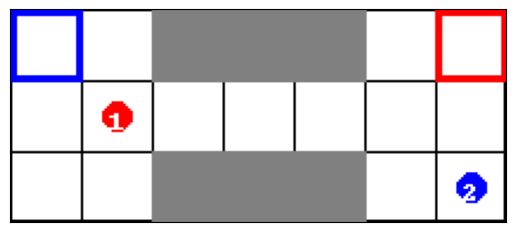

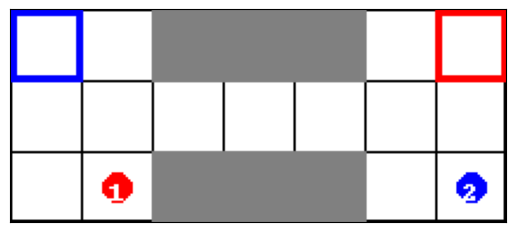

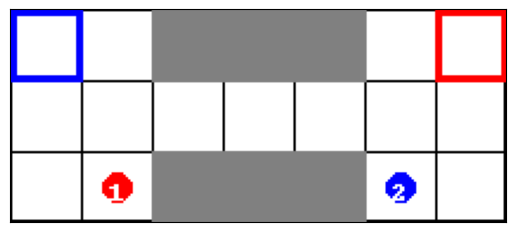

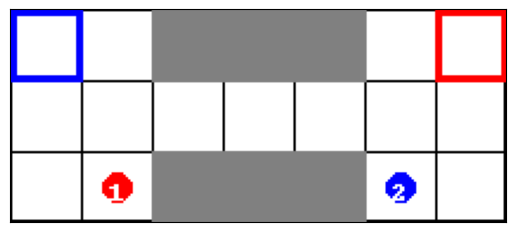

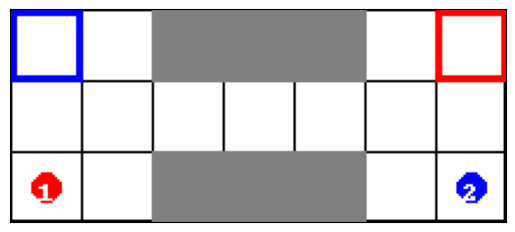

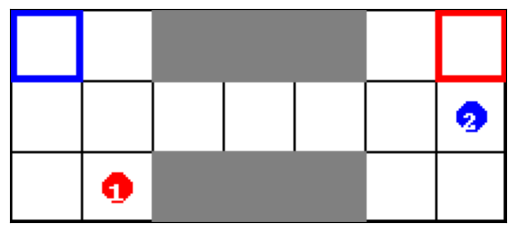

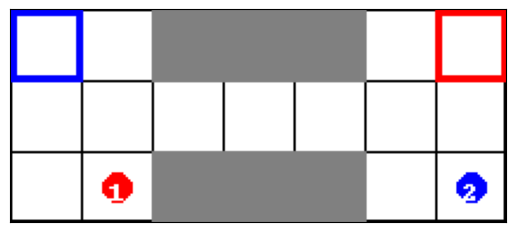

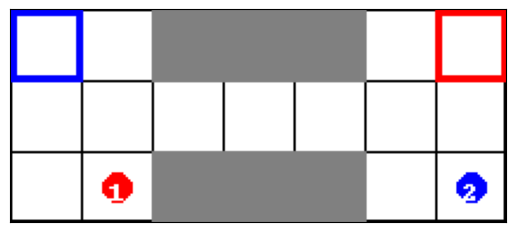

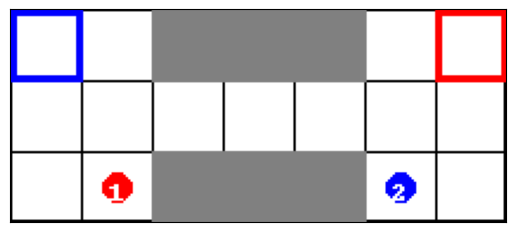

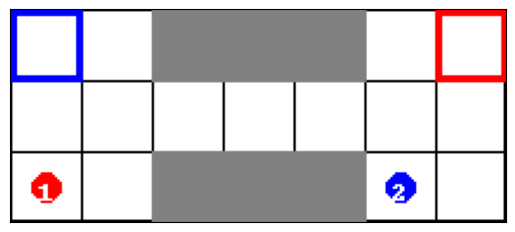

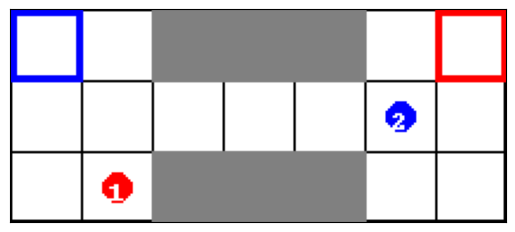

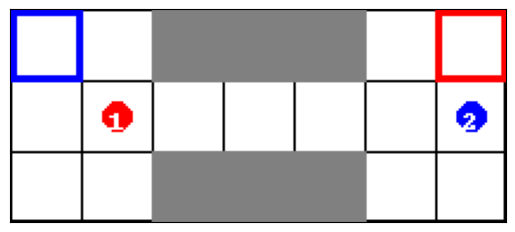

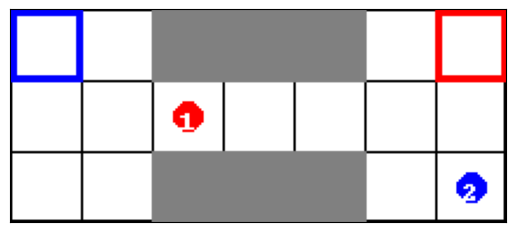

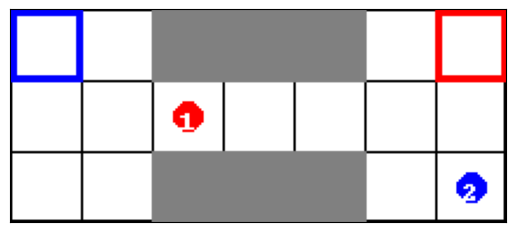

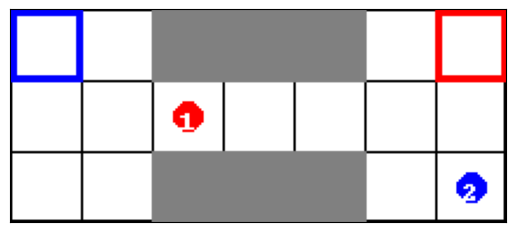

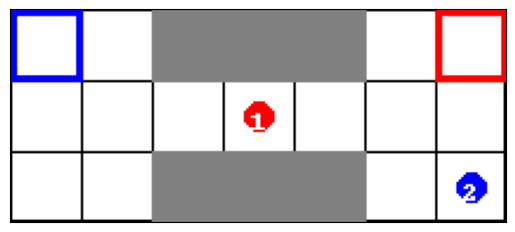

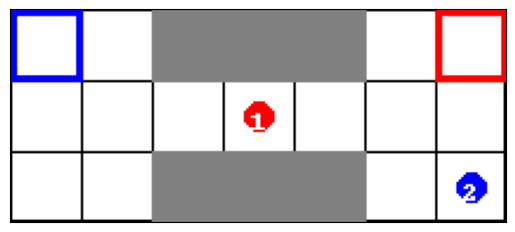

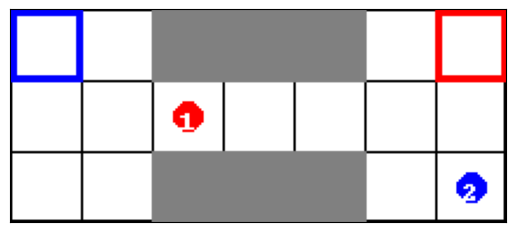

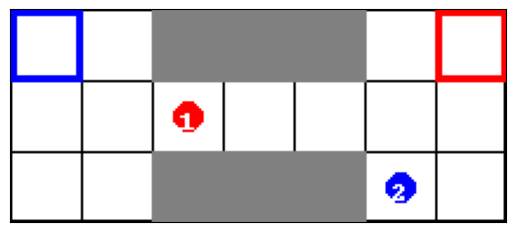

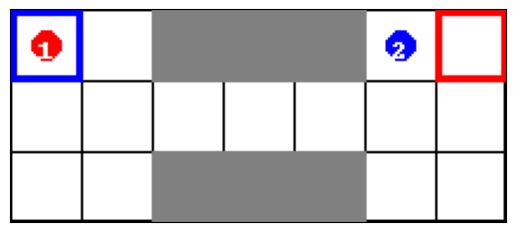

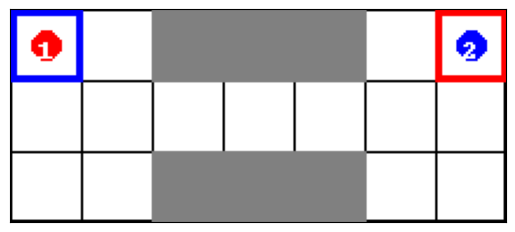

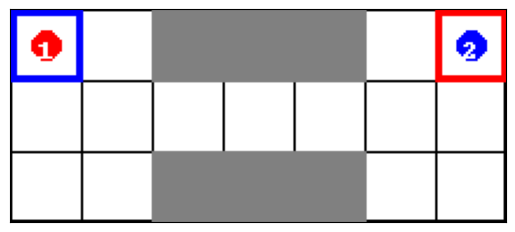

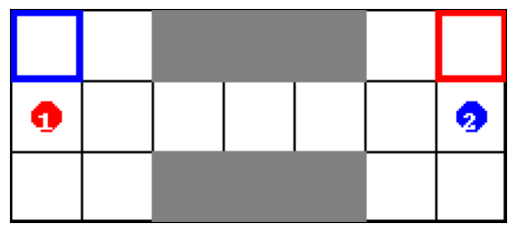

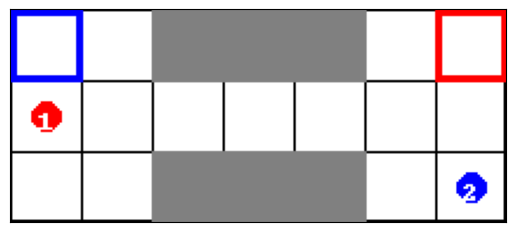

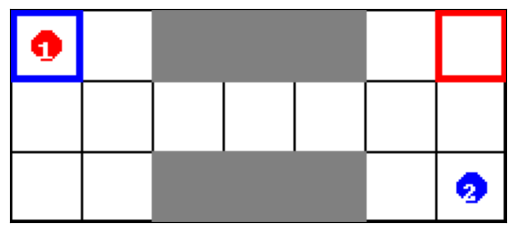

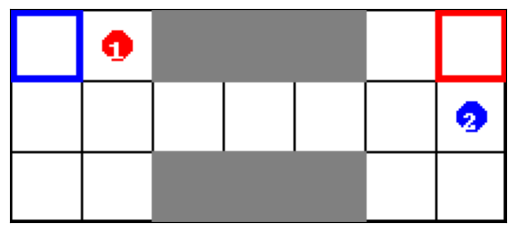

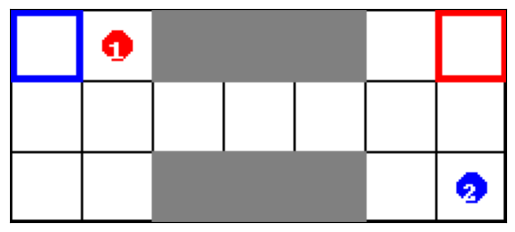

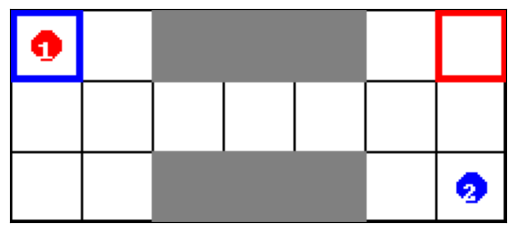

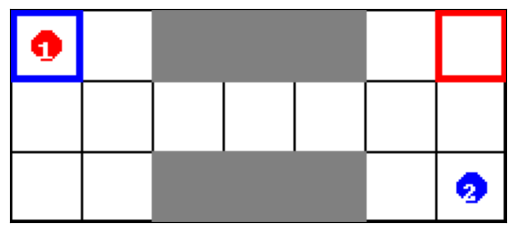

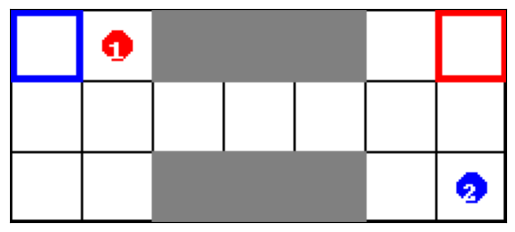

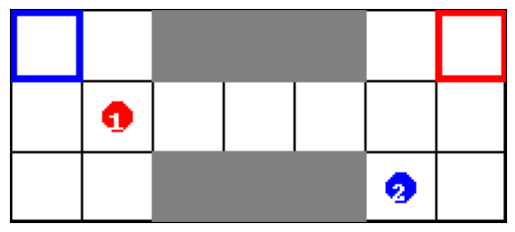

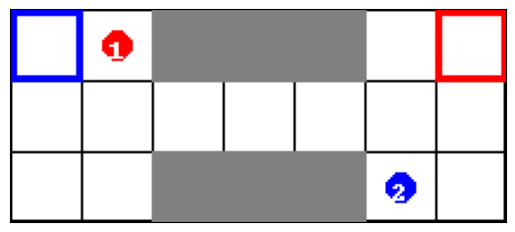

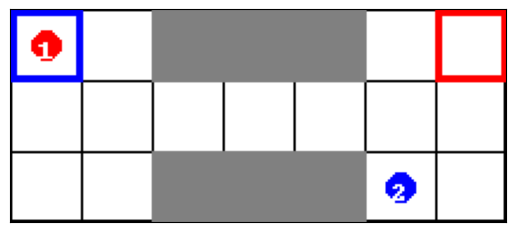

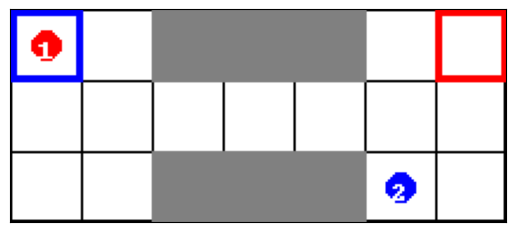

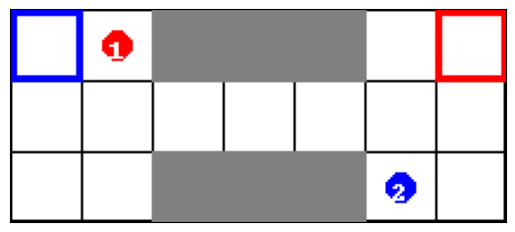

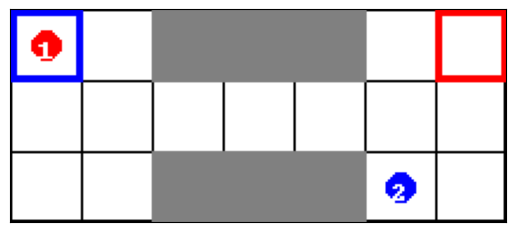

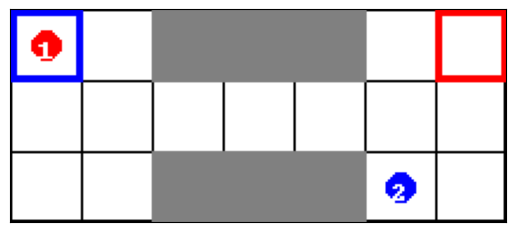

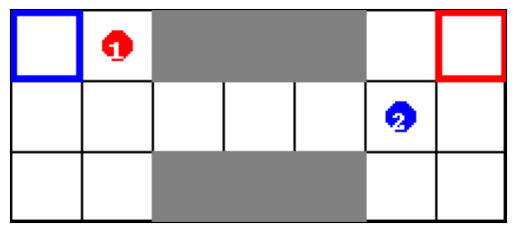

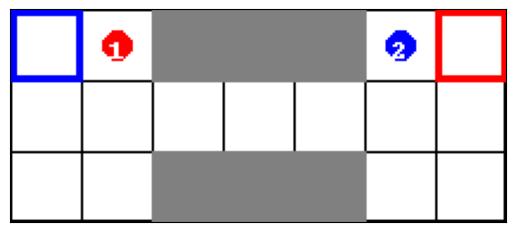

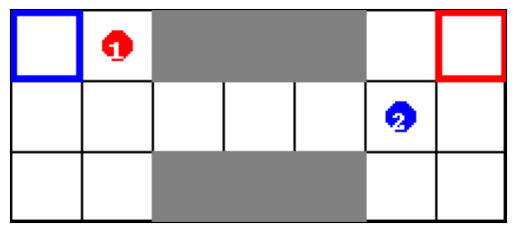

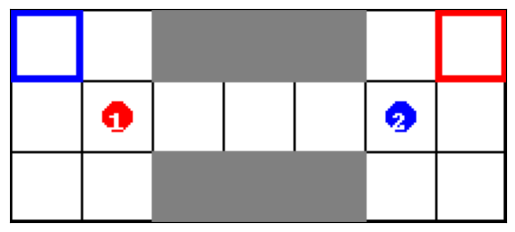

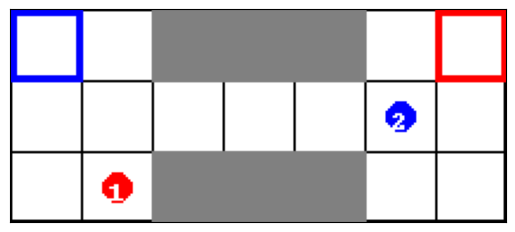

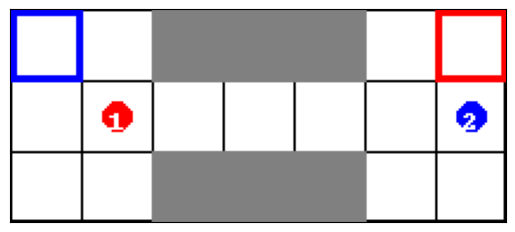

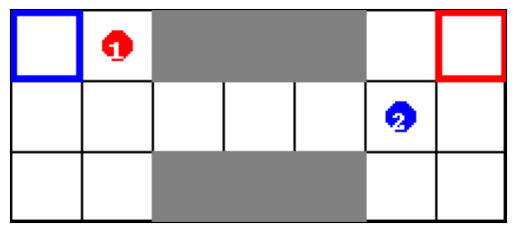

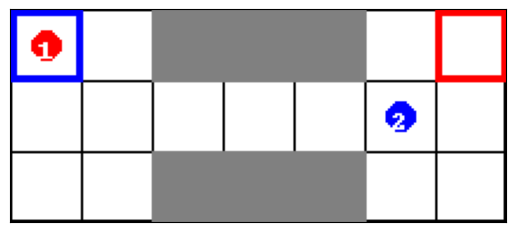

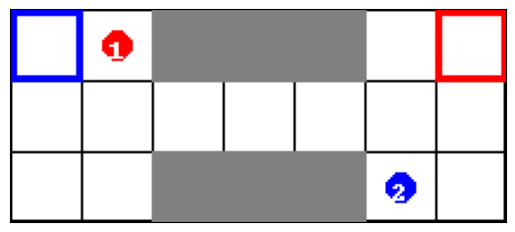

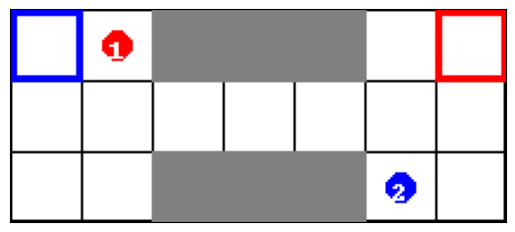

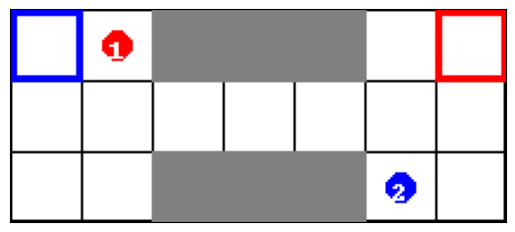

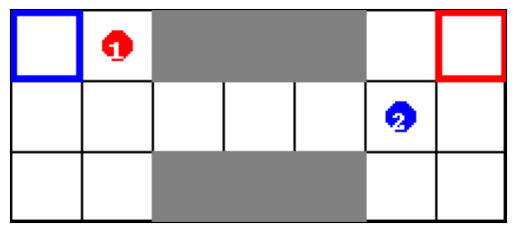

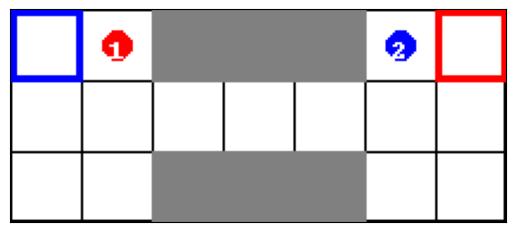

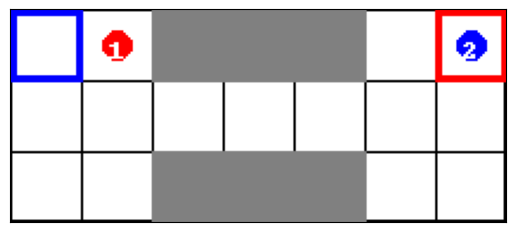

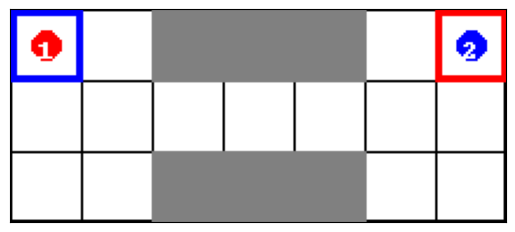

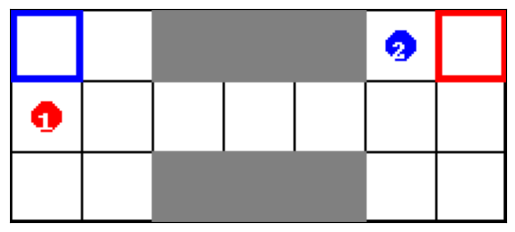

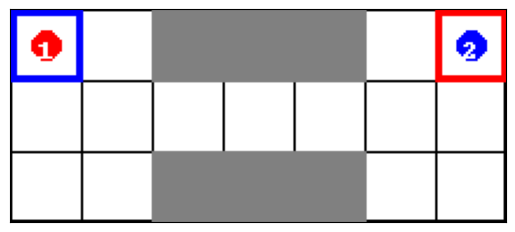

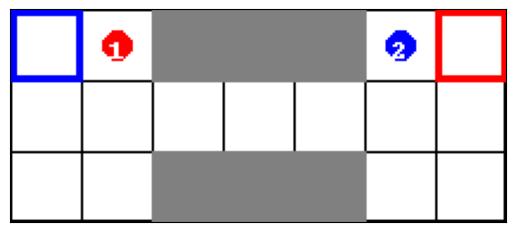

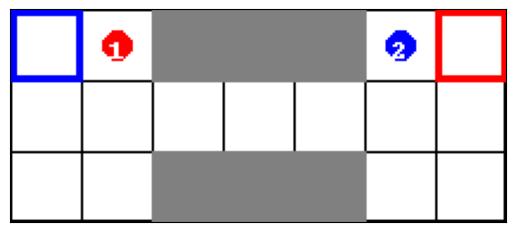

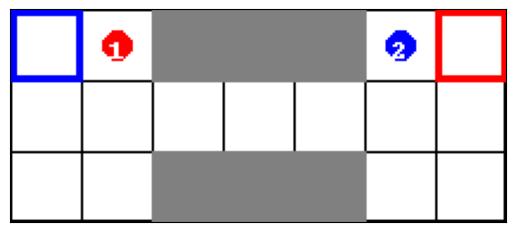

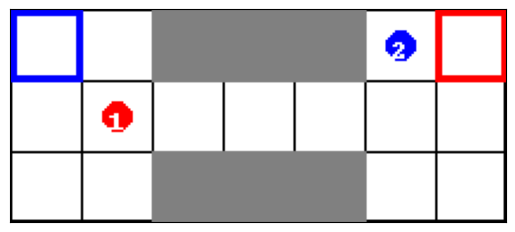

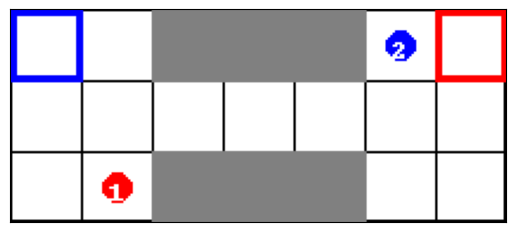

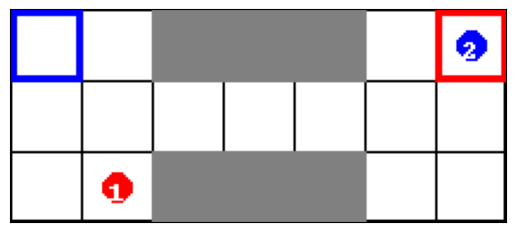

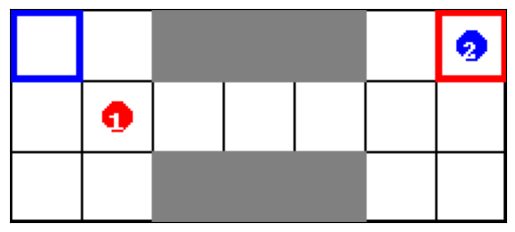

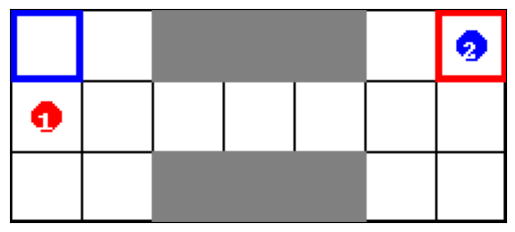

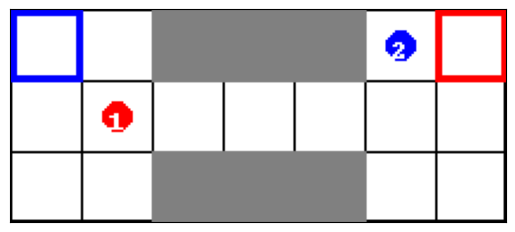

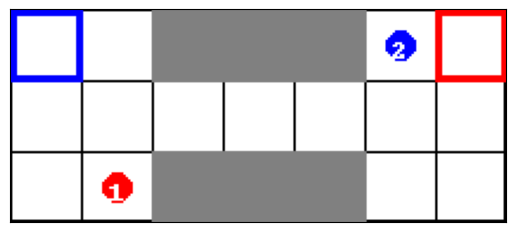

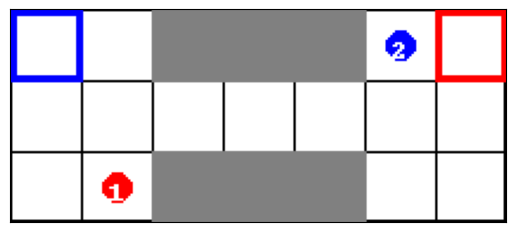

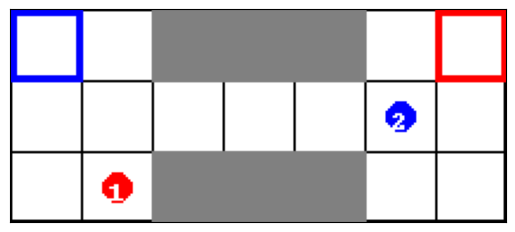

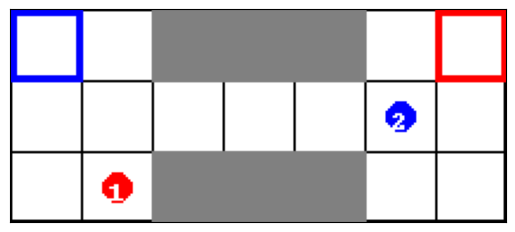

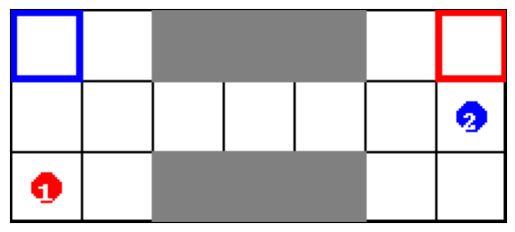

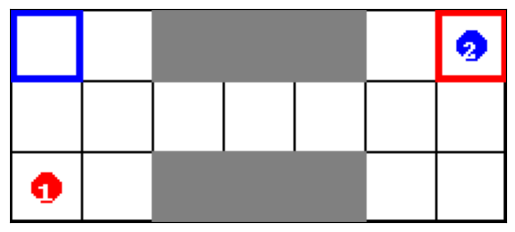

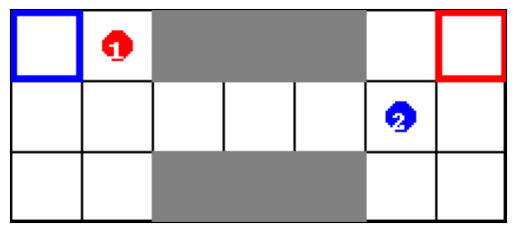

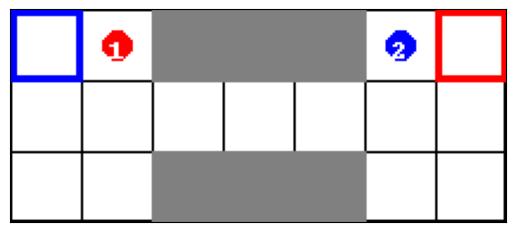

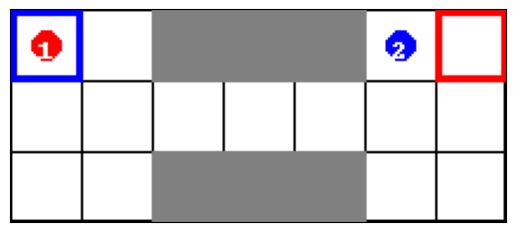

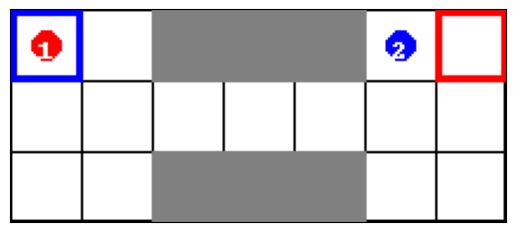

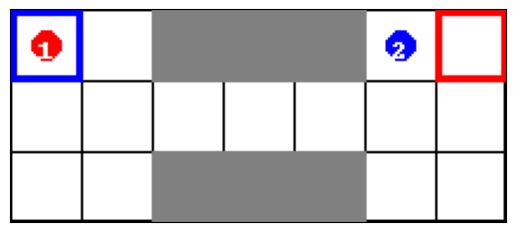

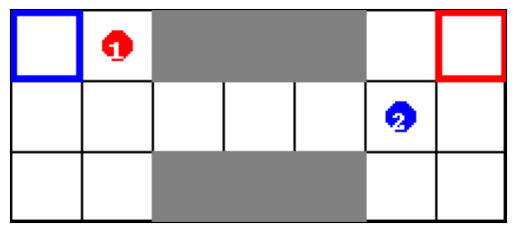

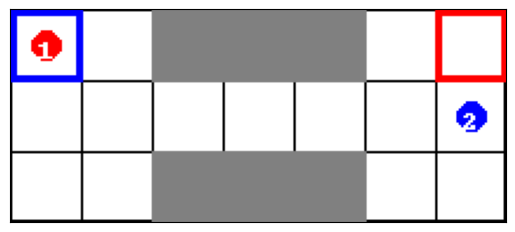

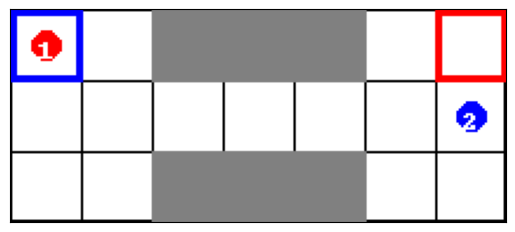

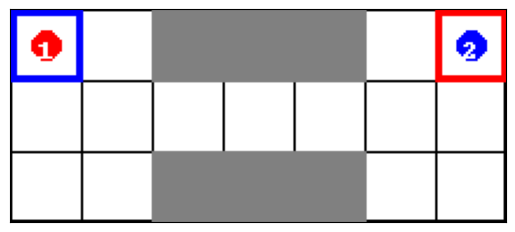

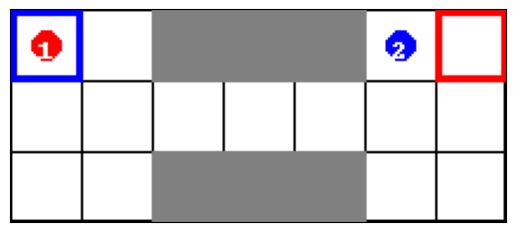

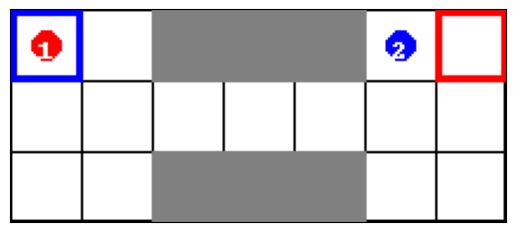

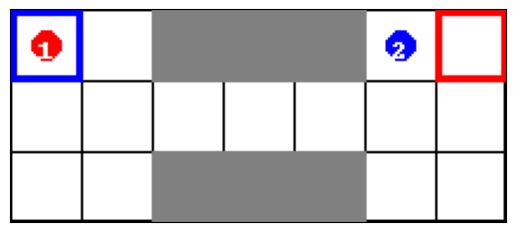

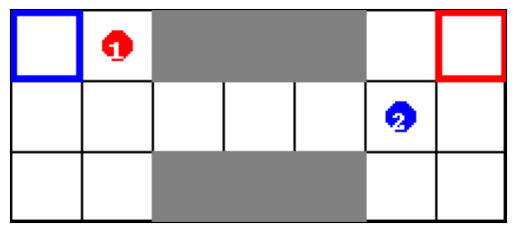

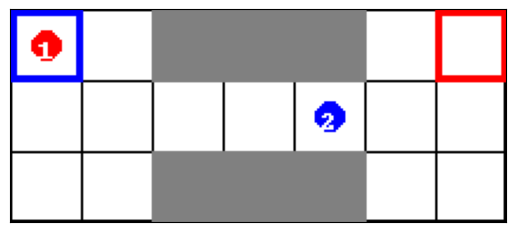

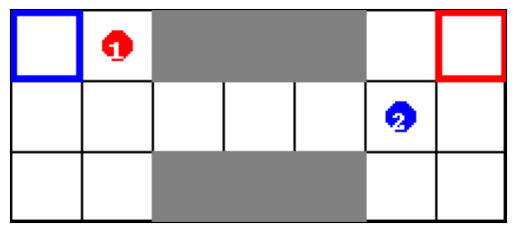

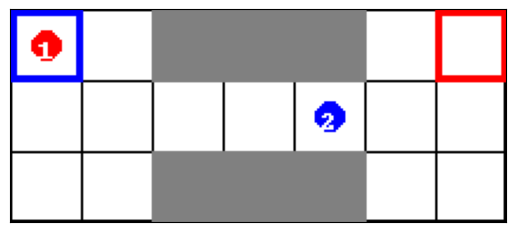

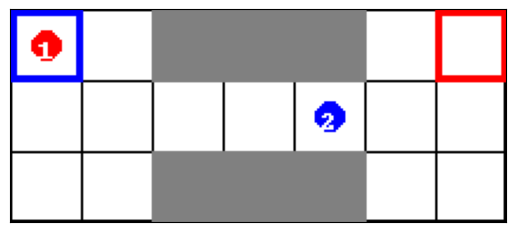

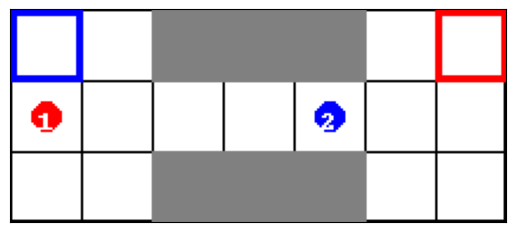

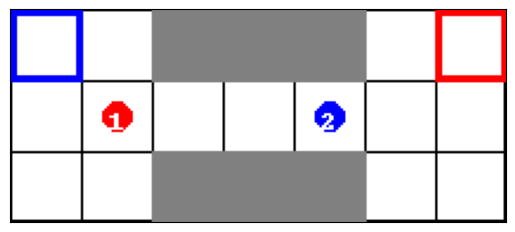

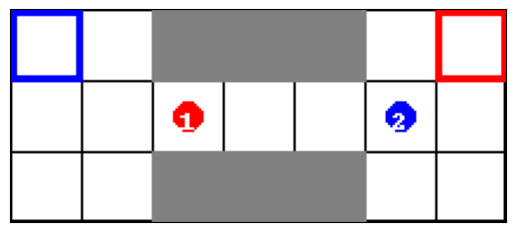

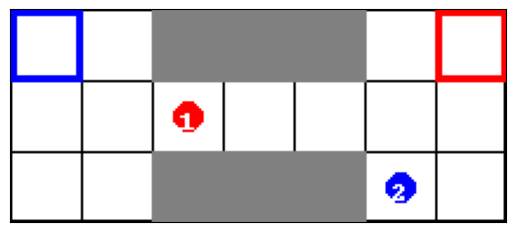

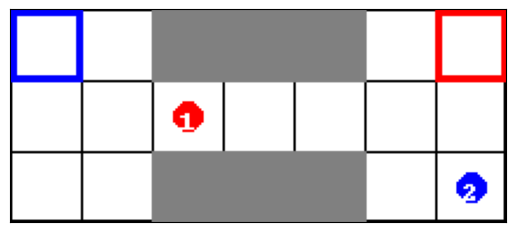

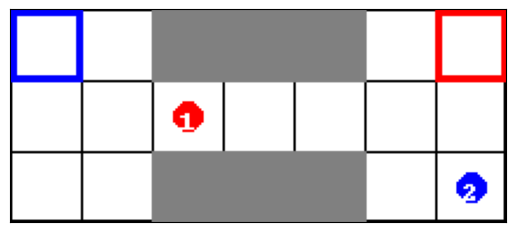

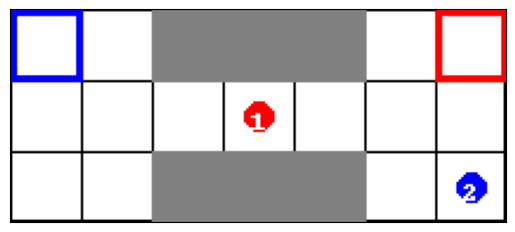

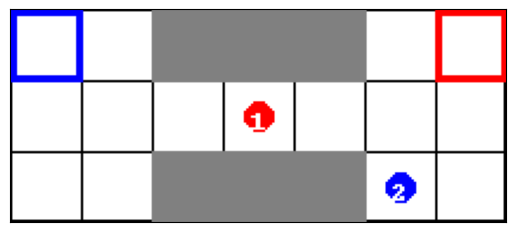

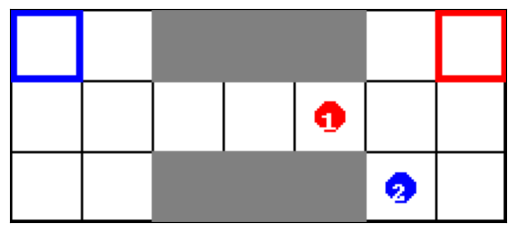

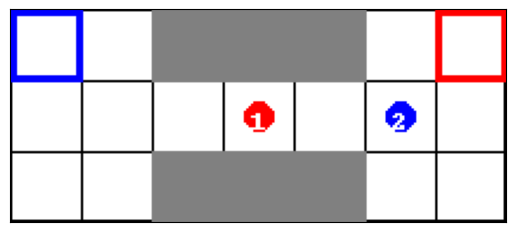

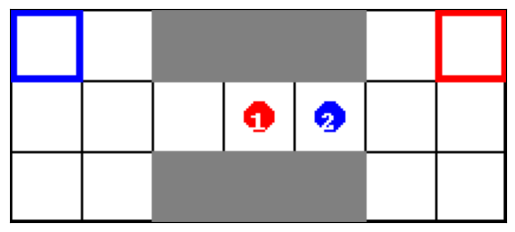

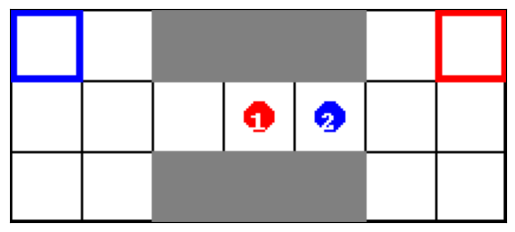

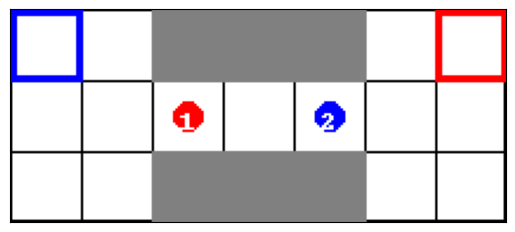

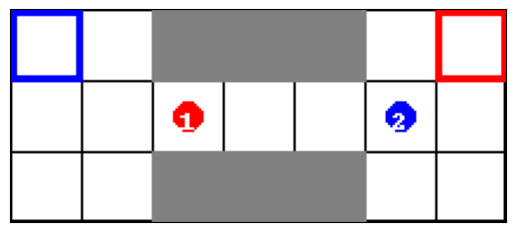

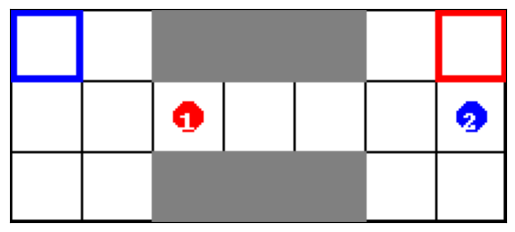

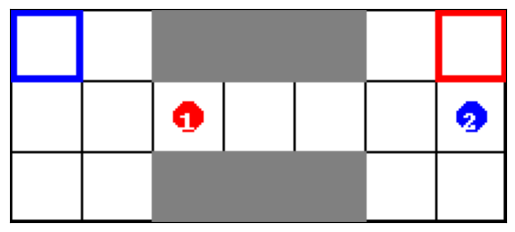

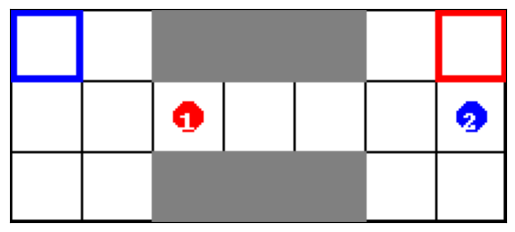

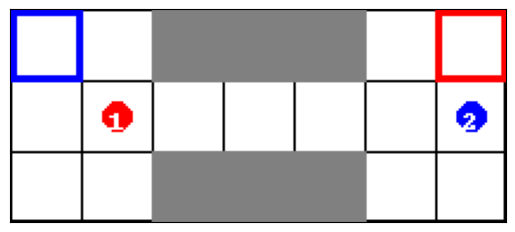

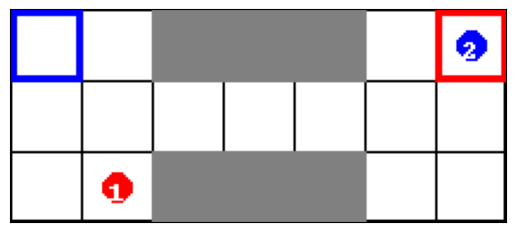

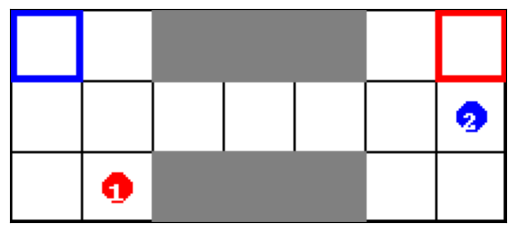

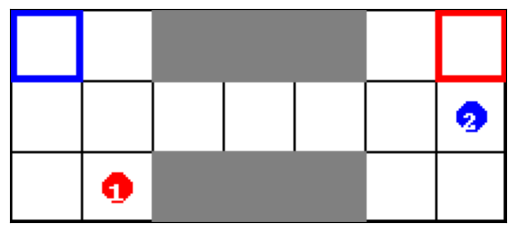

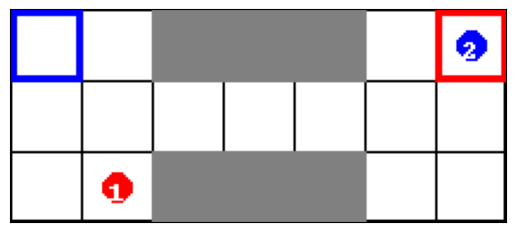

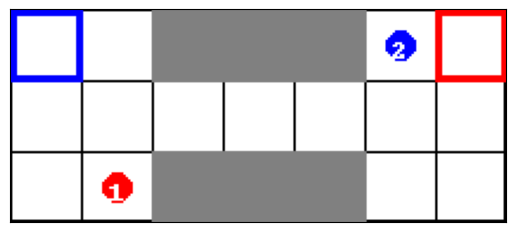

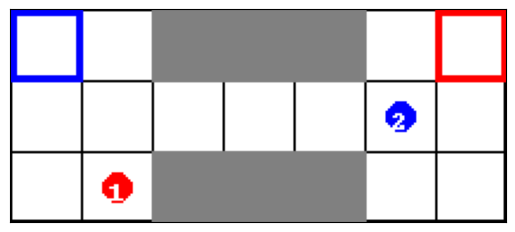

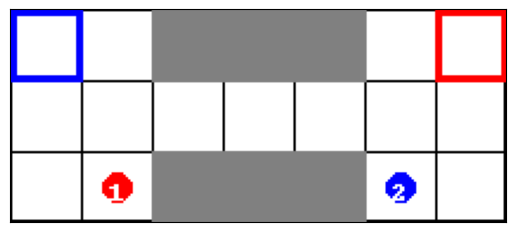

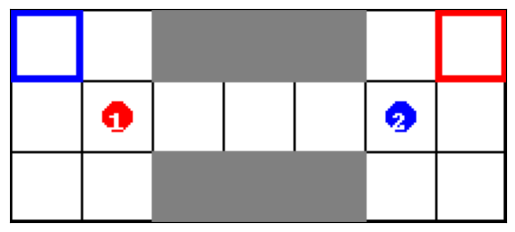

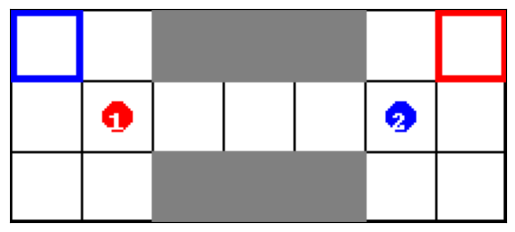

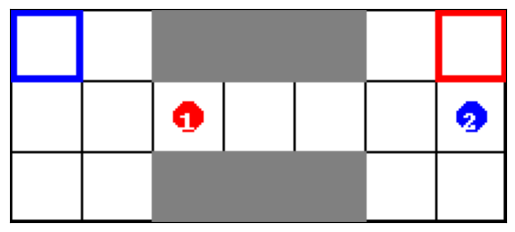

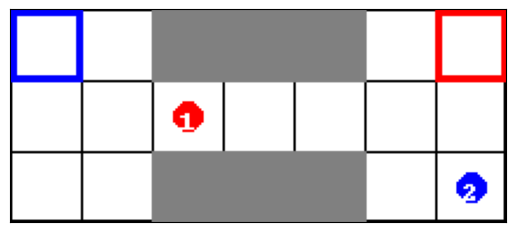

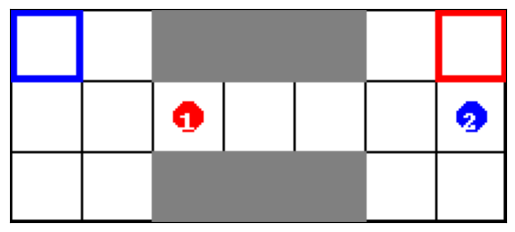

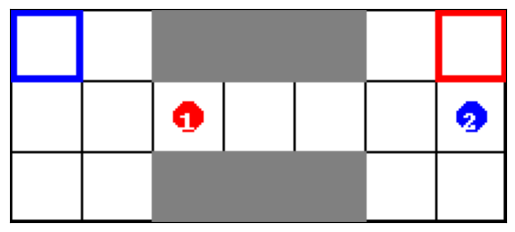

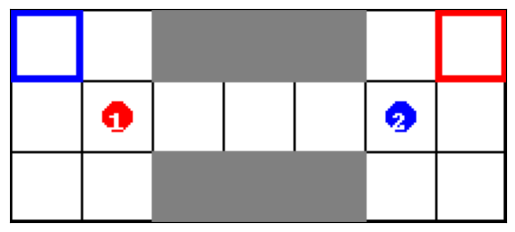

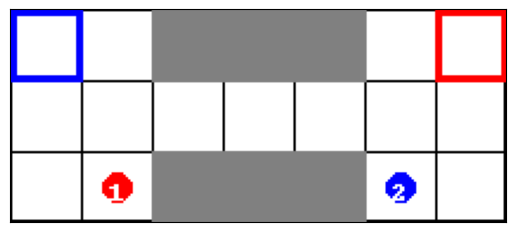

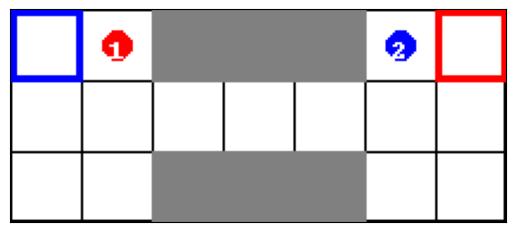

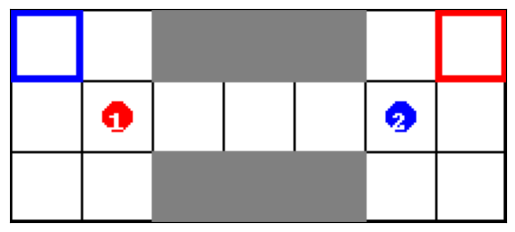

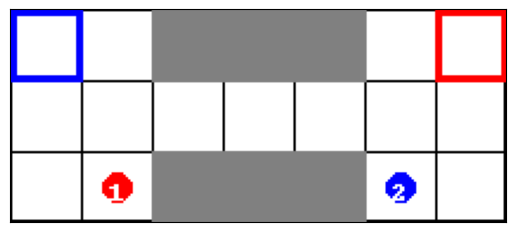

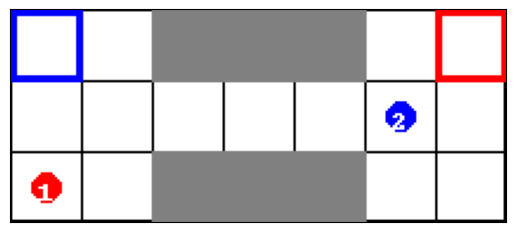

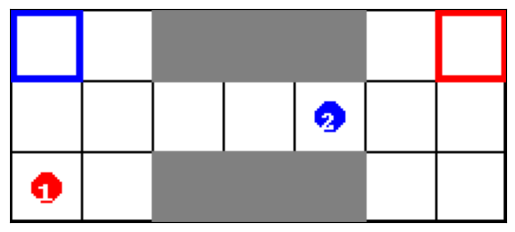

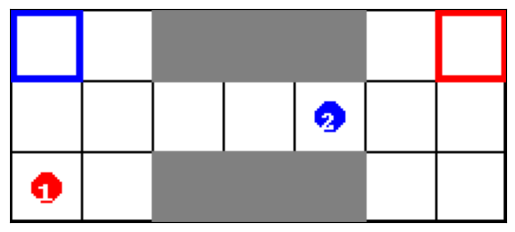

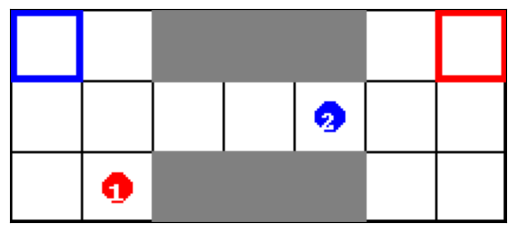

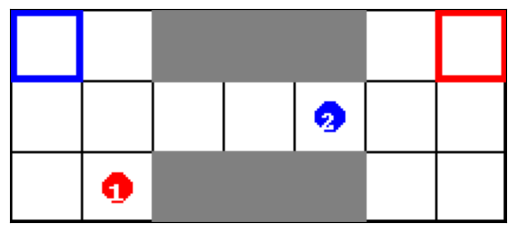

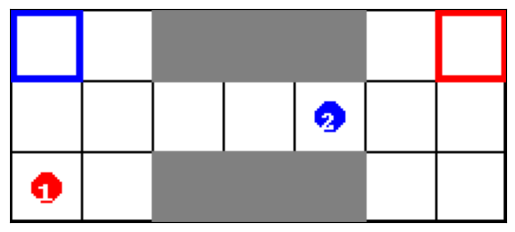

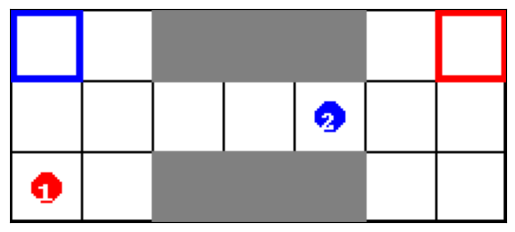

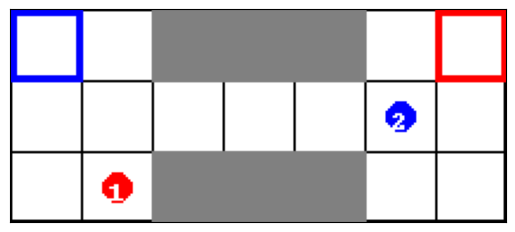

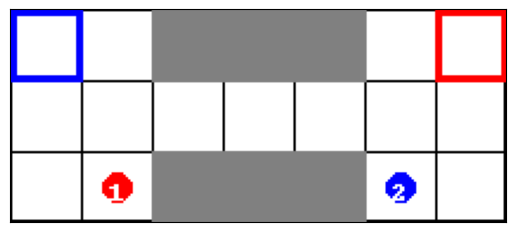

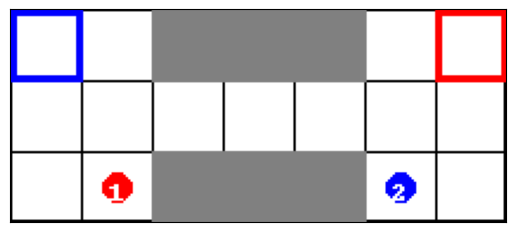

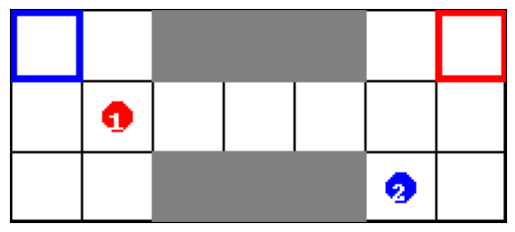

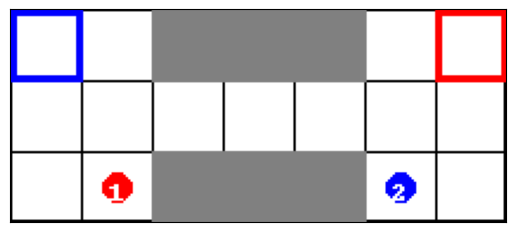

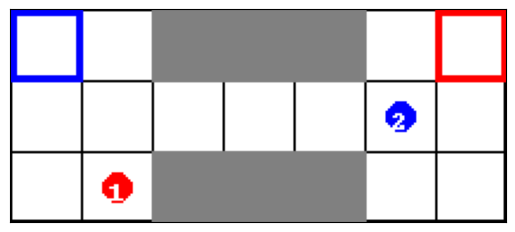

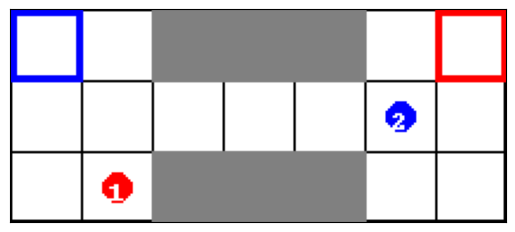

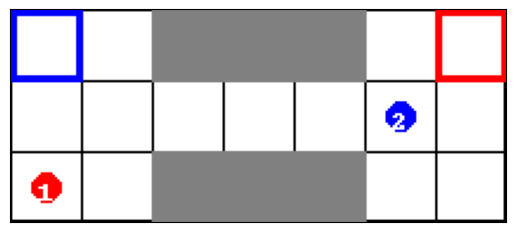

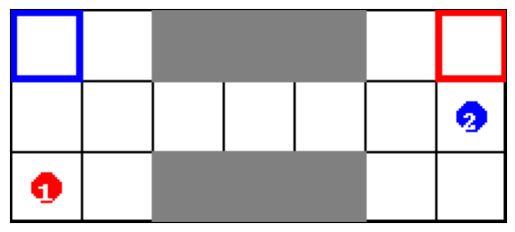

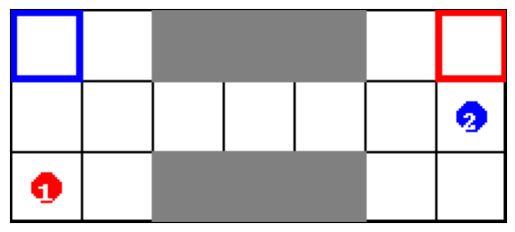

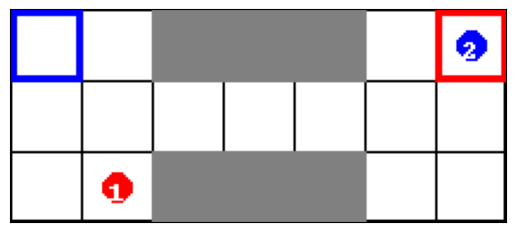

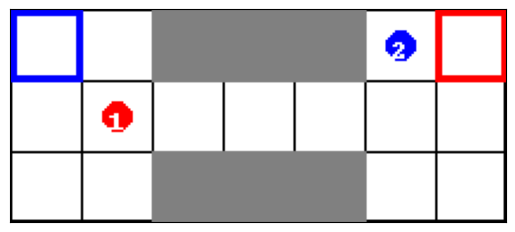

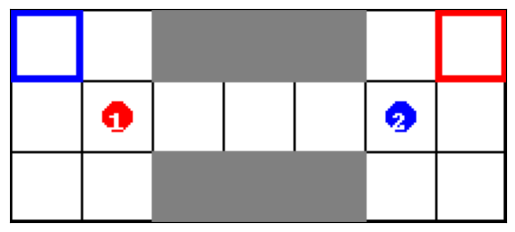

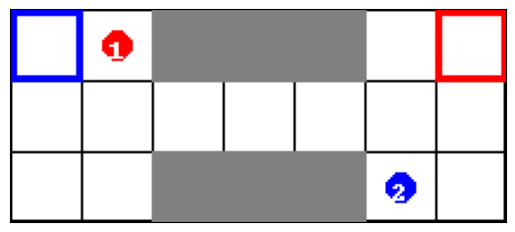

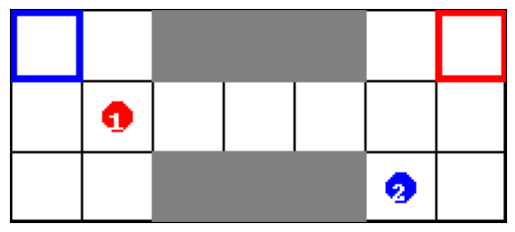

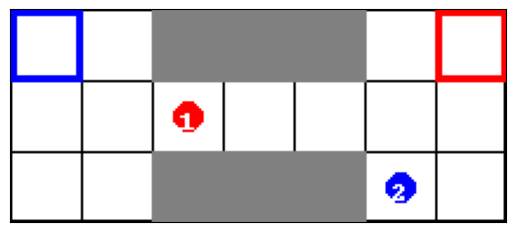

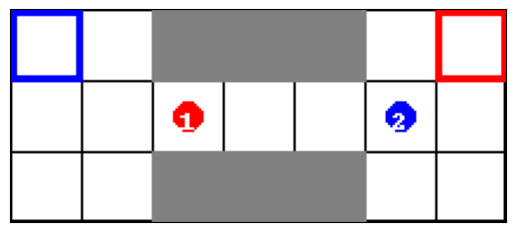

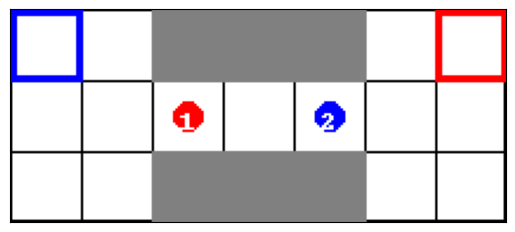

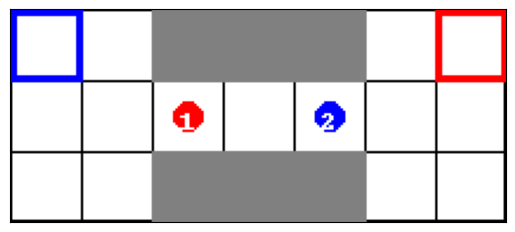

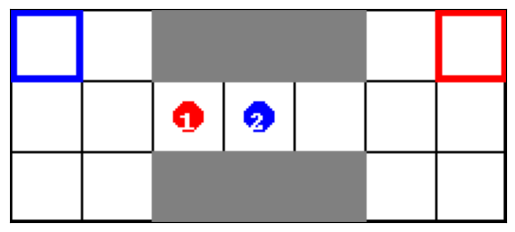

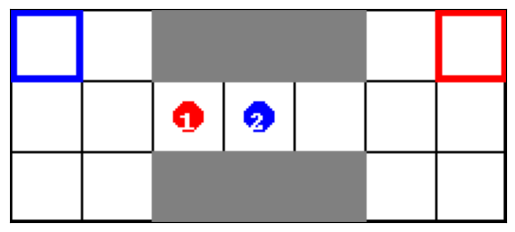

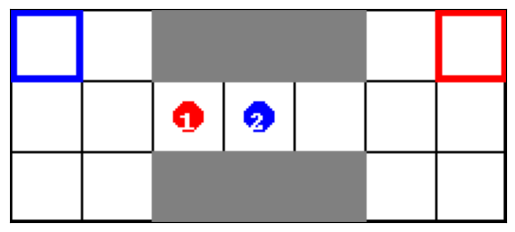

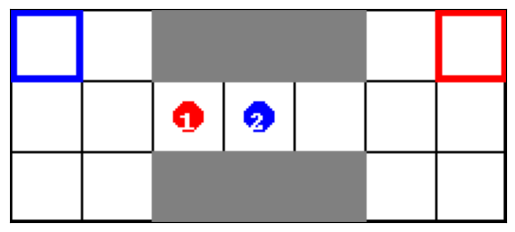

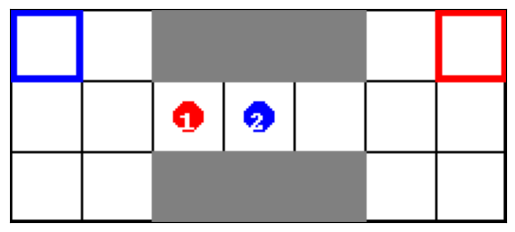

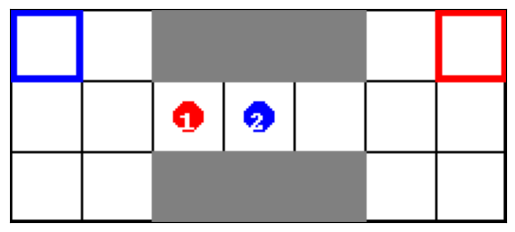

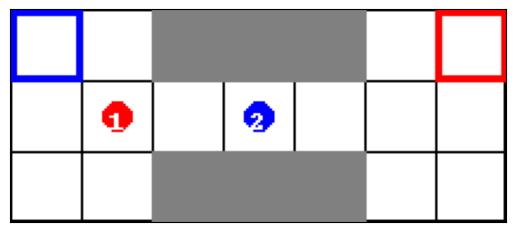

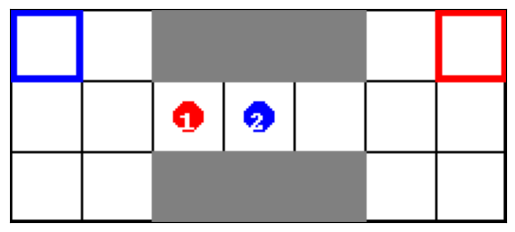

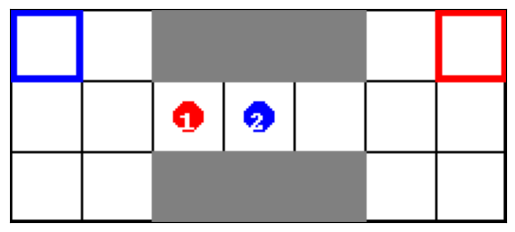

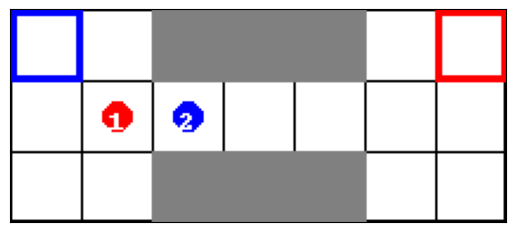

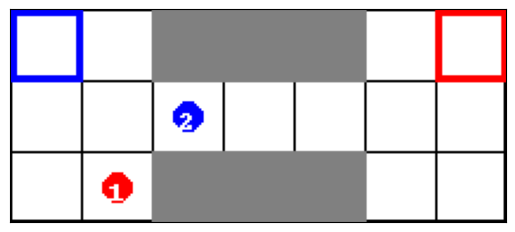

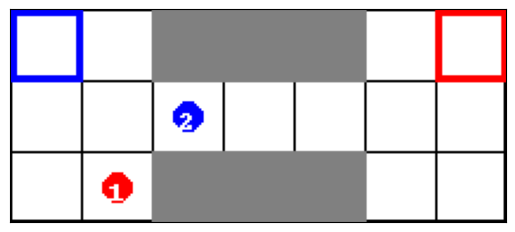

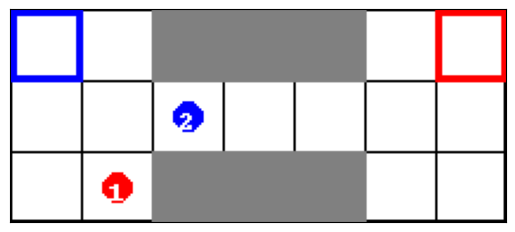

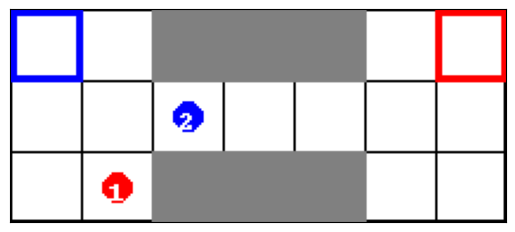

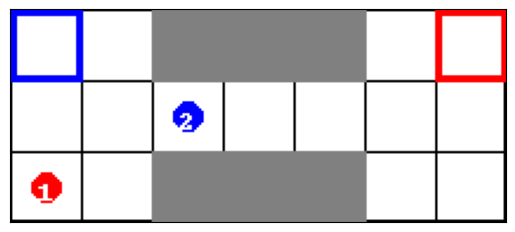

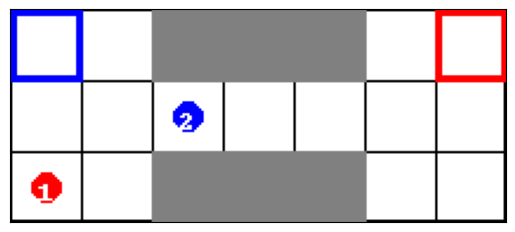

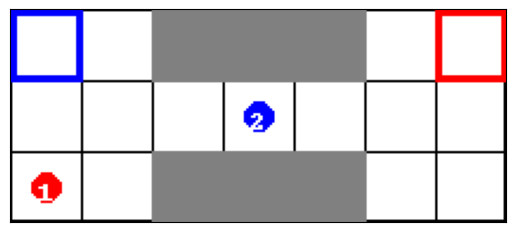

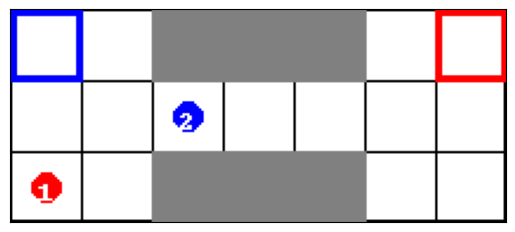

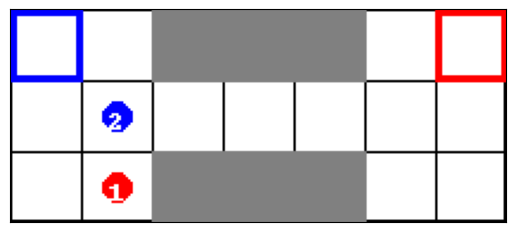

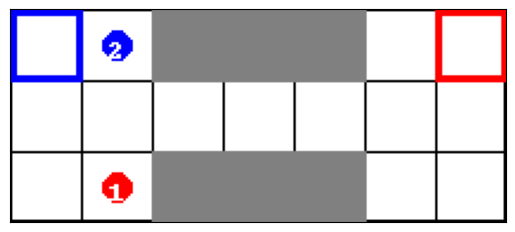

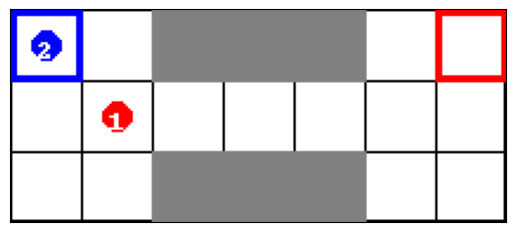

<Figure size 640x480 with 0 Axes>

In [78]:
numberOfAgents = 2
numberOfEpisodes = 10
numberOfSteps = 50

env = Switch(numberOfAgents=numberOfAgents, maximumNumberOfSteps=numberOfSteps)
def act(actionSpace):
    return [actionSpace[i].sample() for i in range(len(actionSpace))]

for episode in range(numberOfEpisodes):
    observation = env.reset()
    totalRewards = np.zeros(numberOfAgents)
    done = [False for _ in range(numberOfAgents)]

    for step in range(numberOfSteps):
        actions = act(env.actionSpace)
        observation, rewards, done, _ = env.step(actions)
        totalRewards += rewards
        env.render(mode='human')
        if all(done):
            break
env.endTheGame()

##Generate GIF

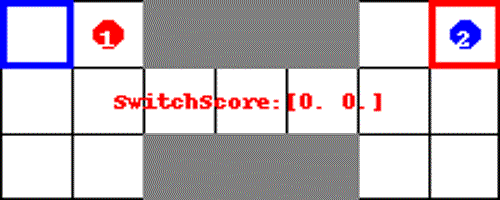

In [79]:
numberOfAgents = 2
numberOfEpisodes = 10
numberOfSteps = 50

env = Switch(numberOfAgents=numberOfAgents, maximumNumberOfSteps=numberOfSteps)

def act(actionSpace):
    return [actionSpace[i].sample() for i in range(len(actionSpace))]
images=[]
totalRewards = np.zeros(numberOfAgents)
for episode in range(numberOfEpisodes):
    observation = env.reset()

    done = [False for _ in range(numberOfAgents)]
    text="Switch"
    for step in range(numberOfSteps):
        actions = act(env.actionSpace)
        observation, rewards, done, _ = env.step(actions)
        totalRewards += rewards
        img = env.render(mode='rgb_array')
        pil_img = Image.fromarray(img)
        draw = ImageDraw.Draw(pil_img)
        text1=text+"Score:"+str(totalRewards)
        text_width, text_height = draw.textsize(text1)
        draw.text(((pil_img.width - text_width) // 2, 30 + 10), text1,fill=(255, 0, 0))
        resized_image = pil_img.resize((500,200))
        images.append(resized_image)
        if all(done):
            break
env.endTheGame()
if images:
    GifFilePath = 'SwitchRandomAgent.gif'
    images[0].save(GifFilePath, save_all=True, append_images=images[1:], duration=100, loop=1)
    display(DisplayImage(filename=GifFilePath))

##DQN

In [80]:
class DQN(nn.Module):
    def __init__(self, inputDimensions, outputDimensions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputDimensions, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, outputDimensions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, inputDimensions, outputDimensions, device, observationSpace, actionSpace, agentPosition, learningRate = 0.001, gamma=0.99, bufferCapacity=10000, epsilon=1.0, epsilonDecay=0.99, epsilonMinimum=0.01):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.observationSpace = observationSpace
        self.actionSpace = actionSpace
        self.agentPosition = agentPosition
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilonDecay = epsilonDecay
        self.epsilonMinimum = epsilonMinimum

        self.QNetwork = DQN(inputDimensions, outputDimensions).to(device)
        self.targetNetwork = DQN(inputDimensions, outputDimensions).to(device)
        self.targetNetwork.load_state_dict(self.QNetwork.state_dict())
        self.targetNetwork.eval()

        self.optimizer = optim.Adam(self.QNetwork.parameters(), lr=learningRate)
        self.buffer = deque(maxlen=bufferCapacity)

    def selectAction(self, state, eps):
      if random.random() < eps:
          return random.randint(0, self.actionSpace.n - 1)
      else:
          state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
          with torch.no_grad():
              return self.QNetwork(state).max(1)[1].item()

    def storeTransition(self, state, action, reward, nextState, done):
        transition = (state, action, reward, nextState, done)
        self.buffer.append(transition)

    def update(self, batchSize):
        if len(self.buffer) < batchSize:
            return

        transitions = random.sample(self.buffer, batchSize)
        batch = list(zip(*transitions))

        states, actions, rewards, nextStates, dones = batch

        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        nextStates = torch.tensor(nextStates, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        QValues = self.QNetwork(states).gather(1, actions)
        nextQValues = self.targetNetwork(nextStates).max(1)[0].unsqueeze(1)
        targetQValues = rewards + self.gamma * nextQValues * (1 - dones)

        loss = nn.MSELoss()(QValues, targetQValues)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon * self.epsilonDecay, self.epsilonMinimum)

    def updateTargetNetwork(self):
        self.targetNetwork.load_state_dict(self.QNetwork.state_dict())

def train(agents, env, numberOfEpisodes, batchSize, updateTargetHere):
    totalRewards = [[] for _ in range(len(agents))]
    totalEpsilons = [[] for _ in range(len(agents))]

    for episode in range(numberOfEpisodes):
        state = env.reset()
        done = False
        episodeRewards = [0] * len(agents)
        epsilons = [agent.epsilon for agent in agents]

        while not done:
            actions = [agent.selectAction(state[i], eps) for i, (agent, eps) in enumerate(zip(agents, epsilons))]
            nextState, rewards, doneArray, _ = env.step(actions)

            for i, agent in enumerate(agents):
                agent.storeTransition(state[i], actions[i], rewards[i], nextState[i], doneArray[i])
                episodeRewards[i] += rewards[i]

            state = nextState
            done = all(doneArray)

            for i, agent in enumerate(agents):
                if len(agent.buffer) >= batchSize:
                    agent.update(batchSize)

            for i, agent in enumerate(agents):
                epsilons[i] = max(agent.epsilonMinimum, epsilons[i] * agent.epsilonDecay)

            if episode % updateTargetHere == 0:
                for agent in agents:
                    agent.updateTargetNetwork()

        for i in range(len(agents)):
            totalRewards[i].append(episodeRewards[i])
            totalEpsilons[i].append(epsilons[i])

    return totalRewards, totalEpsilons


def evaluate(agents, env, numberOfEpisodes):
    episodeRewards = [[] for _ in range(len(agents))]

    for episode in range(numberOfEpisodes):
        state = env.reset()
        done = False
        totalReward = [0] * len(agents)

        while not done:
            actions = [agent.selectAction(state[i], 0) for i, agent in enumerate(agents)]
            nextState, rewards, doneArray, _ = env.step(actions)

            for i, agent in enumerate(agents):
                totalReward[i] += rewards[i]
            state = nextState
            done = all(doneArray)

        for i in range(len(agents)):
            episodeRewards[i].append(totalReward[i])

    return episodeRewards

In [81]:
numberOfAgents = 2
env = Switch(numberOfAgents=numberOfAgents)

agent = [DQNAgent(inputDimensions=env.observationSpace[i].shape[0], outputDimensions=env.actionSpace[i].n, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), observationSpace=env.observationSpace[i], actionSpace=env.actionSpace[i], agentPosition=i) for i in range(numberOfAgents)]

numberOfEpisodes = 500
batchSize = 400
updateTargetHere = 10

rewards, epsilons = train(agent, env, numberOfEpisodes, batchSize, updateTargetHere)


In [82]:
evaluationRewards = evaluate(agent, env, 100)

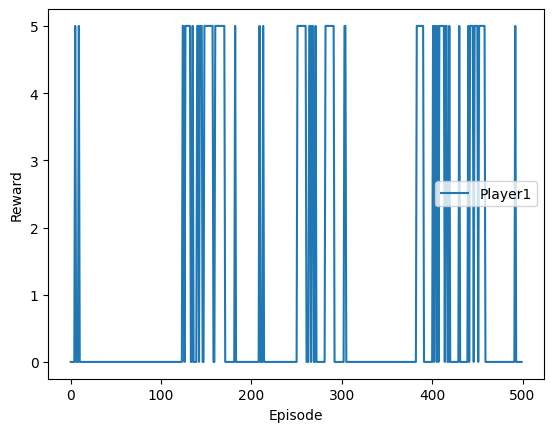

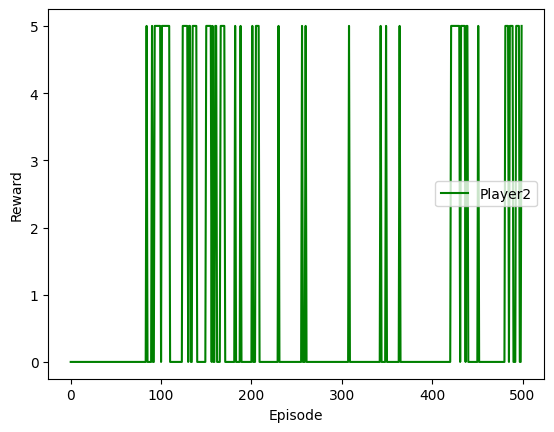

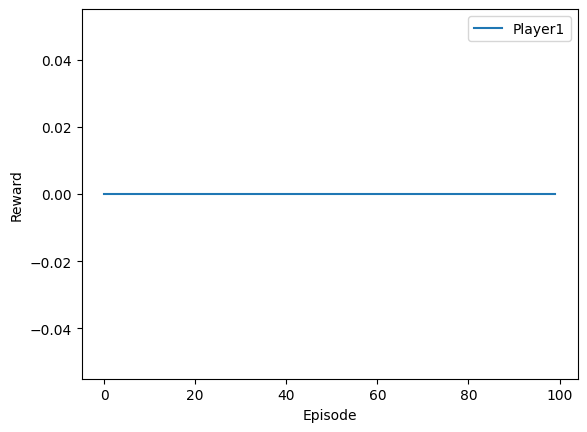

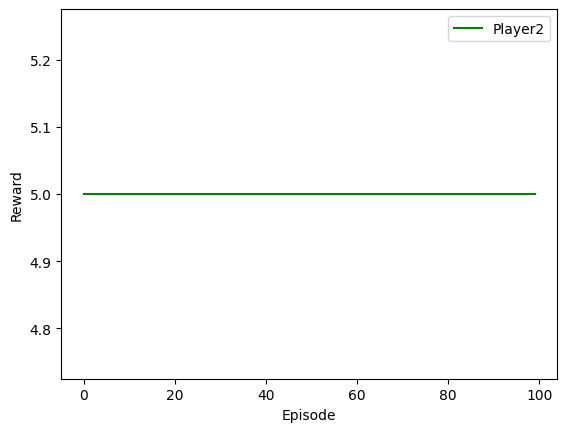

In [83]:
def plotTotalRewardsForAgent1(rewards):
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards[0], label = "Player1")
    plt.legend()
    plt.show()

def plotTotalRewardsForAgent2(rewards):
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards[1], label = "Player2", color = "green")
    plt.legend()
    plt.show()

def plotEvaluationRewardsForAgent1(evaluationRewards):
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(evaluationRewards[0], label = "Player1")
    plt.legend()
    plt.show()

def plotEvaluationRewardsForAgent2(evaluationRewards):
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(evaluationRewards[1], label = "Player2", color = "green")
    plt.legend()
    plt.show()

plotTotalRewardsForAgent1(rewards)
plotTotalRewardsForAgent2(rewards)
plotEvaluationRewardsForAgent1(evaluationRewards)
plotEvaluationRewardsForAgent2(evaluationRewards)

##PPO

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class PPONetwork(nn.Module):
    def __init__(self, inputDimensions, actionDimensions):
        super(PPONetwork, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(inputDimensions, 128),
            nn.ReLU(),
            nn.Linear(128, actionDimensions),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(inputDimensions, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        state = np.array(state)  # Convert the list to a NumPy array
        state = torch.from_numpy(state).float().to(device)
        actionProbabilities = self.actor(state)
        value = self.critic(state)
        return actionProbabilities, value

class PPOAgent:
    def __init__(self, env, numberOfAgents, inputDimensions, actionDimensions, lr = 0.001, gamma = 0.99, KValueEpochs = 10, clipEpsilon = 0.1):
        self.env = env
        self.numberOfAgents = numberOfAgents
        self.model = PPONetwork(inputDimensions, actionDimensions).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.KValueEpochs = KValueEpochs
        self.clipEpsilon = clipEpsilon
        self.mse_loss = nn.MSELoss()

    def selectAction(self, state):
        actionProbabilities, _ = self.model(state)
        distribution = Categorical(actionProbabilities)
        action = distribution.sample()
        return action.item(), distribution.log_prob(action)

    def update(self, states, actions, rewards, logarithmicProbabilities):
        advantages = self.computeAdvantages(states, rewards)

        for _ in range(self.KValueEpochs):
            for agent_i in range(self.numberOfAgents):
                actionProbabilities, values = self.model(states[agent_i])
                distribution = Categorical(actionProbabilities)
                oldLogarithmicProbabilities = logarithmicProbabilities[agent_i].detach()
                newLogarithmicProbabilities = distribution.log_prob(torch.tensor(actions[agent_i]).to(device))

                ratio = (newLogarithmicProbabilities - oldLogarithmicProbabilities).exp()
                surr1 = ratio * advantages[agent_i]
                surr2 = torch.clamp(ratio, 1 - self.clipEpsilon, 1 + self.clipEpsilon) * advantages[agent_i]
                loss = -torch.min(surr1, surr2) + self.mse_loss(values, advantages[agent_i])

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def computeAdvantages(self, states, rewards):
        with torch.no_grad():
            _, values = self.model(torch.tensor(states).float().to(device))

        advantages = torch.tensor(rewards).unsqueeze(1).float().to(device) + self.gamma * values - values
        return advantages.detach()

    def train(self, maxEpisodes = 1000, maxTimesteps = 800, updateTimestep = 100):
        rewards = []
        agent1Rewards = []
        agent2Rewards = []
        averageRewards = []
        timestep = 0

        for i_episode in range(1, maxEpisodes + 1):
            state = self.env.reset()
            episodeReward = np.zeros(self.numberOfAgents)

            for t in range(maxTimesteps):
                timestep += 1

                actions = []
                logarithmicProbabilities = []
                for agent_i in range(self.numberOfAgents):
                    action, log_prob = self.selectAction(state[agent_i])
                    actions.append(action)
                    logarithmicProbabilities.append(log_prob)

                nextState, reward, done, _ = self.env.step(actions)
                episodeReward += np.array(reward)

                self.update(state, actions, reward, logarithmicProbabilities)

                state = nextState

                if timestep % updateTimestep == 0:
                    self.update(state, actions, reward, logarithmicProbabilities)

                if all(done):
                    break

            rewards.append(episodeReward)
            agent1Rewards.append(episodeReward[0])
            agent2Rewards.append(episodeReward[1])

            averageReward = np.mean(rewards[-10:])
            averageRewards.append(averageReward)

        return agent1Rewards, agent2Rewards

    def evaluate(self, evaluationEpisodes = 100):
        agent1Rewards = []
        agent2Rewards = []

        for _ in range(evaluationEpisodes):
            state = self.env.reset()
            episodeReward = np.zeros(self.numberOfAgents)

            while True:
                actions = []
                for agent_i in range(self.numberOfAgents):
                    actionProbabilities, _ = self.model(state[agent_i])
                    distribution = Categorical(actionProbabilities)
                    action = distribution.sample()
                    actions.append(action.item())

                state, reward, done, _ = self.env.step(actions)
                episodeReward += np.array(reward)

                if all(done):
                    break

            agent1Rewards.append(episodeReward[0])
            agent2Rewards.append(episodeReward[1])

        return agent1Rewards, agent2Rewards

    def plotTotalRewards(self, agent1Rewards):
        plt.plot(agent1Rewards, label='Agent 1')
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.legend()
        plt.show()

    def plotTotalRewards(self, agent2Rewards):
        plt.plot(agent2Rewards, label='Agent 2', color = 'green')
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.legend()
        plt.show()

In [89]:
env = Switch(numberOfAgents=2)
numberOfAgents = env.numberOfAgents
inputDimensions = np.prod(env.observationSpace[0].shape)
actionDimensions = env.actionSpace[0].n

agent = PPOAgent(env, numberOfAgents, inputDimensions, actionDimensions, lr = 0.001, gamma = 0.99, KValueEpochs = 10, clipEpsilon = 0.1)
agent1Rewards, agent2Rewards = agent.train(maxEpisodes = 500, maxTimesteps = 400, updateTimestep = 10)

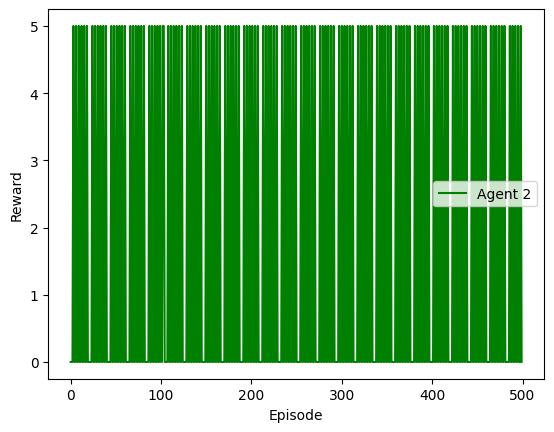

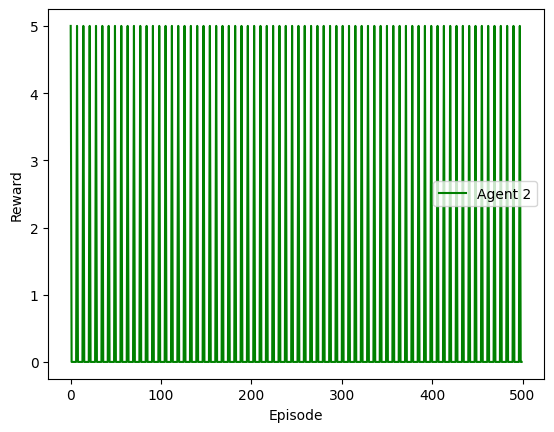

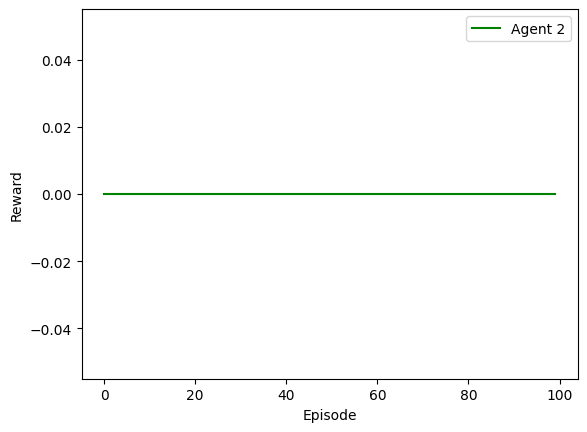

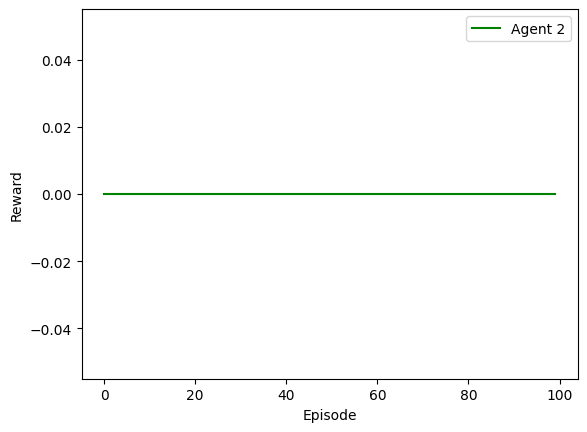

In [90]:
evaluationEpisodes = 100
agent1EvaluationRewards, agent2EvaluationRewards = agent.evaluate(evaluationEpisodes)
agent.plotTotalRewards(agent1Rewards)
agent.plotTotalRewards(agent2Rewards)
agent.plotTotalRewards(agent1EvaluationRewards)
agent.plotTotalRewards(agent2EvaluationRewards)